<a href="https://colab.research.google.com/github/Ammar1122s/Trading_Bot/blob/main/nasdaq_stock_price_prediction_using_lstm_(Multiple_Attributes)_Ensemble_fusion_(LSTM_GRU)_(ARIMA_Prohpet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime
from math import sqrt
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import requests
import json

#ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Concatenate, Input
import tensorflow as tf
import yfinance as yf

In [ ]:
def collect_data(Symbol, start_date):
    stock_data = yf.download(Symbol, start=start_date, end=datetime.now())
    return stock_data

#Test the function
df = collect_data('EBAY','2021-01-01')

print(df.tail())

[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2023-09-26  43.549999  44.240002  43.389999  43.490002  43.490002  5353400
2023-09-27  43.560001  43.759998  42.410000  42.889999  42.889999  5225600
2023-09-28  42.730000  43.889999  42.720001  43.650002  43.650002  4114900
2023-09-29  44.090000  44.599998  43.910000  44.090000  44.090000  4792900
2023-10-02  43.910000  44.040001  43.310001  43.355000  43.355000  2098864


In [ ]:
Symbols = ['AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'ALGN', 'AMAT',
    'AMD', 'AMGN', 'AMZN', 'ANSS', 'ASML', 'ATVI', 'AVGO', 'BIDU',
    'BIIB', 'BKNG', 'CDNS', 'CDW', 'CHKP', 'CHTR', 'CMCSA',
    'COST', 'CPRT', 'CRWD', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'DLTR',
    'DOCU', 'DXCM', 'EA', 'EBAY', 'EXC', 'FAST', 'FB', 'FISV',
    'FOXA', 'GILD', 'GOOG', 'GOOGL']
TEST_DATA_LENGTH = 60
start_date = '2020-01-01'
all_stocks = {}
print("Let us evaluate for all of NASDAQ")
for stock in Symbols:
    all_stocks[stock] = collect_data(stock,start_date)


Let us evaluate for all of NASDAQ
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['AAPL']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-01-01 -> 2023-08-30 00:16:10.982908)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['FB']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['FISV']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


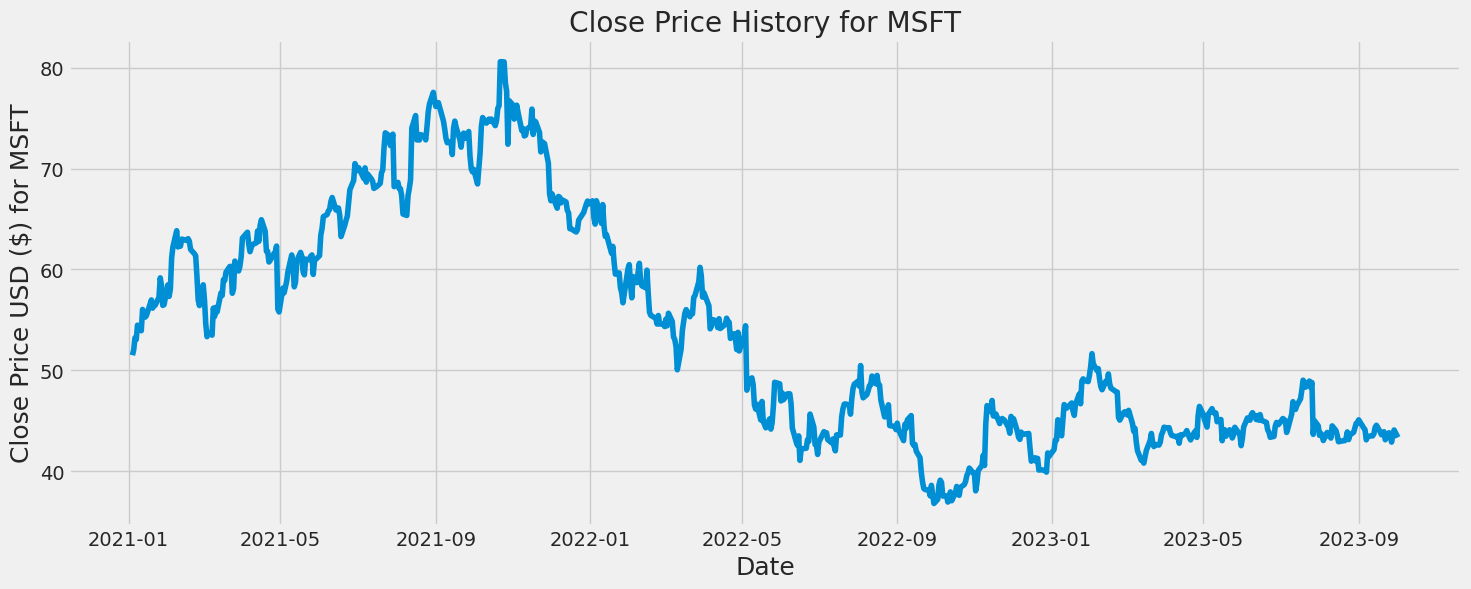

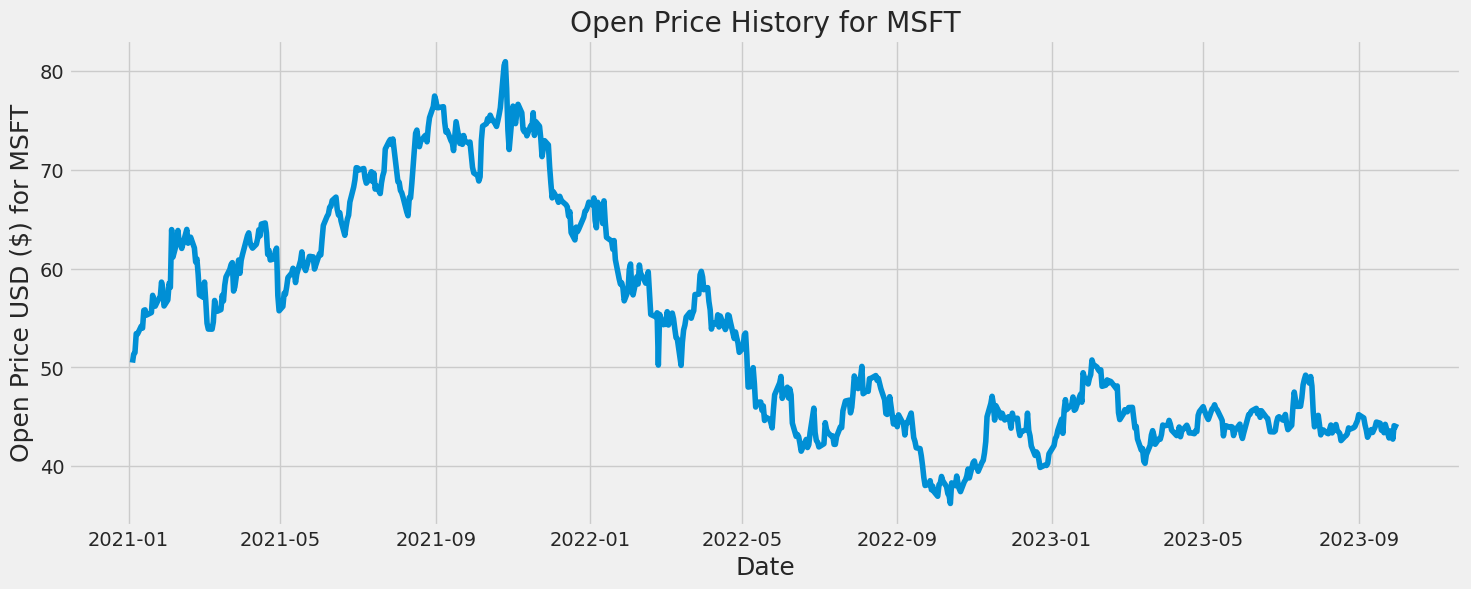

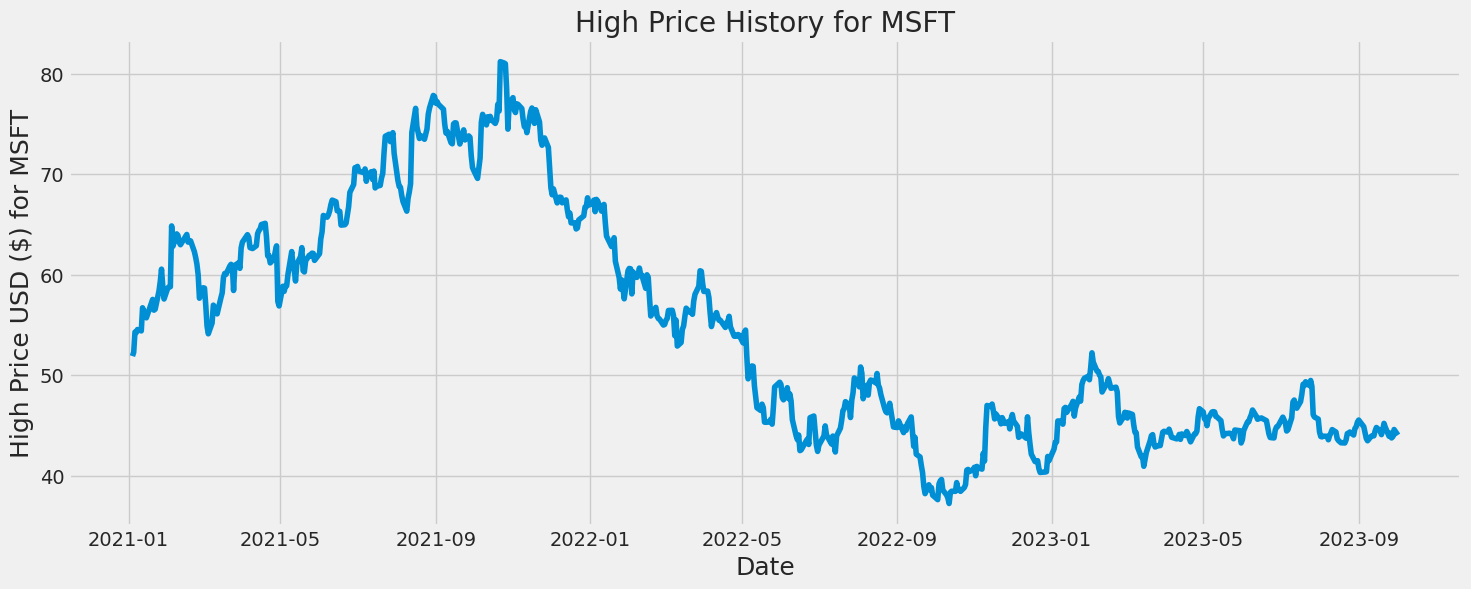

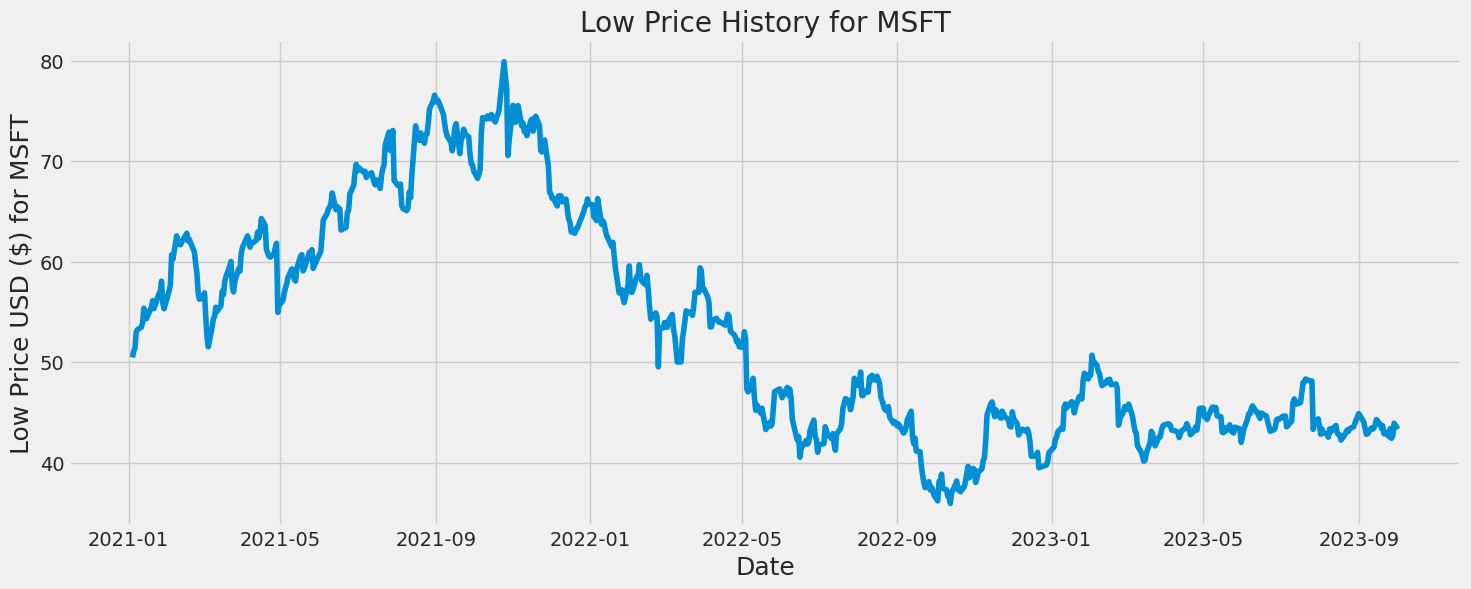

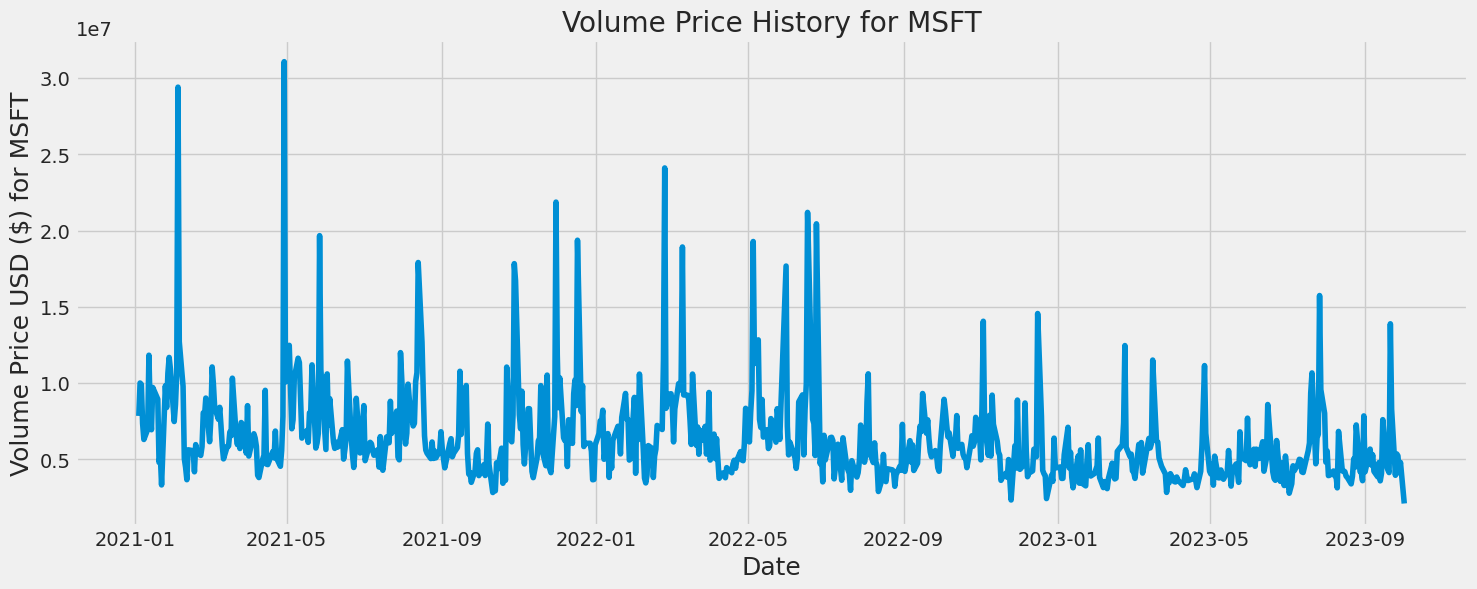

In [ ]:
def plot_close_val(data_frame, column, stock):
    plt.figure(figsize=(16,6))
    plt.title(column + ' Price History for ' + stock )
    plt.plot(data_frame[column])
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(column + ' Price USD ($) for ' + stock, fontsize=18)
    plt.show()

#Test the function
plot_close_val(df, 'Close', 'MSFT')
plot_close_val(df, 'Open',  'MSFT')
plot_close_val(df, 'High',  'MSFT')
plot_close_val(df, 'Low',  'MSFT')
plot_close_val(df, 'Volume',  'MSFT')

In [ ]:
def build_training_dataset(input_ds):
    # Create a new dataframe with only the 'Close column
    input_ds.reset_index()
    data = input_ds.drop(["Adj Close"],axis=1)
    # Convert the dataframe to a numpy array
    dataset = data.values
    # Get the number of rows to train the model on
    training_data_len = int(np.ceil( len(dataset) * .95 ))
    return data, dataset, training_data_len

#Test the function
training_data_df, training_dataset_np, training_data_len = build_training_dataset(df)
dataset=training_dataset_np
data=training_data_df


print(training_dataset_np.shape)

print(training_data_df)

(691, 5)
                 Open       High        Low      Close    Volume
Date                                                            
2021-01-04  50.480000  51.900002  50.450001  51.500000   7843500
2021-01-05  51.349998  52.279999  51.060001  52.029999  10002400
2021-01-06  51.500000  54.290001  51.400002  53.220001   9911400
2021-01-07  53.419998  54.230000  53.009998  53.060001   7348800
2021-01-08  53.369999  54.549999  53.230000  54.480000   6298300
...               ...        ...        ...        ...       ...
2023-09-26  43.549999  44.240002  43.389999  43.490002   5353400
2023-09-27  43.560001  43.759998  42.410000  42.889999   5225600
2023-09-28  42.730000  43.889999  42.720001  43.650002   4114900
2023-09-29  44.090000  44.599998  43.910000  44.090000   4792900
2023-10-02  43.910000  44.040001  43.310001  43.355000   2098864

[691 rows x 5 columns]


In [ ]:
# Scale the data

from sklearn.preprocessing import MinMaxScaler
def scale_the_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    closing_price_scaling_params = scaler.data_range_[3], scaler.data_min_[3]
    return scaler, scaled_data, closing_price_scaling_params

#Test the function
scaler, scaled_data, closing_price_scaling_params = scale_the_data(training_dataset_np)

def inverse_transform_closing_price(scaled_price):
    return scaled_price * closing_price_scaling_params[0] + closing_price_scaling_params[1]

final = inverse_transform_closing_price(scaled_data[:,3])


In [ ]:
scaled_data

array([[0.31881143, 0.33356086, 0.33037748, 0.33554135, 0.19820616],
       [0.33824841, 0.34220698, 0.34424743, 0.34764731, 0.2726943 ],
       [0.34159965, 0.38794082, 0.35197822, 0.37482873, 0.26955454],
       ...,
       [0.14566578, 0.15130825, 0.15461579, 0.15623575, 0.06955893],
       [0.17605006, 0.16746295, 0.18167351, 0.16628597, 0.09295185],
       [0.17202861, 0.15472125, 0.16803098, 0.14949746, 0.        ]])

In [ ]:
# Create the scaled training data set
def split_train_dataset(training_data_len):
    train_data = scaled_data[0:int(training_data_len), :]
    # Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, :])
        y_train.append(train_data[i, 3])


    # Convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],5))

    print(x_train.shape)
    # x_train.shape
    return x_train, y_train

#Test the function
x_train,y_train = split_train_dataset(training_data_len)

(597, 60, 5)


In [ ]:
def build_lstm_model(x_train,y_train):
    # Build the LSTM model
    # model = Sequential()
    # model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], x_train.shape[2])))
    # model.add(LSTM(64, return_sequences=True))
    # model1 = Sequential()
    # model1.add(GRU(128, return_sequences=True,input_shape= (x_train.shape[1], x_train.shape[2])))
    # model1.add(GRU(64, return_sequences=True))

    # combined_output = Concatenate(axis=-1)([model.output, model1.output])

    # final_output = Dense(1, activation='sigmoid')(combined_output)

    # input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]))

    # model = Model(inputs=input_layer, outputs=final_output)

    input_shape = (x_train.shape[1], x_train.shape[2])
    output_shape = (1,1)

    # Create a single input layer
    input_layer = Input(shape=input_shape)

    # Create separate branches for LSTM and GRU using the shared input layer
    lstm_branch = LSTM(128, return_sequences=True)(input_layer)
    lstm_branch = LSTM(64, return_sequences=False)(lstm_branch)

    gru_branch = GRU(128, return_sequences=True)(input_layer)  # GRU branch uses the same input layer
    gru_branch = GRU(64, return_sequences=False)(gru_branch)

    # Combine the outputs of both branches
    combined_output = Concatenate(axis=-1)([lstm_branch, gru_branch])

    # Create another model for the final prediction
    final_output = Dense(1, activation='linear')(combined_output)

    print(final_output)

    # Create the final model by specifying the inputs and outputs
    model = Model(inputs=input_layer, outputs=final_output)


    # model.add(Dense(25,activation='sigmoid'))
    # model.add(Dense(1,activation='sigmoid'))


    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=15)
    return model

#Test the function
lstm_model = build_lstm_model(x_train,y_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/BiasAdd:0', description="created by layer 'dense'")
Epoch 1/15
597/597 [==============================] - 50s 64ms/step - loss: 0.0033
Epoch 2/15
597/597 [==============================] - 37s 63ms/step - loss: 0.0016
Epoch 3/15
597/597 [==============================] - 39s 66ms/step - loss: 0.0015
Epoch 4/15
597/597 [==============================] - 37s 62ms/step - loss: 0.0013
Epoch 5/15
597/597 [==============================] - 38s 63ms/step - loss: 0.0015
Epoch 6/15
597/597 [==============================] - 38s 63ms/step - loss: 0.0015
Epoch 7/15
597/597 [==============================] - 39s 66ms/step - loss: 0.0011
Epoch 8/15
597/597 [==============================] - 38s 64ms/step - loss: 0.0013
Epoch 9/15
597/597 [==============================] - 38s 63ms/step - loss: 0.0011
Epoch 10/15
597/597 [==============================] - 38s 63ms/step - loss: 0.0012
Epoch 11/15
597/597 [====

In [ ]:


pre = lstm_model.predict(x_train[0:60])

print(pre.shape)

2/2 [==============================] - 2s 47ms/step
(60, 1)


In [ ]:
def build_lstm_model(x_train,y_train):
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25,activation='sigmoid'))
    model.add(Dense(1,activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=15)
    return model

#Test the function
lstm_model = build_lstm_model(x_train,y_train)

Epoch 1/15
591/591 [==============================] - 25s 37ms/step - loss: 0.0134
Epoch 2/15
591/591 [==============================] - 22s 38ms/step - loss: 0.0039
Epoch 3/15
591/591 [==============================] - 23s 38ms/step - loss: 0.0026
Epoch 4/15
591/591 [==============================] - 22s 37ms/step - loss: 0.0020
Epoch 5/15
591/591 [==============================] - 25s 42ms/step - loss: 0.0019
Epoch 6/15
591/591 [==============================] - 23s 39ms/step - loss: 0.0017
Epoch 7/15
591/591 [==============================] - 22s 38ms/step - loss: 0.0016
Epoch 8/15
591/591 [==============================] - 23s 39ms/step - loss: 0.0014
Epoch 9/15
591/591 [==============================] - 22s 37ms/step - loss: 0.0013
Epoch 10/15
591/591 [==============================] - 22s 38ms/step - loss: 0.0014
Epoch 11/15
591/591 [==============================] - 22s 38ms/step - loss: 0.0013
Epoch 12/15
591/591 [==============================] - 23s 38ms/step - loss: 0.0012
E

In [ ]:
def build_gru_model(x_train,y_train):
    # Build the LSTM model
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape= (x_train.shape[1], x_train.shape[2])))
    model.add(GRU(64, return_sequences=False))
    model.add(Dense(25,activation='sigmoid'))
    model.add(Dense(1,activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=15)
    return model

#Test the function
gru_model = build_gru_model(x_train,y_train)

Epoch 1/15
591/591 [==============================] - 25s 35ms/step - loss: 0.0089
Epoch 2/15
591/591 [==============================] - 20s 34ms/step - loss: 0.0026
Epoch 3/15
591/591 [==============================] - 19s 33ms/step - loss: 0.0022
Epoch 4/15
591/591 [==============================] - 21s 35ms/step - loss: 0.0020
Epoch 5/15
591/591 [==============================] - 20s 33ms/step - loss: 0.0016
Epoch 6/15
591/591 [==============================] - 19s 33ms/step - loss: 0.0015
Epoch 7/15
591/591 [==============================] - 20s 34ms/step - loss: 0.0014
Epoch 8/15
591/591 [==============================] - 19s 32ms/step - loss: 0.0017
Epoch 9/15
591/591 [==============================] - 20s 35ms/step - loss: 0.0014
Epoch 10/15
591/591 [==============================] - 19s 32ms/step - loss: 0.0013
Epoch 11/15
591/591 [==============================] - 21s 35ms/step - loss: 0.0013
Epoch 12/15
591/591 [==============================] - 20s 33ms/step - loss: 0.0013
E

In [ ]:
def inverse_transform_closing_price(scaled_price):
    return scaled_price * closing_price_scaling_params[0] + closing_price_scaling_params[1]

def create_testing_data_set(model1, scaler, training_data_len,test_data_len):
    # Create the testing data set
    # Create a new array containing scaled values from index 571 to 631
    test_data = scaled_data[training_data_len - test_data_len: , :]

    # Create the data sets x_test and y_test
    x_test = []
    check = []
    y_test = dataset[training_data_len:, 3]

    sample = []
    # iterate from 60 to 93

    for i in range(test_data_len, len(test_data)):
        x_test.append(test_data[i-test_data_len:i, :])
        check.append(inverse_transform_closing_price(test_data[i-1, 3]))
#         sample = inverse_transform_closing_price(test_data[i-test_data_len:i, 3])
#         print(sample)


    # Convert the data to a numpy array
    x_test = np.array(x_test)

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2] ))

    #print(x_test[17])


    # Get the models predicted price values
    predictions1 = model1.predict(x_test)
    #print(predictions)
    predictions1 = inverse_transform_closing_price(predictions1)

    # predictions2 = model2.predict(x_test)
    # #print(predictions)
    # predictions2 = inverse_transform_closing_price(predictions2)

    # predictions = (predictions1 + predictions2) / 2



    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions1 - y_test) ** 2)))
    rmse
    return (x_test, y_test, predictions1, rmse, check)

#Test the function
TEST_DATA_LENGTH = 60
x_test,y_test, predictions, rmse, check = create_testing_data_set(lstm_model,scaler,training_data_len, TEST_DATA_LENGTH)
rmse

2/2 [==============================] - 0s 35ms/step


1.241156450974075

In [ ]:
test_loss = lstm_model.evaluate(x_test, y_test)
print(test_loss)
eval_test_loss = round(100-(test_loss*100),1)

print(eval_test_loss)

2/2 [==============================] - 2s 29ms/step - loss: 1903.4930
1903.4930419921875
-190249.3


In [ ]:
print(x_test.shape[1])
print(x_test.shape[2])
print(x_test.shape)

60
5
(34, 60, 5)


In [ ]:
predictions.shape

(34, 1)

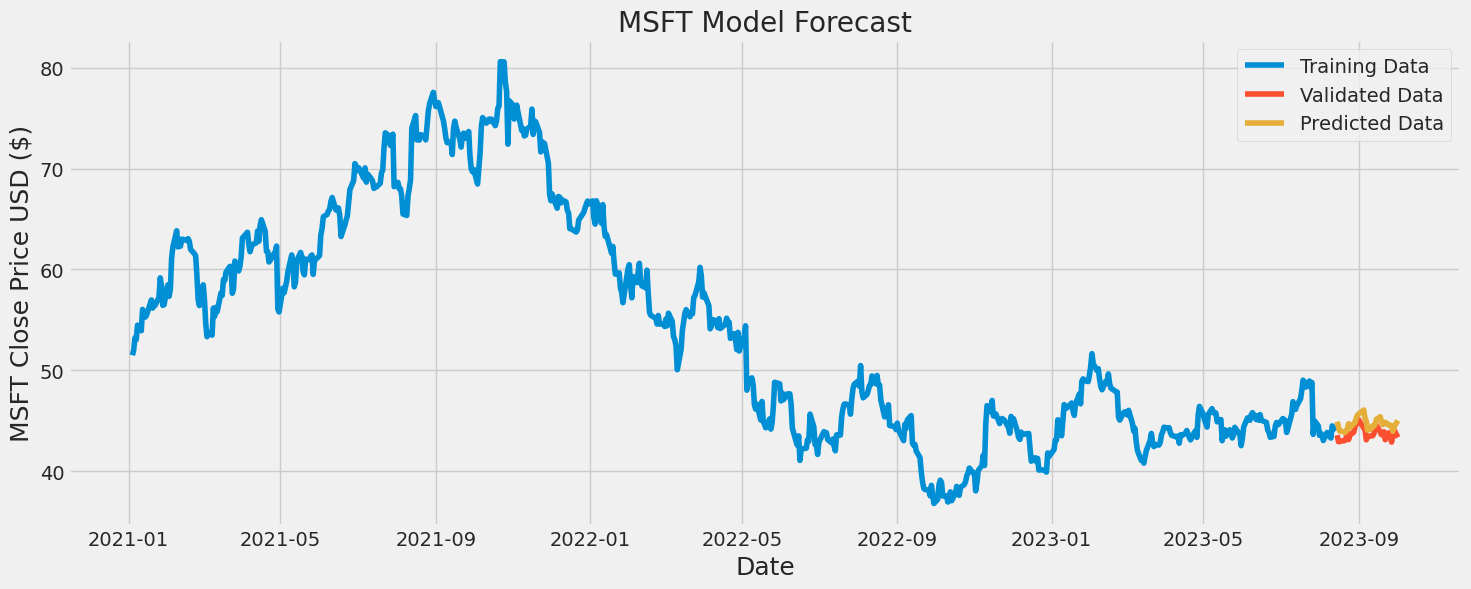

In [ ]:
def plot_predictions(stock, data,training_data_len):
    #Plot the data
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    # Visualize the data
    plt.figure(figsize=(16,6))
    title = stock + ' Model Forecast'
    ylabel = stock + ' Close Price USD ($)'
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Training Data', 'Validated Data', 'Predicted Data'], loc='upper right')
    plt.show()
    return valid

#Test the function
valid = plot_predictions('MSFT',data,training_data_len)

In [ ]:
valid

Open       High        Low      Close    Volume  Predictions
Date                                                                         
2023-08-07  43.330002  43.919998  42.860001  43.849998   4230800    43.282234
2023-08-08  43.279999  43.580002  42.520000  43.520000   3910600    43.589191
2023-08-09  43.709999  44.000000  43.340000  43.669998   3942700    43.275463
2023-08-10  44.160000  44.259998  43.049999  43.290001   3126100    43.758797
2023-08-11  43.360001  44.590000  43.340000  44.500000   6826900    43.625748
2023-08-14  44.209999  44.349998  43.689999  44.029999   4229900    44.249062
2023-08-15  43.619999  43.680000  42.939999  43.580002   4240500    44.104965
2023-08-16  43.470001  43.500000  42.790001  42.930000   4181800    43.583023
2023-08-17  43.310001  43.389999  42.750000  42.950001   3892000    43.294701
2023-08-18  42.580002  43.279999  42.230000  42.990002   3801000    43.255997
2023-08-21  42.990002  43.259998  42.759998  43.040001   3385900    43.055988
2023-08-22  43.090000  43.560001  43.040001  43.270000   3875300    43.220470
2023-08-23  43.279999  44.200001  43.250000  43.900002   5024600    43.422649
2023-08-24  43.869999  44.240002  43.110001  43.139999   4477100    43.901371
2023-08-25  43.730000  44.349998  43.380001  43.590000   7250700    43.579372
2023-08-28  43.889999  44.049999  43.549999  43.869999   4203100    43.892654
2023-08-29  44.009998  44.700001  43.919998  44.320000   4135100    43.989773
2023-08-30  44.320000  44.869999  44.259998  44.750000   3595300    44.489922
2023-08-31  44.599998  45.340000  44.549999  44.779999   7844400    44.775887
2023-09-01  45.209999  45.540001  44.869999  45.099998   4176400    44.924381
2023-09-05  44.880001  44.880001  44.040001  44.290001   5668100    45.307587
2023-09-06  44.169998  44.320000  43.430000  44.119999   4617300    44.430511
2023-09-07  43.639999  43.709999  42.810001  43.119999   5296000    44.125046
2023-09-08  42.919998  43.480000  42.840000  43.430000   4208600    43.390915
2023-09-11  43.700001  43.939999  43.430000  43.509998   3848800    43.437981
2023-09-12  43.400002  43.980000  43.320000  43.509998   4788300    43.746319
2023-09-13  43.689999  43.970001  43.430000  43.709999   3583700    43.664043
2023-09-14  43.970001  44.459999  43.720001  44.360001   4078400    43.831161
2023-09-15  44.459999  44.799999  44.270000  44.560001   7598200    44.317024
2023-09-18  44.340000  44.459999  43.810001  43.910000   4580500    44.591827
2023-09-19  43.630001  44.090000  43.419998  43.619999   4308500    44.133522
2023-09-20  43.740002  44.540001  43.669998  43.689999   4127600    43.843369
2023-09-21  43.380001  45.209999  42.849998  43.919998  13887000    44.077637
2023-09-22  44.230000  44.840000  43.000000  43.130001   8215045    43.955730

In [ ]:
true_values = valid['Close']  # Replace with your actual true values
predicted_values = valid['Predictions']  # Replace with your LSTM's predicted values

approximate_losses = [(predicted - true) / true for predicted, true in zip(predicted_values, true_values)]

# Convert to percentage
approximate_losses_percentage = [loss * 100 for loss in approximate_losses]

# Calculate the overall approximate loss (average of all approximate losses)
overall_approximate_loss = sum(approximate_losses_percentage) / len(approximate_losses_percentage)

print(f"Overall Approximate Loss = {overall_approximate_loss:.2f}%")


Overall Approximate Loss = -3.00%


In [ ]:
BASE_URL = 'https://paper-api.alpaca.markets'
API_KEY = 'PKVC4SDGFZ79WZKMUJOM'
SECRET_KEY = 'gbHwAw2fGS5K2PHGF6lBHAjtm00oPO5cgj757dj9'
ORDERS_URL = '{}/v2/orders'.format(BASE_URL)
HEADERS = {'APCA-API-KEY-ID':API_KEY,'APCA-API-SECRET-KEY':SECRET_KEY}

In [ ]:
p = valid['Predictions']
print(p[0])
print(p[1])


43.180492
42.818016


In [ ]:
from alpaca.trading.client import TradingClient
from alpaca.trading.enums import OrderSide, TimeInForce, OrderType, OrderClass
from alpaca.trading.requests import MarketOrderRequest, TakeProfitRequest, StopLossRequest
from alpaca.trading.stream import TradingStream
import alpaca_trade_api as tradeapi

In [ ]:
client = TradingClient(API_KEY, SECRET_KEY, paper=True)
account = dict(client.get_account())
for k,v in account.items():
    print(f"{k:30}{v}")

id                            7c0a4254-5a85-47c8-81ee-e44c96696062
account_number                PA31ARUDIPR1
status                        ACTIVE
crypto_status                 ACTIVE
currency                      USD
buying_power                  200230.46
regt_buying_power             200230.46
daytrading_buying_power       0
non_marginable_buying_power   100115.23
cash                          100115.23
accrued_fees                  0
pending_transfer_out          None
pending_transfer_in           0
portfolio_value               100115.23
pattern_day_trader            False
trading_blocked               False
transfers_blocked             False
account_blocked               False
created_at                    2023-09-16 13:38:48.997727+00:00
trade_suspended_by_user       False
multiplier                    2
shorting_enabled              True
equity                        100115.23
last_equity                   100115.23
long_market_value             0
short_market_value           

In [ ]:
def create_order(pred_price,company,test_loss,appro_loss):
    open_price,close_price = pred_price[0],pred_price[1]
    print(round(20*(test_loss/100)))
    print(open_price, close_price)
    print(test_loss-appro_loss)
    take_profit_price = 55
    stop_loss_price = 34


    if open_price > close_price:
        side = 'sell'
    elif open_price < close_price:
        side = 'buy'
    if side == 'buy':
        order_details = MarketOrderRequest(
                            symbol= company,
                            qty = 100,
                            side = OrderSide.BUY,
                            time_in_force = TimeInForce.DAY,
                            order_class = OrderClass.BRACKET,
                            take_profit=TakeProfitRequest(limit_price=50),
                            stop_loss=StopLossRequest(stop_price=40)
                            )
    elif side == 'sell':
        order_details = MarketOrderRequest(
                            symbol= company,
                            qty = 100,
                            side = OrderSide.SELL,
                            time_in_force = TimeInForce.DAY,
                            order_class = OrderClass.BRACKET,
                            take_profit=TakeProfitRequest(limit_price=29),
                            stop_loss=StopLossRequest(stop_price=46)
                            )
    return order_details


order_details = create_order(valid['Predictions'],'EBAY',rmse,overall_approximate_loss)

order = client.submit_order(order_data= order_details)

trades = TradingStream(API_KEY, SECRET_KEY, paper=True)
# async def trade_status(data):
#     print(data)

# trades.subscribe_trade_updates(trade_status)
#trades.run()

0
43.180492 42.818016
4.4589395948854715


In [ ]:
def create_order(pred_price,company,test_loss,appro_loss):
    open_price,close_price = pred_price[0],pred_price[1]
    print(round(20*(test_loss/100)))
    print(open_price, close_price)
    print(test_loss-appro_loss)


    if open_price > close_price:
        side = 'sell'
    elif open_price < close_price:
        side = 'buy'
    if side == 'buy':
        order_details = MarketOrderRequest(
                            symbol= company,
                            qty = 100,
                            side = OrderSide.BUY,

                            time_in_force = TimeInForce.DAY,
                            )
    elif side == 'sell':
        order_details = MarketOrderRequest(
                            symbol= company,
                            qty = 100,
                            side = OrderSide.SELL,
                            time_in_force = TimeInForce.DAY,

                            )
    return order_details


order_details = create_order(valid['Predictions'],'EBAY',rmse,overall_approximate_loss)

order = client.submit_order(order_data= order_details)

trades = TradingStream(API_KEY, SECRET_KEY, paper=True)
# async def trade_status(data):
#     print(data)

# trades.subscribe_trade_updates(trade_status)
#trades.run()

0
44.930702 44.747353
1.4866412729839147


Let us evaluate for all of NASDAQ


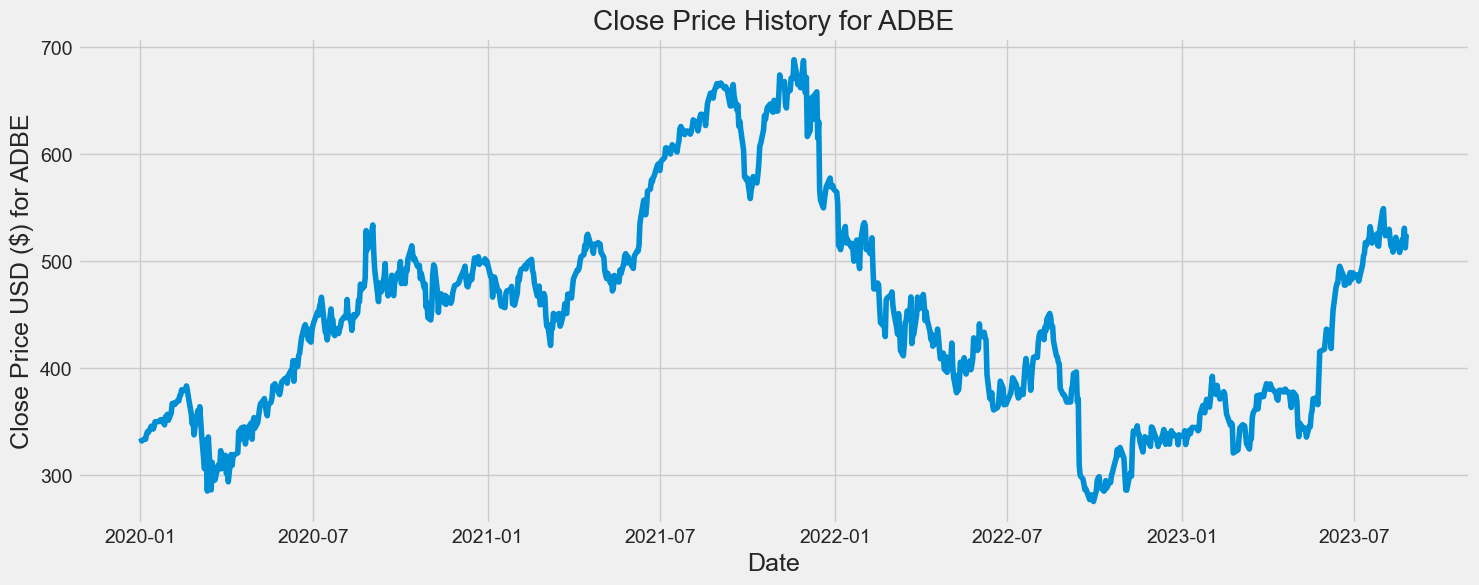

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 20s 22ms/step - loss: 0.0090
Epoch 2/5
814/814 [==============================] - 21s 25ms/step - loss: 0.0029
Epoch 3/5
814/814 [==============================] - 22s 27ms/step - loss: 0.0018
Epoch 4/5
814/814 [==============================] - 32s 39ms/step - loss: 0.0015
Epoch 5/5
2/2 [==============================] - 2s 35ms/step
[[470.65143]
 [468.6606 ]
 [474.50214]
 [480.95605]
 [477.67963]
 [480.0824 ]
 [482.2141 ]
 [484.67938]
 [483.29175]
 [478.67197]
 [483.16632]
 [491.79138]
 [504.31427]
 [511.06897]
 [518.40564]
 [521.85913]
 [521.0403 ]
 [526.7114 ]
 [534.2478 ]
 [522.5108 ]
 [511.5144 ]
 [529.47034]
 [528.3997 ]
 [514.7772 ]
 [515.80396]
 [522.29065]
 [543.76843]
 [551.99426]
 [533.0454 ]
 [523.7077 ]
 [527.4644 ]
 [532.1366 ]
 [520.83673]
 [515.79175]
 [517.9453 ]
 [509.96844]
 [514.9562 ]
 [519.8514 ]
 [518.36285]
 [515.273  ]
 [506.5056 ]
 [516.2917 ]
 [527.5173 ]
 [530.00085]
 [523.12396]]


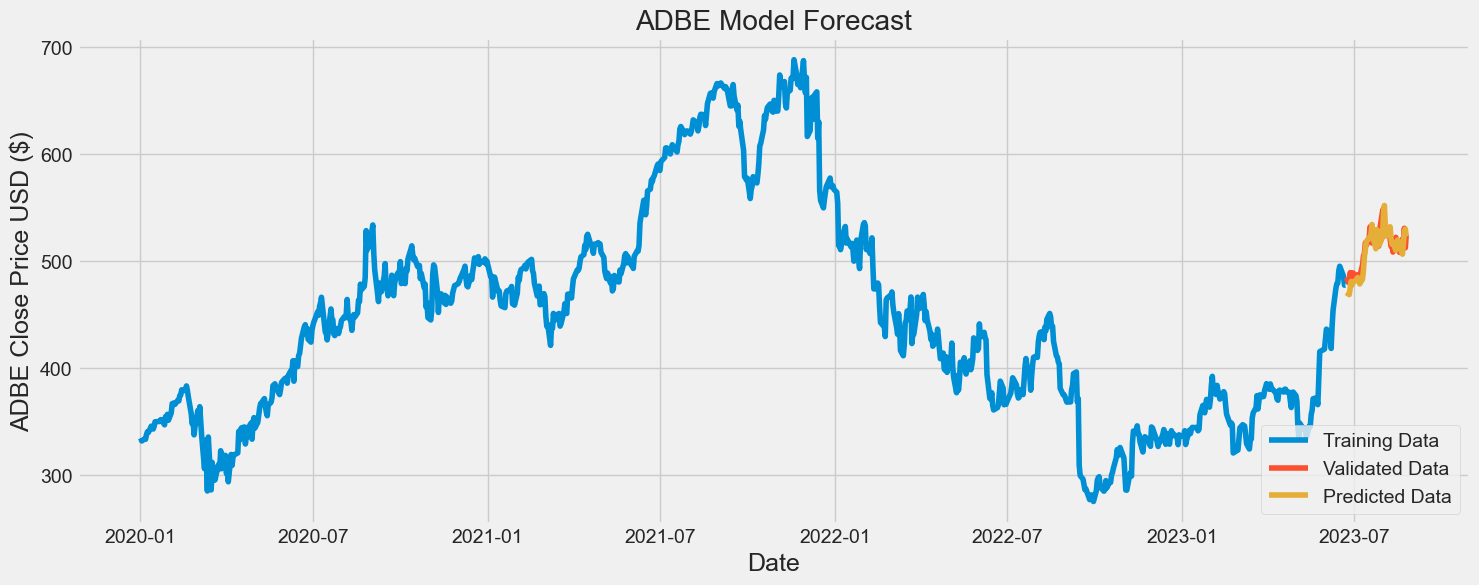

Test RMSE: 9.825


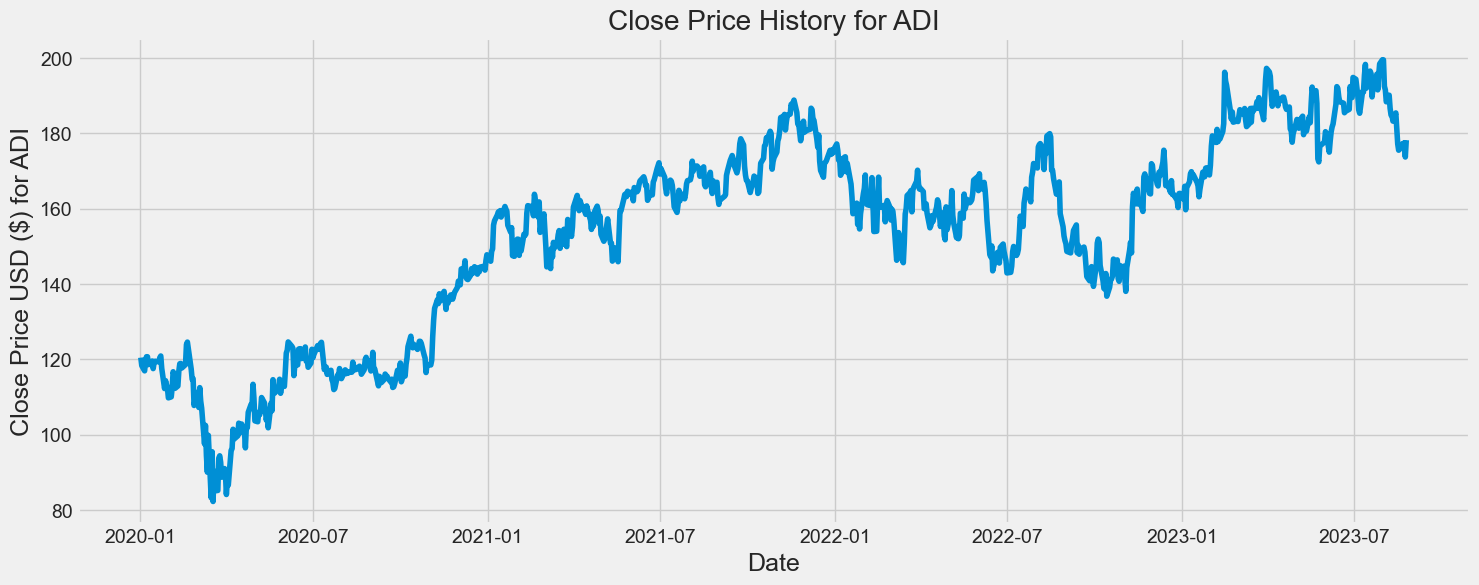

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 45s 46ms/step - loss: 0.0085
Epoch 2/5
814/814 [==============================] - 45s 55ms/step - loss: 0.0025
Epoch 3/5
814/814 [==============================] - 37s 46ms/step - loss: 0.0020
Epoch 4/5
814/814 [==============================] - 33s 40ms/step - loss: 0.0017
Epoch 5/5
2/2 [==============================] - 2s 40ms/step
[[186.97473]
 [186.96417]
 [187.78314]
 [187.91556]
 [188.0255 ]
 [188.05792]
 [188.98274]
 [189.15323]
 [188.52618]
 [187.79181]
 [188.05707]
 [188.31828]
 [188.5268 ]
 [189.25189]
 [189.83438]
 [189.31583]
 [189.69922]
 [189.89926]
 [189.99323]
 [189.02402]
 [189.64679]
 [189.64465]
 [189.73404]
 [189.11508]
 [190.05087]
 [190.21167]
 [190.42258]
 [190.41283]
 [189.98254]
 [189.67082]
 [188.98311]
 [189.38206]
 [187.93549]
 [188.12097]
 [187.84352]
 [186.73224]
 [187.2201 ]
 [186.01044]
 [184.47531]
 [184.05325]
 [182.54109]
 [182.87051]
 [182.89001]
 [180.84827]
 [182.13412]]


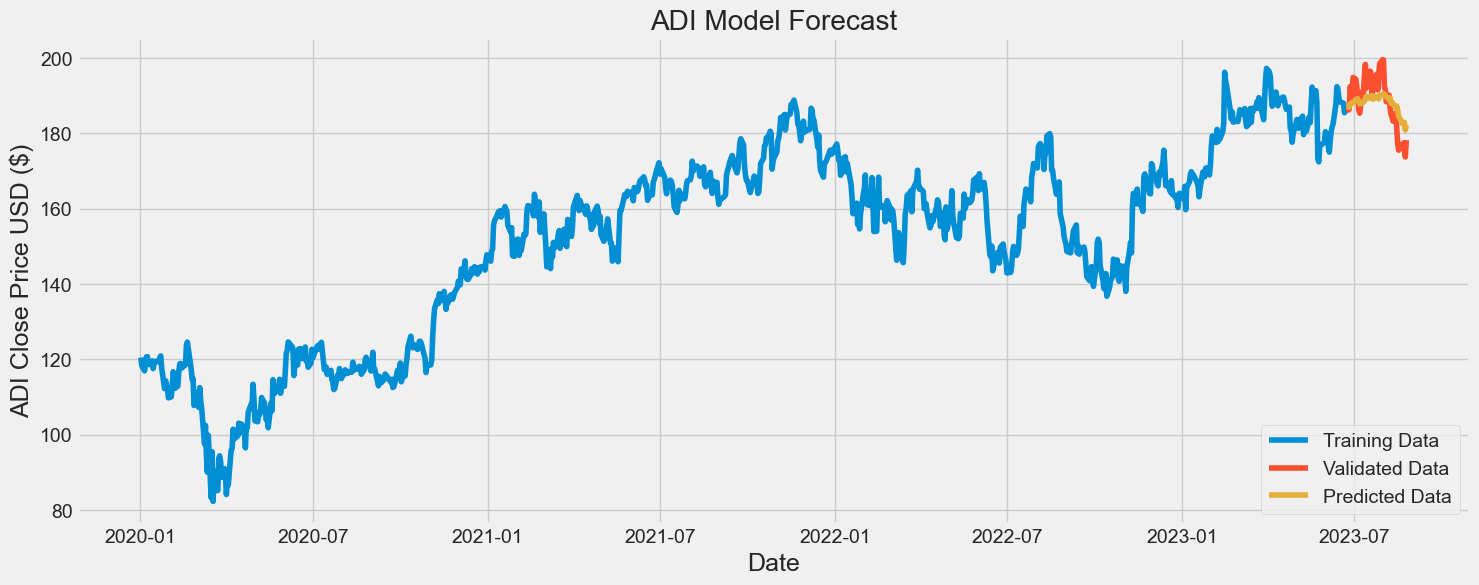

Test RMSE: 5.200


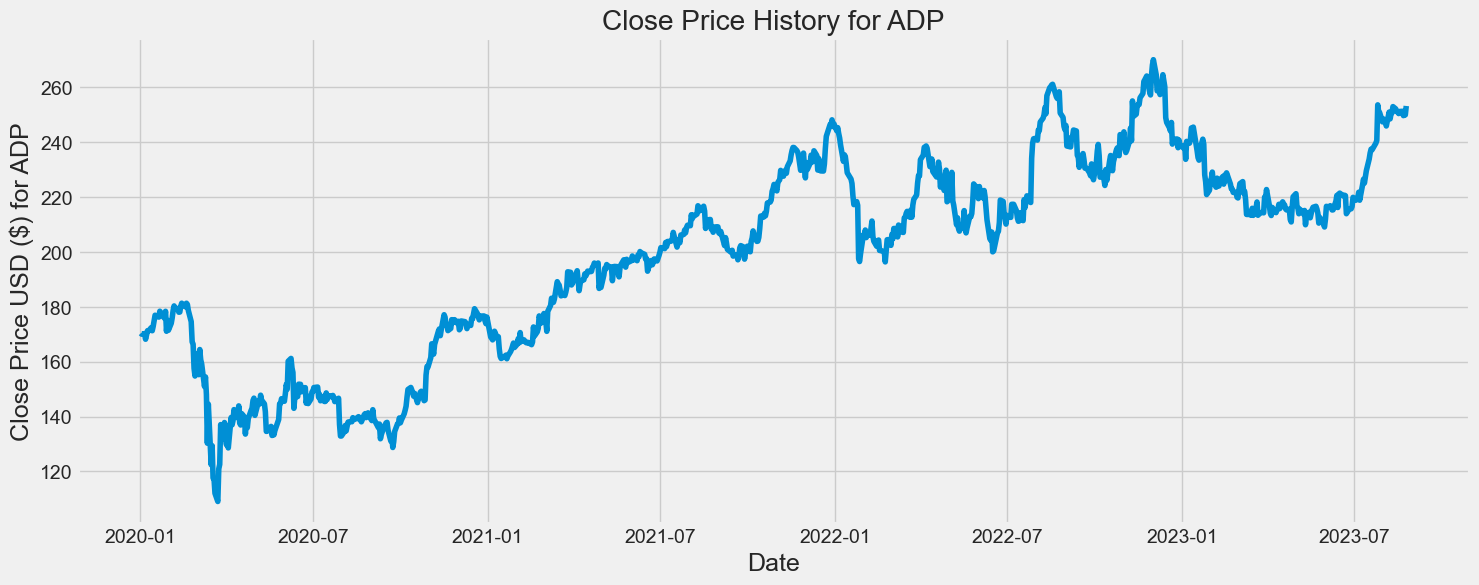

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 37s 38ms/step - loss: 0.0129
Epoch 2/5
814/814 [==============================] - 35s 43ms/step - loss: 0.0030
Epoch 3/5
814/814 [==============================] - 45s 55ms/step - loss: 0.0018
Epoch 4/5
814/814 [==============================] - 37s 46ms/step - loss: 0.0015
Epoch 5/5
2/2 [==============================] - 3s 60ms/step
[[222.34949]
 [219.75375]
 [216.73456]
 [214.4534 ]
 [213.1538 ]
 [213.43909]
 [215.13669]
 [217.20178]
 [218.60257]
 [219.37186]
 [219.81569]
 [220.78152]
 [222.89575]
 [225.14081]
 [226.56226]
 [227.59378]
 [228.84564]
 [231.05643]
 [233.57907]
 [235.61107]
 [236.41818]
 [237.909  ]
 [238.79791]
 [240.94446]
 [244.13226]
 [246.60025]
 [247.11365]
 [246.31262]
 [244.52945]
 [243.11258]
 [242.1614 ]
 [242.09985]
 [242.60464]
 [243.3541 ]
 [244.39755]
 [245.3895 ]
 [246.17688]
 [246.43051]
 [246.36755]
 [246.19101]
 [245.7745 ]
 [245.7352 ]
 [245.64697]
 [245.42096]
 [245.2572 ]]


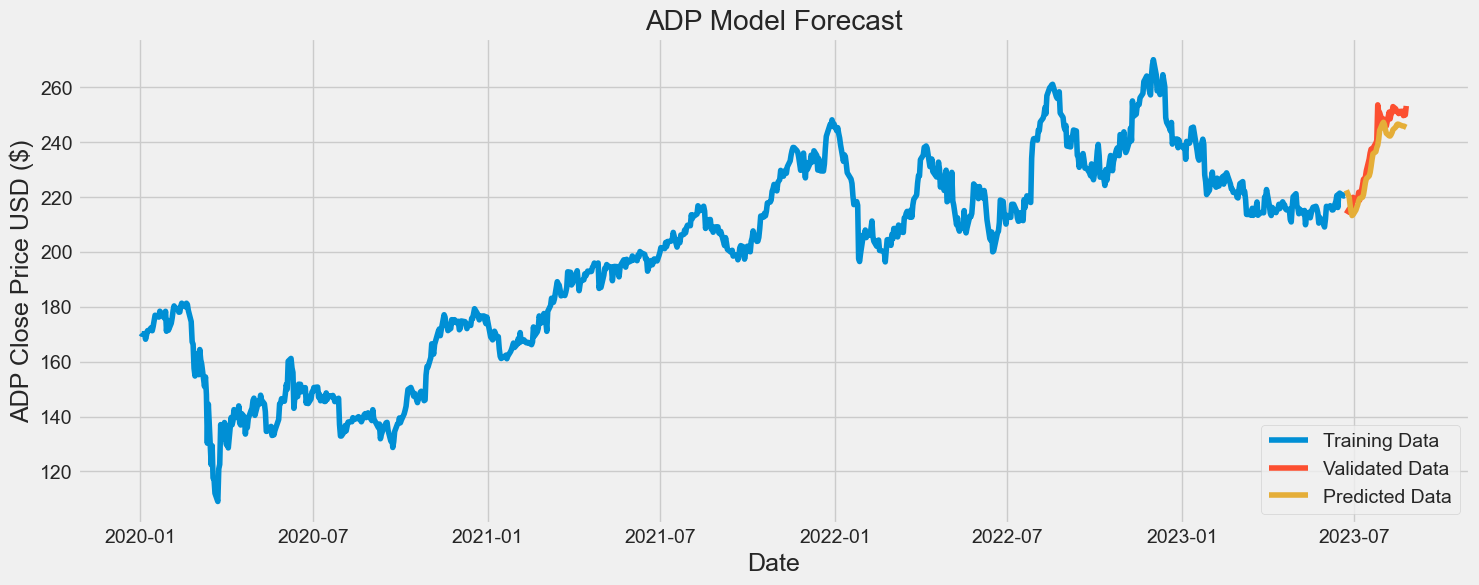

Test RMSE: 5.476


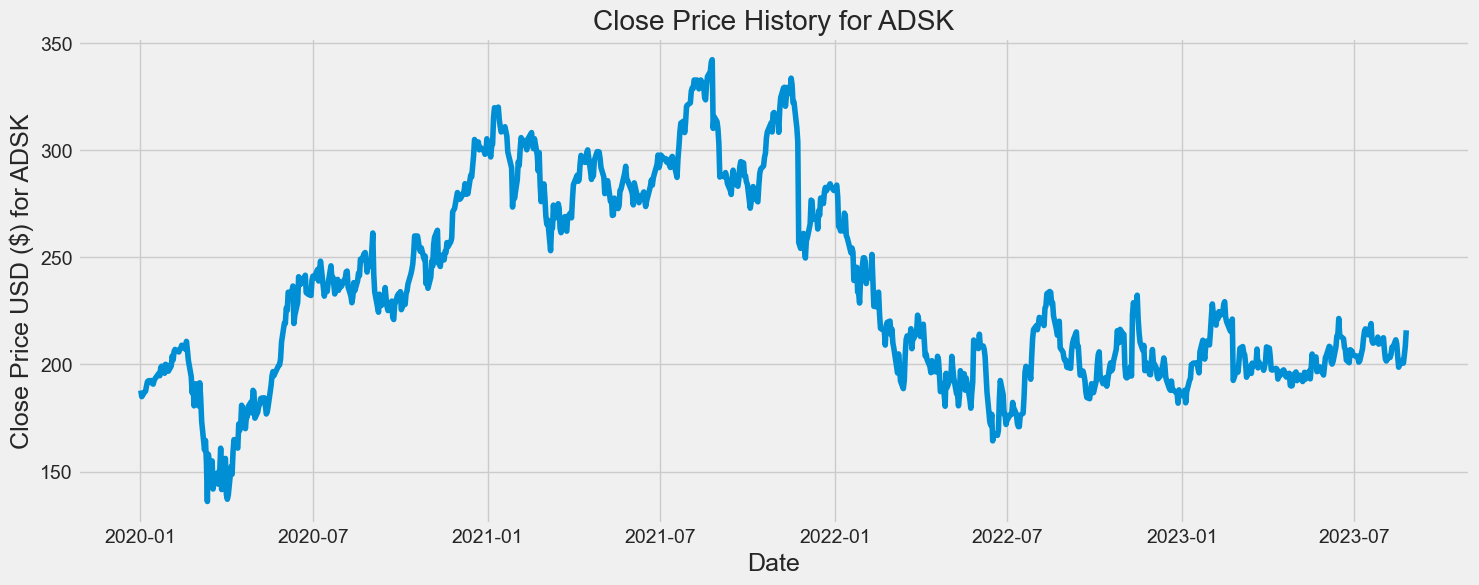

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 45s 46ms/step - loss: 0.0141
Epoch 2/5
814/814 [==============================] - 43s 53ms/step - loss: 0.0033
Epoch 3/5
814/814 [==============================] - 39s 48ms/step - loss: 0.0020
Epoch 4/5
814/814 [==============================] - 35s 43ms/step - loss: 0.0017
Epoch 5/5
2/2 [==============================] - 2s 58ms/step
[[203.12955]
 [199.11092]
 [199.28888]
 [201.52446]
 [202.55788]
 [203.11499]
 [200.10622]
 [200.02338]
 [198.10107]
 [196.3004 ]
 [198.87825]
 [201.50024]
 [206.72775]
 [212.11372]
 [213.09895]
 [208.98074]
 [210.1491 ]
 [211.38646]
 [216.33463]
 [209.87189]
 [206.0307 ]
 [209.18338]
 [209.1307 ]
 [208.11914]
 [208.73038]
 [206.79224]
 [206.89719]
 [207.36456]
 [201.71791]
 [199.60663]
 [199.26671]
 [199.92389]
 [198.22118]
 [201.08339]
 [204.70882]
 [203.40846]
 [206.48509]
 [205.36711]
 [201.8334 ]
 [197.64108]
 [196.59077]
 [199.59781]
 [198.66   ]
 [201.18494]
 [208.49759]]


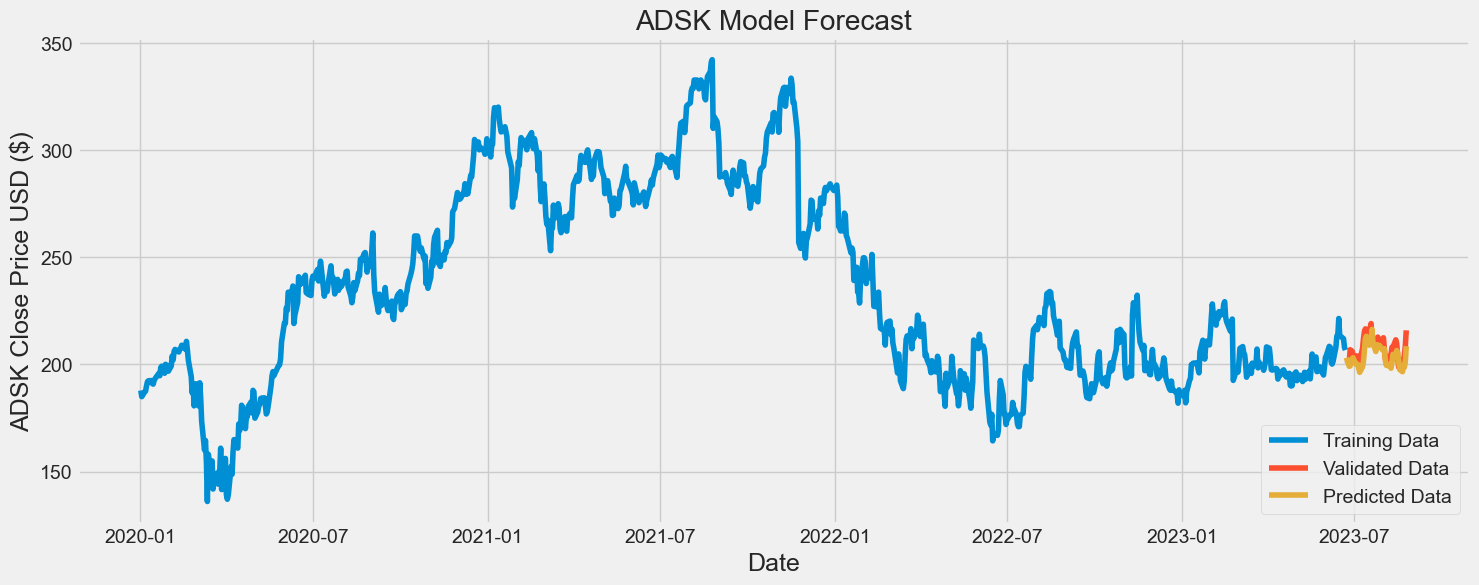

Test RMSE: 4.945


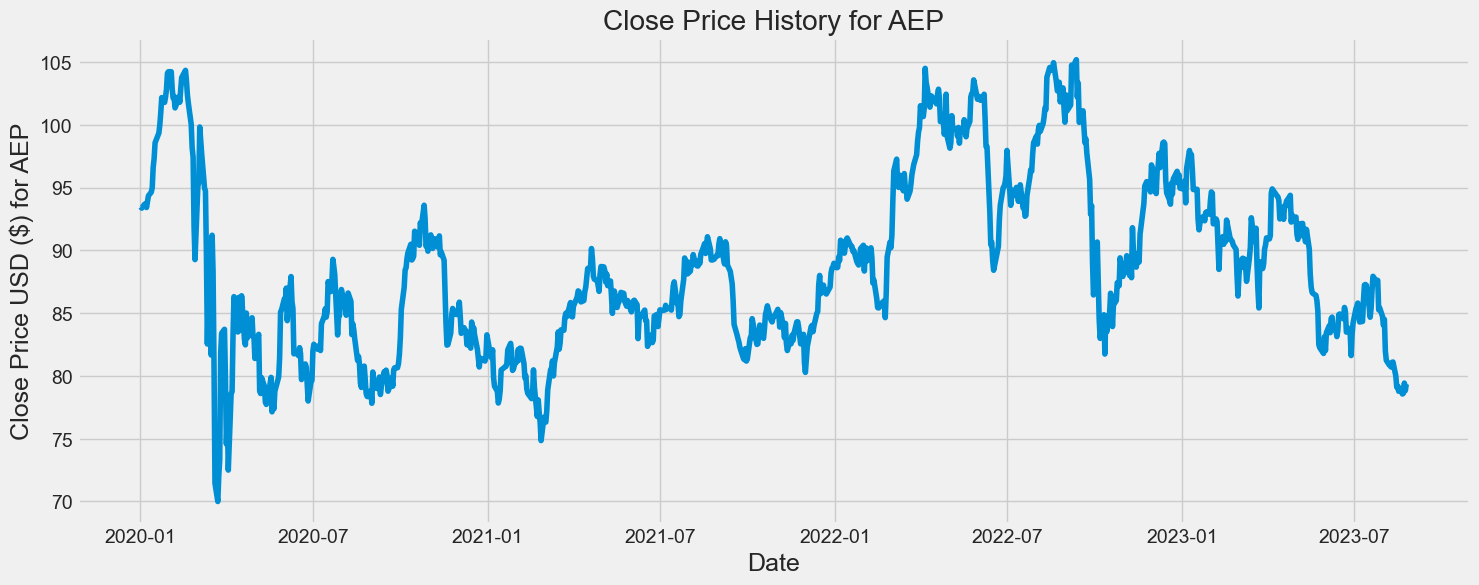

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 48s 50ms/step - loss: 0.0295
Epoch 2/5
814/814 [==============================] - 42s 52ms/step - loss: 0.0045
Epoch 3/5
814/814 [==============================] - 42s 52ms/step - loss: 0.0028
Epoch 4/5
814/814 [==============================] - 40s 49ms/step - loss: 0.0024
Epoch 5/5
2/2 [==============================] - 2s 66ms/step
[[85.37267 ]
 [84.3185  ]
 [83.93592 ]
 [83.705215]
 [82.535484]
 [82.4753  ]
 [83.64828 ]
 [84.51416 ]
 [85.37994 ]
 [85.05914 ]
 [84.77069 ]
 [84.37652 ]
 [85.4538  ]
 [86.77537 ]
 [87.192635]
 [87.127686]
 [86.014496]
 [85.226814]
 [85.424866]
 [86.305725]
 [87.14249 ]
 [87.92955 ]
 [87.678375]
 [88.007256]
 [85.660416]
 [85.87235 ]
 [84.698456]
 [84.521416]
 [84.27754 ]
 [83.199326]
 [82.28881 ]
 [81.70207 ]
 [81.009186]
 [80.67267 ]
 [80.89422 ]
 [80.79433 ]
 [80.410095]
 [79.78545 ]
 [79.75932 ]
 [79.56596 ]
 [79.302956]
 [79.12654 ]
 [78.990974]
 [79.154854]
 [79.23856 ]]


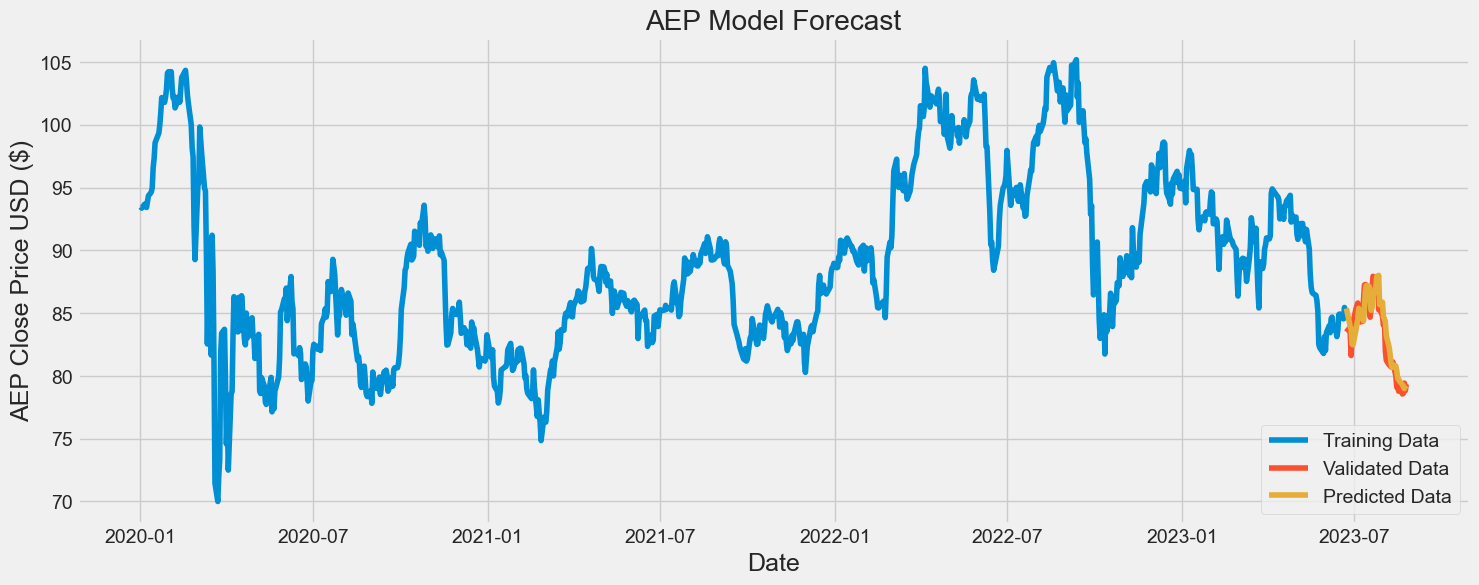

Test RMSE: 1.148


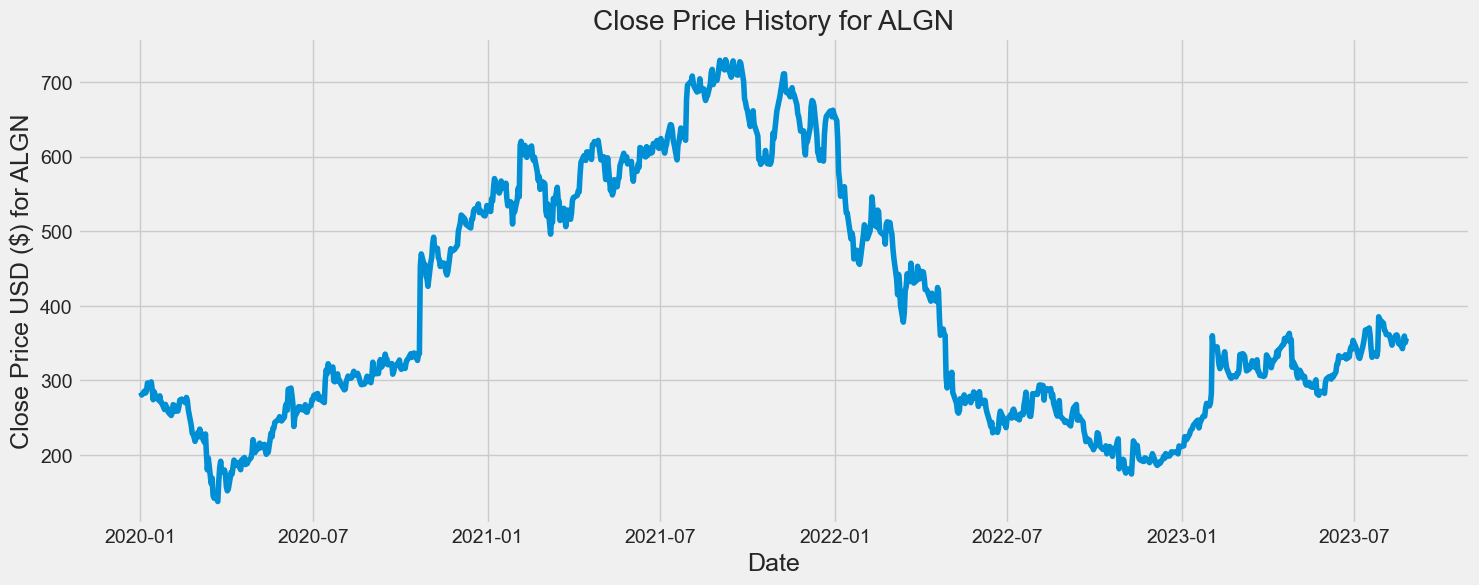

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 50s 52ms/step - loss: 0.0264
Epoch 2/5
814/814 [==============================] - 39s 48ms/step - loss: 0.0042
Epoch 3/5
814/814 [==============================] - 39s 48ms/step - loss: 0.0026
Epoch 4/5
814/814 [==============================] - 38s 47ms/step - loss: 0.0020
Epoch 5/5
2/2 [==============================] - 2s 57ms/step
[[328.22723]
 [328.5039 ]
 [327.55164]
 [329.258  ]
 [334.30362]
 [339.3952 ]
 [345.70898]
 [347.80435]
 [344.3768 ]
 [336.97446]
 [331.07452]
 [330.02295]
 [334.57056]
 [343.85452]
 [354.8952 ]
 [364.70203]
 [369.7399 ]
 [368.12634]
 [360.02112]
 [346.88513]
 [336.81686]
 [329.85306]
 [326.24414]
 [325.10016]
 [351.6147 ]
 [370.42645]
 [377.2529 ]
 [376.07574]
 [370.1487 ]
 [363.36285]
 [359.3375 ]
 [356.67526]
 [354.006  ]
 [351.8525 ]
 [349.24493]
 [347.12305]
 [348.46033]
 [352.85263]
 [356.7226 ]
 [357.25   ]
 [353.51932]
 [349.04724]
 [346.13965]
 [348.4596 ]
 [353.12854]]


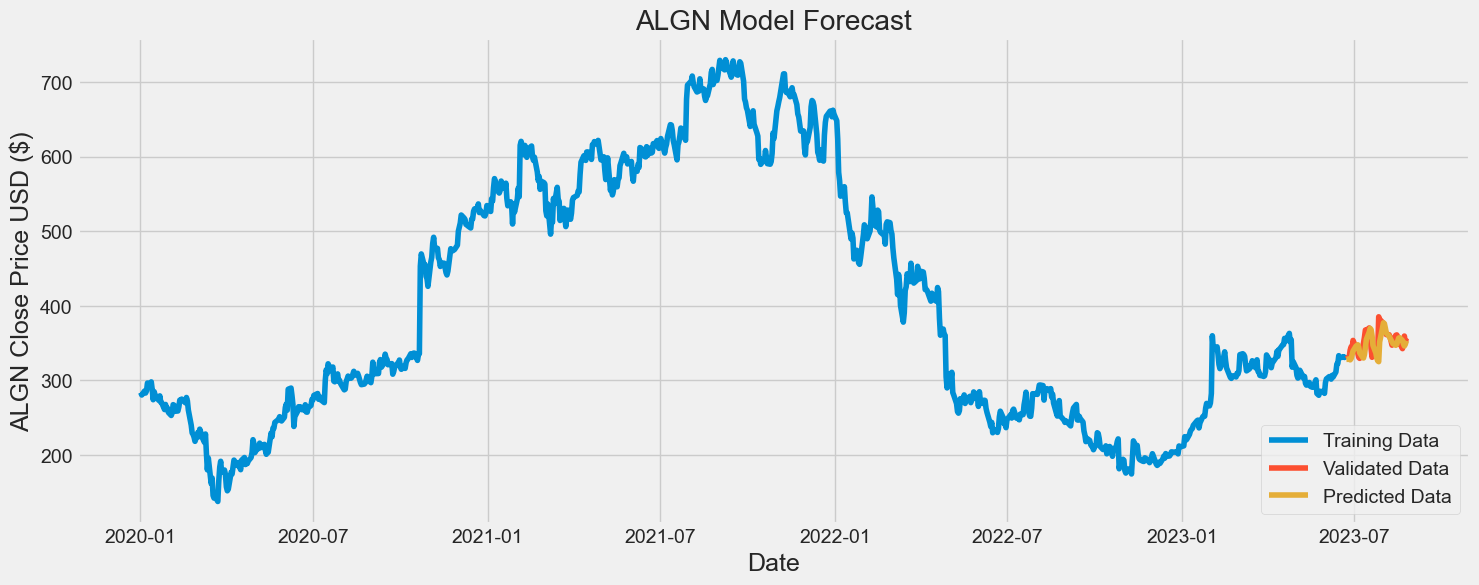

Test RMSE: 15.104


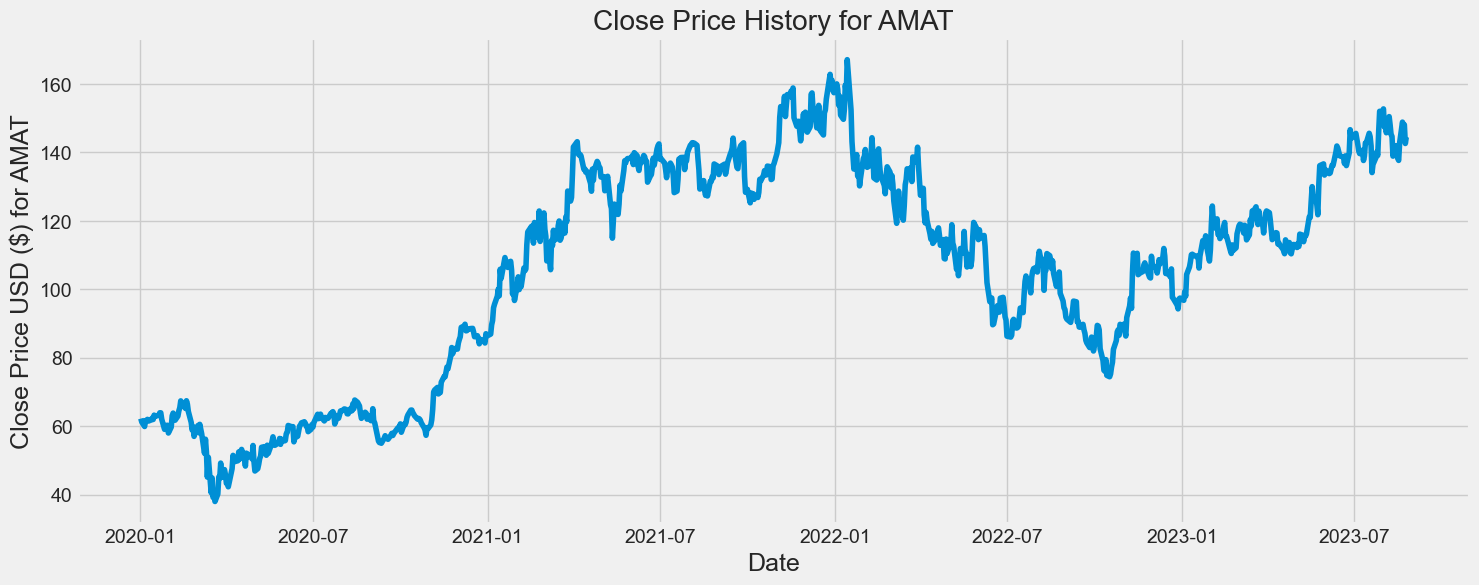

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 49s 49ms/step - loss: 0.0091
Epoch 2/5
814/814 [==============================] - 40s 49ms/step - loss: 0.0024
Epoch 3/5
814/814 [==============================] - 39s 48ms/step - loss: 0.0018
Epoch 4/5
814/814 [==============================] - 39s 48ms/step - loss: 0.0014
Epoch 5/5
2/2 [==============================] - 2s 62ms/step
[[138.43661]
 [137.43288]
 [140.02603]
 [143.70755]
 [142.71445]
 [142.68546]
 [143.09872]
 [143.6098 ]
 [142.3948 ]
 [140.66223]
 [141.16708]
 [141.33488]
 [139.19606]
 [140.2425 ]
 [142.22566]
 [143.01186]
 [143.30692]
 [142.9522 ]
 [142.2564 ]
 [136.52718]
 [138.58008]
 [140.62544]
 [139.9591 ]
 [138.2792 ]
 [144.75636]
 [147.63791]
 [146.82663]
 [146.76881]
 [145.35197]
 [145.3852 ]
 [145.40343]
 [146.83118]
 [145.49274]
 [144.87619]
 [144.62134]
 [140.81158]
 [141.54   ]
 [141.93427]
 [140.37161]
 [139.50931]
 [141.71245]
 [145.99037]
 [145.98593]
 [144.12654]
 [143.58551]]


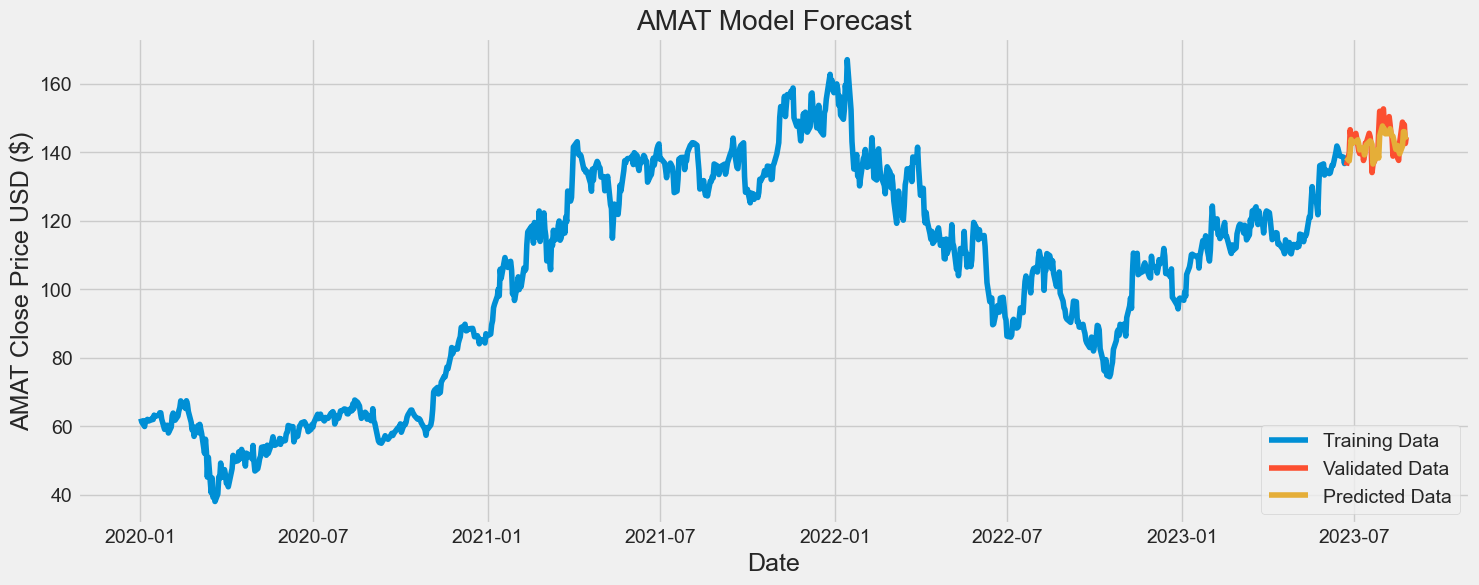

Test RMSE: 3.316


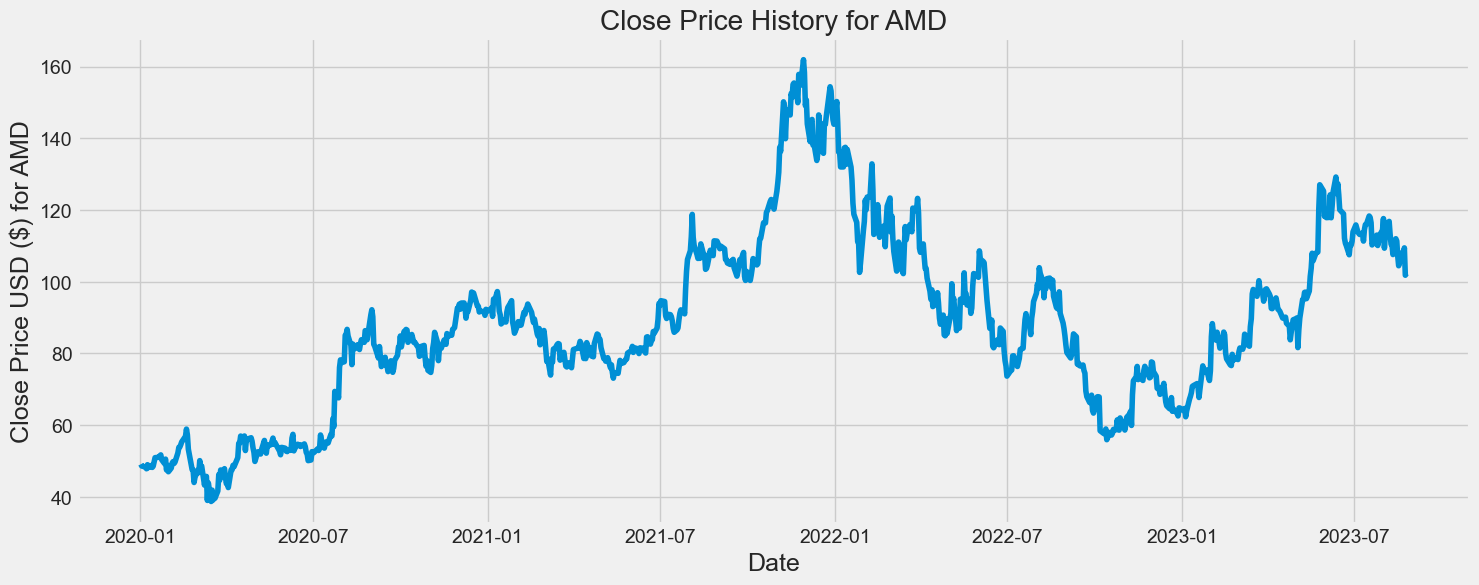

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 46s 46ms/step - loss: 0.0110
Epoch 2/5
814/814 [==============================] - 38s 46ms/step - loss: 0.0026
Epoch 3/5
814/814 [==============================] - 38s 46ms/step - loss: 0.0020
Epoch 4/5
814/814 [==============================] - 38s 47ms/step - loss: 0.0017
Epoch 5/5
2/2 [==============================] - 2s 58ms/step
[[112.64732 ]
 [110.688805]
 [110.33405 ]
 [110.89455 ]
 [111.10582 ]
 [112.46619 ]
 [114.92719 ]
 [117.00129 ]
 [116.76298 ]
 [113.572395]
 [114.91243 ]
 [114.11704 ]
 [112.59191 ]
 [115.1585  ]
 [116.784615]
 [119.01475 ]
 [117.36789 ]
 [118.2058  ]
 [119.61431 ]
 [112.99199 ]
 [111.8073  ]
 [111.42767 ]
 [114.73315 ]
 [112.8236  ]
 [113.62434 ]
 [114.55011 ]
 [115.29066 ]
 [117.67557 ]
 [112.93409 ]
 [110.762856]
 [116.96015 ]
 [118.91635 ]
 [115.25006 ]
 [112.35647 ]
 [112.60089 ]
 [109.188805]
 [110.92651 ]
 [113.151146]
 [109.49491 ]
 [106.02736 ]
 [104.68632 ]
 [108.569954]
 [108.693

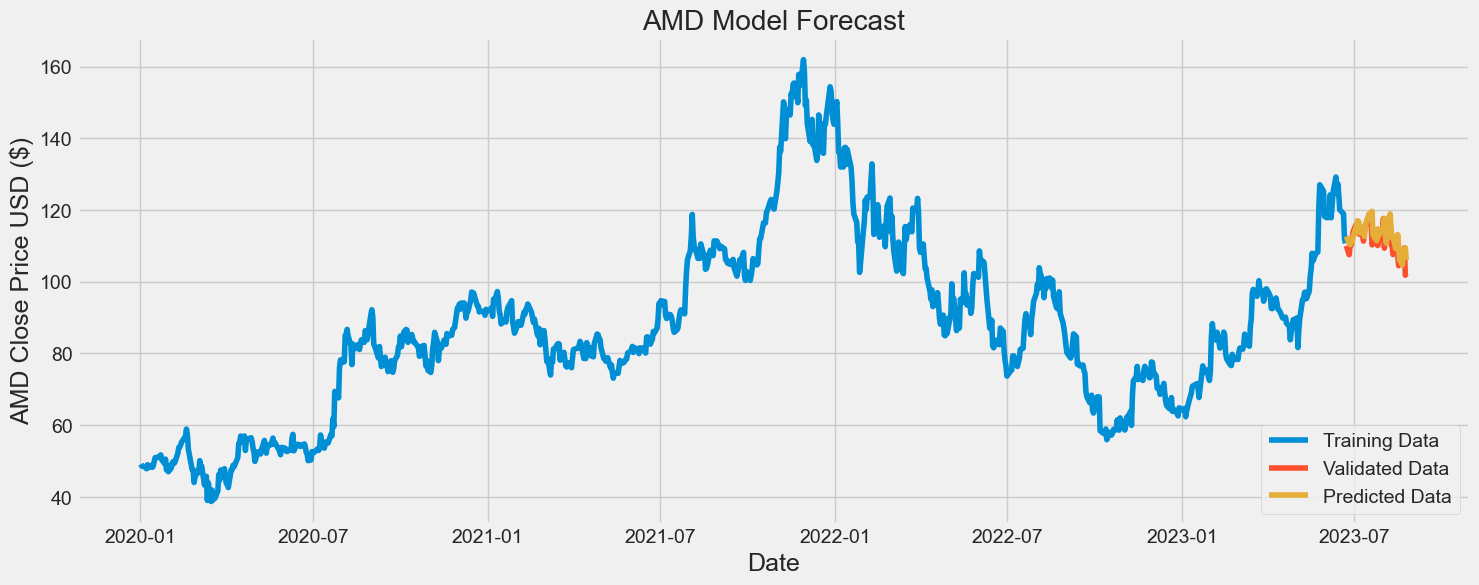

Test RMSE: 3.434


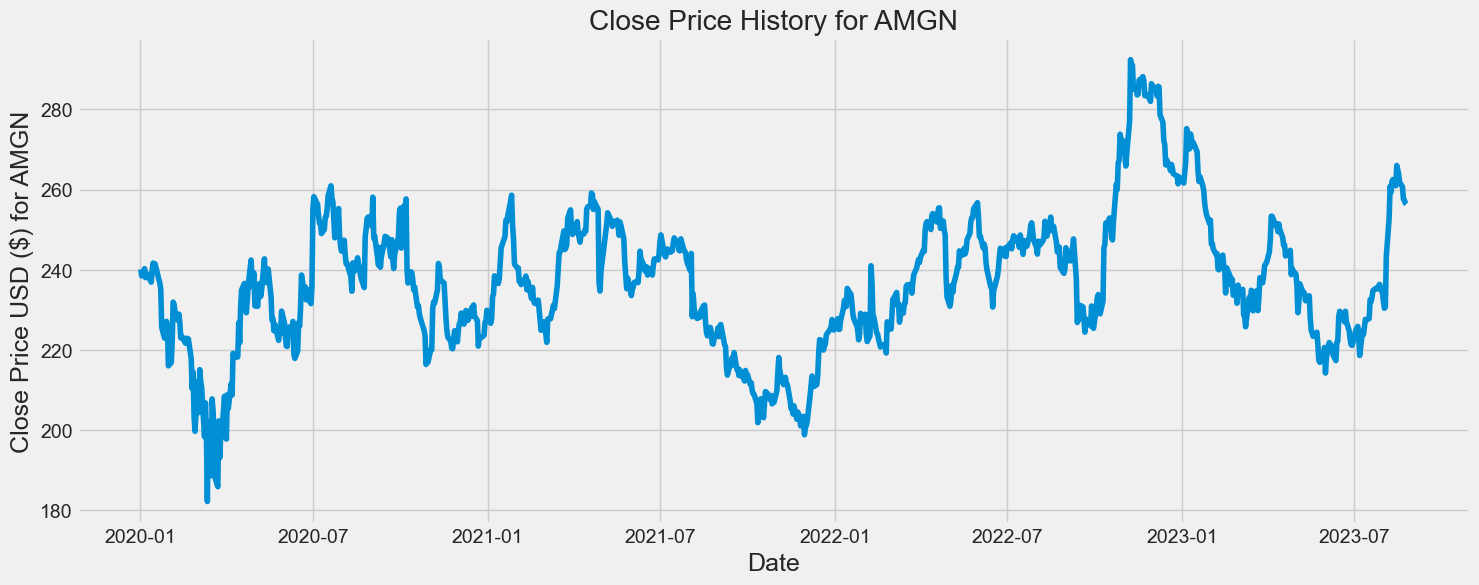

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 46s 46ms/step - loss: 0.0100
Epoch 2/5
814/814 [==============================] - 37s 46ms/step - loss: 0.0030
Epoch 3/5
814/814 [==============================] - 38s 47ms/step - loss: 0.0020
Epoch 4/5
814/814 [==============================] - 38s 46ms/step - loss: 0.0018
Epoch 5/5
2/2 [==============================] - 2s 56ms/step
[[228.7041 ]
 [228.43521]
 [225.30817]
 [223.49527]
 [221.58932]
 [220.71112]
 [221.52078]
 [222.95082]
 [224.68643]
 [223.69792]
 [220.5639 ]
 [222.22922]
 [223.30507]
 [225.01382]
 [226.45236]
 [227.18884]
 [227.16321]
 [231.22867]
 [233.11131]
 [235.52194]
 [235.85333]
 [235.893  ]
 [235.83841]
 [235.181  ]
 [236.89502]
 [237.51479]
 [235.79958]
 [234.04355]
 [231.97829]
 [230.95515]
 [243.16187]
 [251.9575 ]
 [262.21994]
 [261.77536]
 [263.26245]
 [262.6135 ]
 [261.53333]
 [264.1369 ]
 [265.11926]
 [263.65796]
 [261.56818]
 [260.7012 ]
 [258.35876]
 [257.85953]
 [257.27072]]


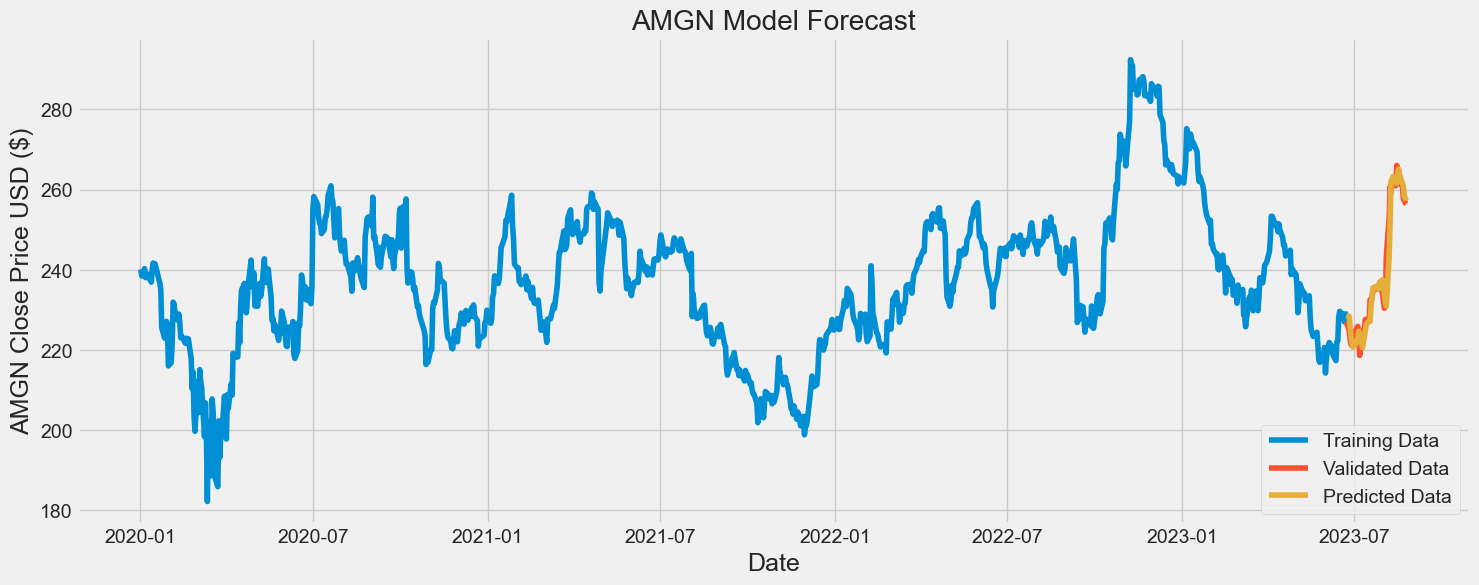

Test RMSE: 3.535


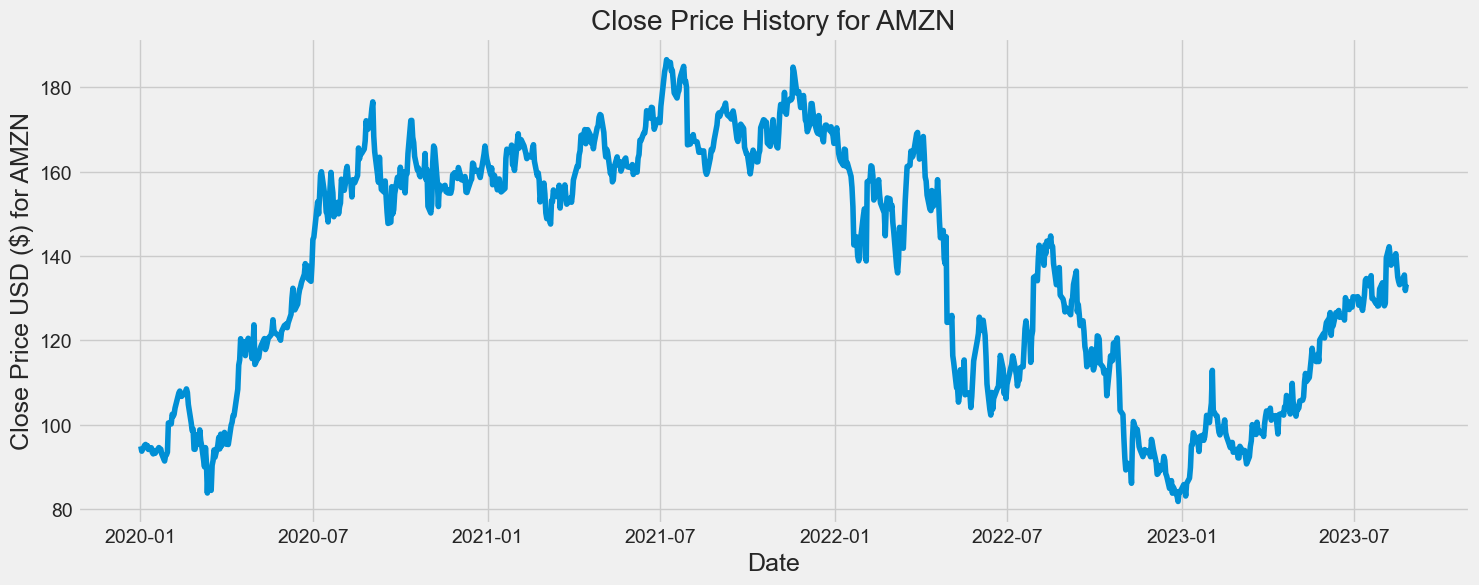

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 49s 50ms/step - loss: 0.0223
Epoch 2/5
814/814 [==============================] - 41s 50ms/step - loss: 0.0035
Epoch 3/5
814/814 [==============================] - 41s 50ms/step - loss: 0.0026
Epoch 4/5
814/814 [==============================] - 38s 47ms/step - loss: 0.0022
Epoch 5/5
2/2 [==============================] - 2s 65ms/step
[[129.53677]
 [131.39883]
 [130.16924]
 [130.20612]
 [130.87617]
 [129.30635]
 [131.64902]
 [132.48453]
 [132.03543]
 [129.23746]
 [130.87456]
 [128.89862]
 [129.9281 ]
 [132.26898]
 [136.99069]
 [137.855  ]
 [136.4015 ]
 [134.23444]
 [136.53467]
 [132.93518]
 [131.26807]
 [130.7464 ]
 [129.91644]
 [128.18378]
 [131.2074 ]
 [133.29935]
 [135.96072]
 [134.69592]
 [129.74385]
 [129.2991 ]
 [146.1787 ]
 [145.63097]
 [142.58432]
 [140.72624]
 [141.15018]
 [140.05948]
 [141.91463]
 [141.17368]
 [137.457  ]
 [136.11942]
 [133.68878]
 [135.94585]
 [136.70627]
 [137.07544]
 [135.96227]]


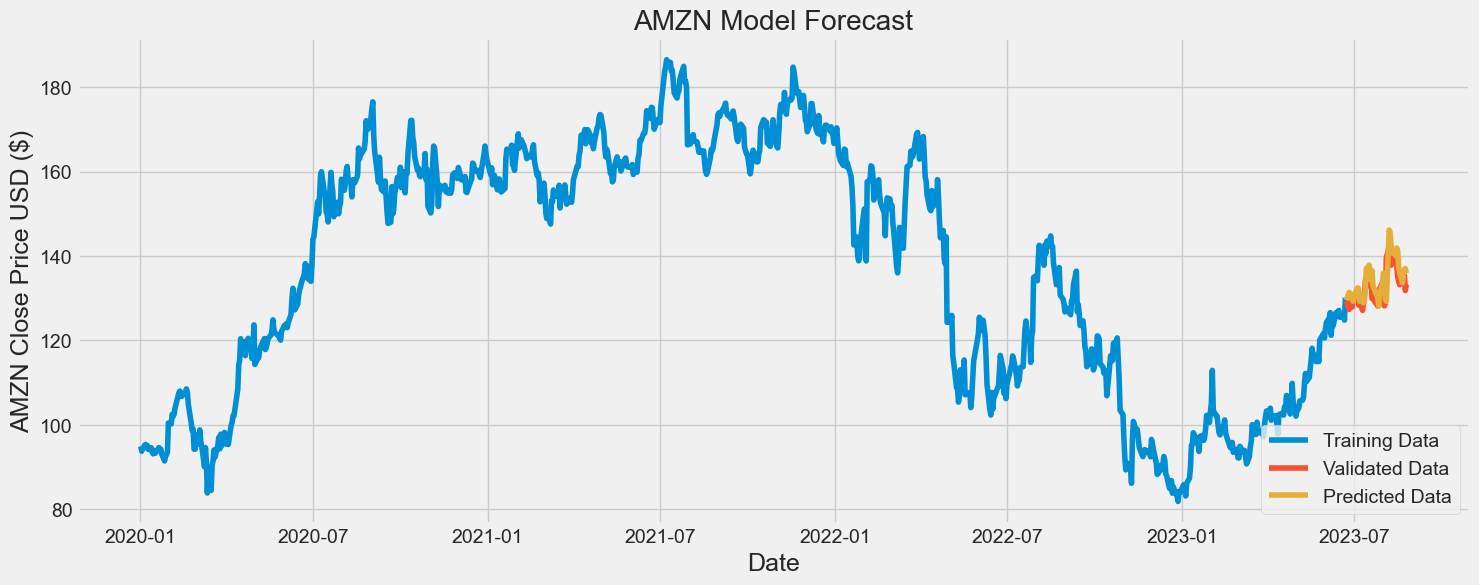

Test RMSE: 3.451


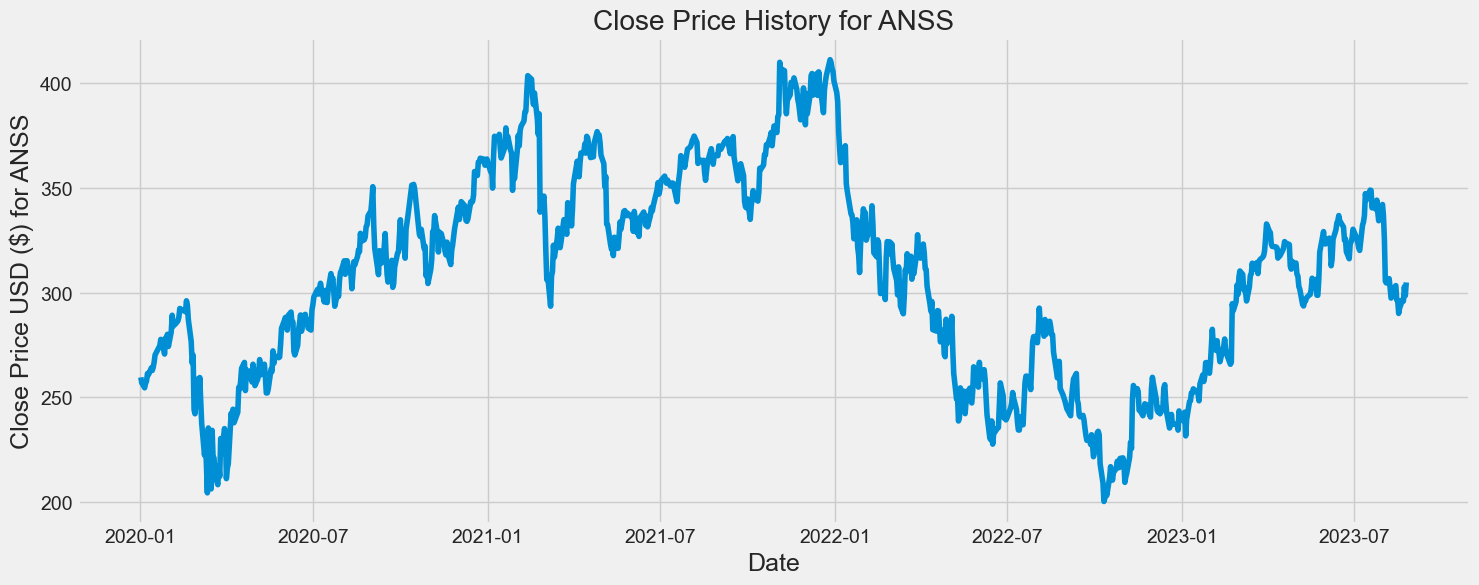

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 47s 49ms/step - loss: 0.0406
Epoch 2/5
814/814 [==============================] - 40s 49ms/step - loss: 0.0050
Epoch 3/5
814/814 [==============================] - 40s 49ms/step - loss: 0.0029
Epoch 4/5
814/814 [==============================] - 39s 48ms/step - loss: 0.0025
Epoch 5/5
2/2 [==============================] - 2s 59ms/step
[[330.507  ]
 [326.56375]
 [324.42798]
 [328.6772 ]
 [332.09238]
 [332.6664 ]
 [338.6375 ]
 [333.08948]
 [329.56577]
 [326.69836]
 [328.44598]
 [336.0076 ]
 [341.3803 ]
 [344.92303]
 [351.83453]
 [352.98224]
 [352.9646 ]
 [354.95532]
 [356.78247]
 [350.59424]
 [349.4185 ]
 [348.80026]
 [349.24103]
 [346.4707 ]
 [345.2757 ]
 [345.8478 ]
 [347.7804 ]
 [342.83905]
 [334.15588]
 [310.59427]
 [310.71548]
 [313.13974]
 [309.89746]
 [306.71255]
 [307.84595]
 [306.75662]
 [309.98065]
 [307.07556]
 [304.16623]
 [300.09415]
 [297.9039 ]
 [303.25098]
 [304.44122]
 [309.03793]
 [309.9809 ]]


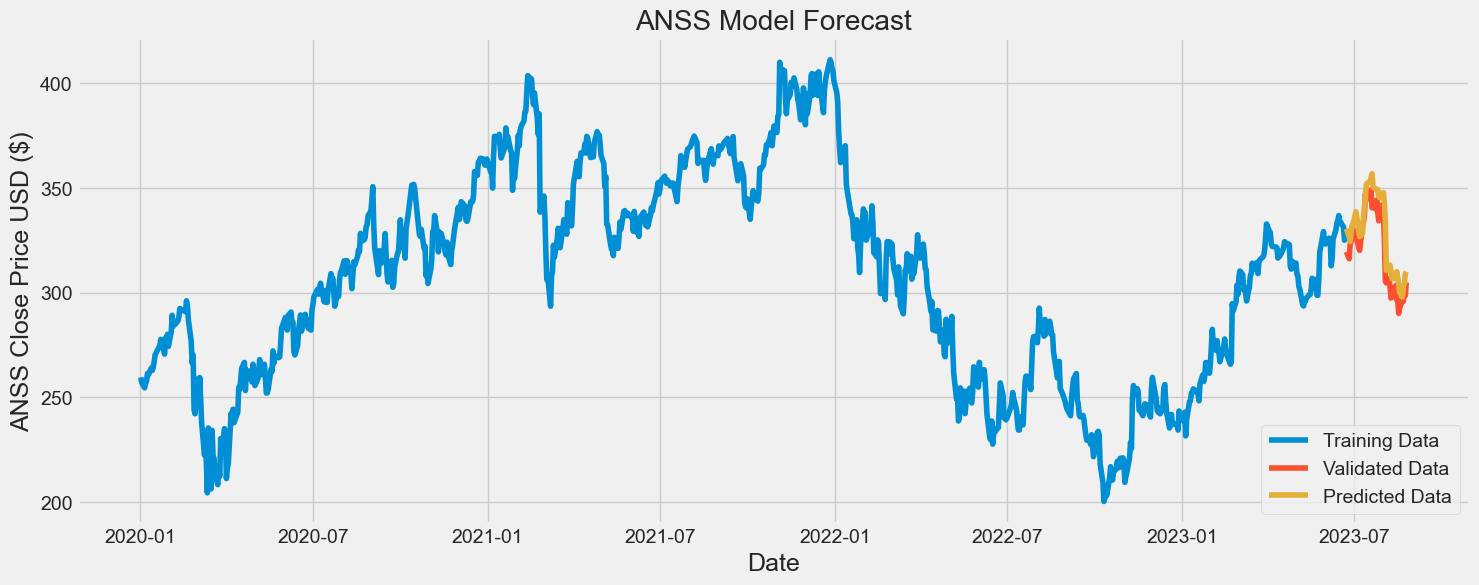

Test RMSE: 9.471


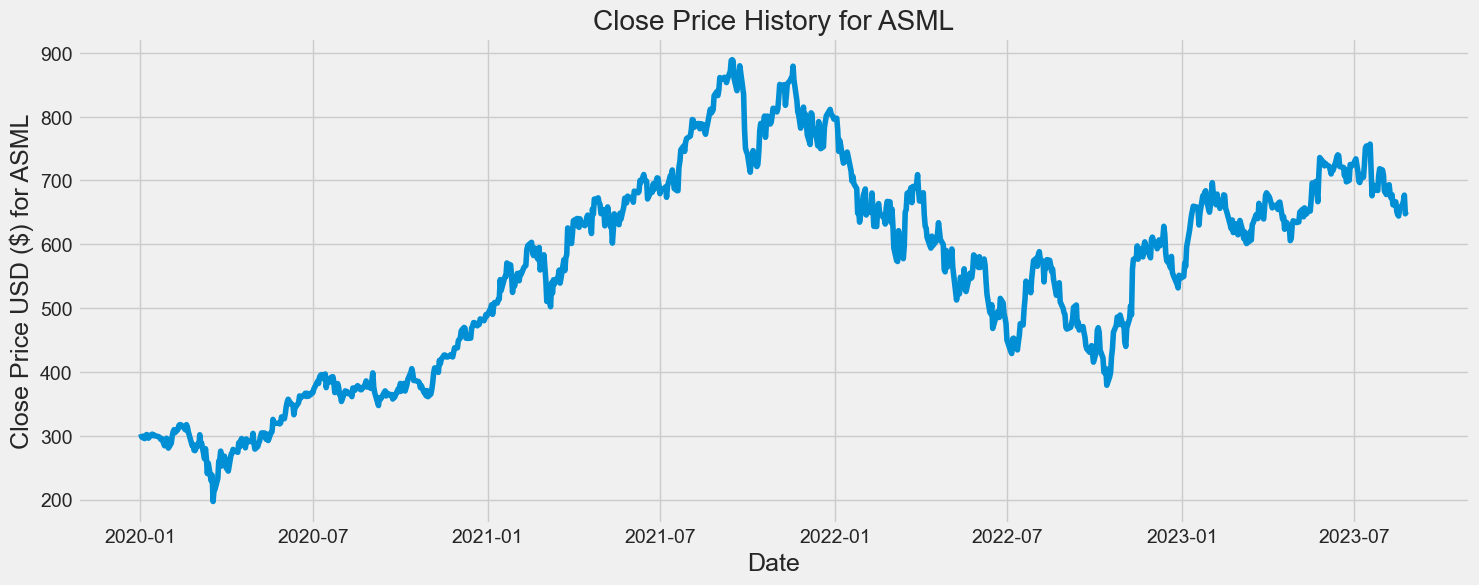

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 50s 51ms/step - loss: 0.0145
Epoch 2/5
814/814 [==============================] - 41s 51ms/step - loss: 0.0027
Epoch 3/5
814/814 [==============================] - 41s 51ms/step - loss: 0.0021
Epoch 4/5
814/814 [==============================] - 40s 50ms/step - loss: 0.0016
Epoch 5/5
2/2 [==============================] - 2s 62ms/step
[[693.5069 ]
 [685.79047]
 [683.7395 ]
 [690.04504]
 [700.15405]
 [707.67236]
 [709.1863 ]
 [712.57837]
 [709.97736]
 [697.00165]
 [684.401  ]
 [683.1023 ]
 [686.0581 ]
 [697.07947]
 [714.5378 ]
 [730.90955]
 [735.0414 ]
 [733.4217 ]
 [721.0216 ]
 [689.77075]
 [666.57904]
 [655.9964 ]
 [655.2232 ]
 [656.19556]
 [670.61005]
 [687.575  ]
 [698.14417]
 [698.11005]
 [685.09766]
 [667.5671 ]
 [659.9136 ]
 [665.0301 ]
 [665.72516]
 [662.7372 ]
 [663.573  ]
 [657.32935]
 [646.49506]
 [637.7731 ]
 [633.32465]
 [631.91675]
 [632.6941 ]
 [637.60345]
 [649.6684 ]
 [658.9868 ]
 [657.3763 ]]


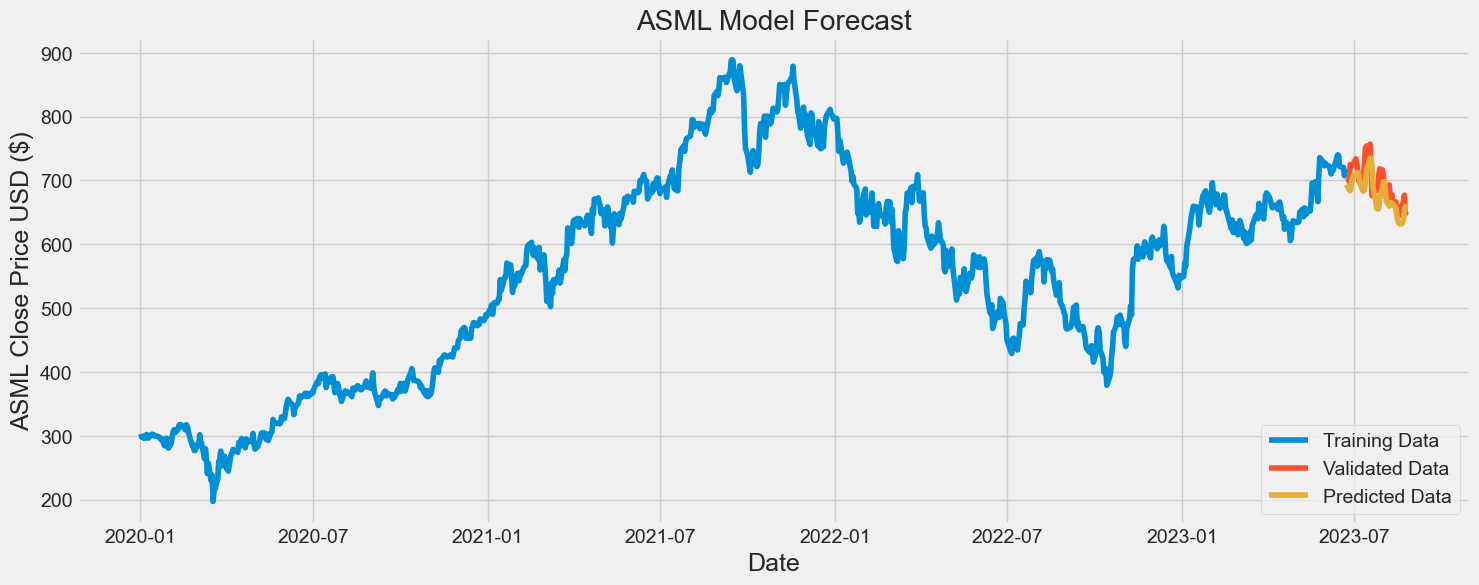

Test RMSE: 25.254


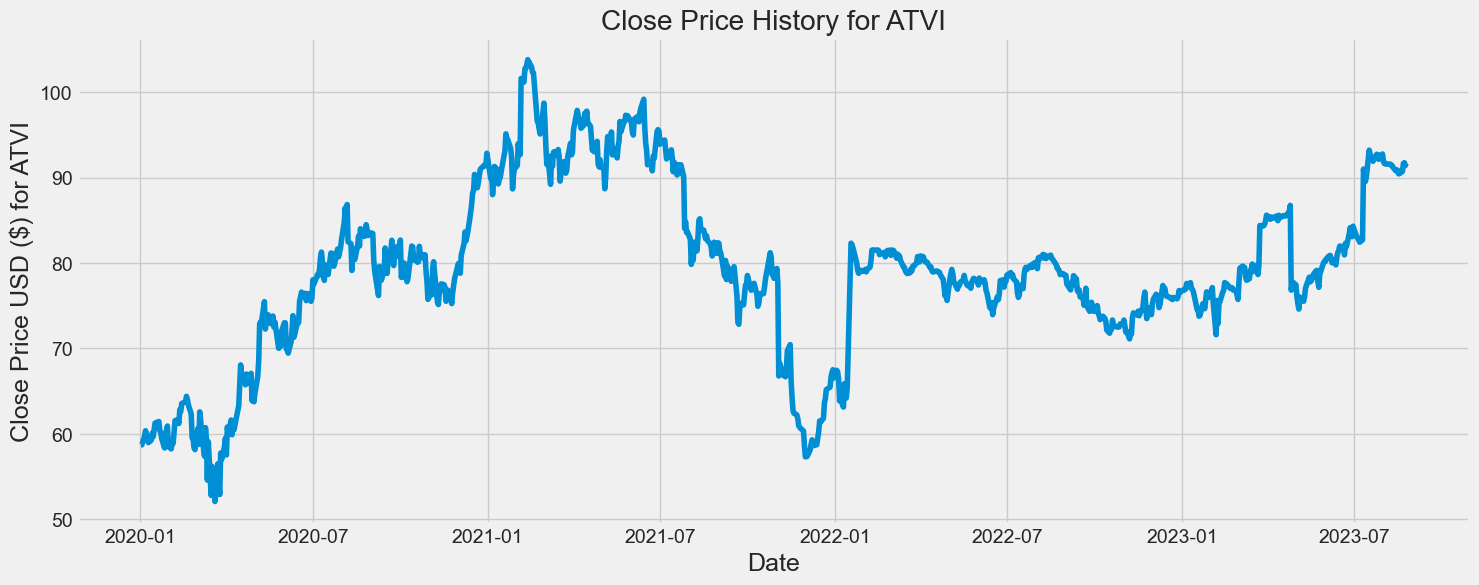

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 48s 48ms/step - loss: 0.0082
Epoch 2/5
814/814 [==============================] - 40s 49ms/step - loss: 0.0028
Epoch 3/5
814/814 [==============================] - 806s 991ms/step - loss: 0.0021
Epoch 4/5
814/814 [==============================] - 57s 71ms/step - loss: 0.0015
Epoch 5/5
2/2 [==============================] - 2s 67ms/step
[[82.65415 ]
 [83.149445]
 [84.126755]
 [85.14663 ]
 [85.386444]
 [84.801636]
 [85.49693 ]
 [85.13974 ]
 [84.313866]
 [83.95755 ]
 [84.05202 ]
 [84.104294]
 [87.67393 ]
 [90.16962 ]
 [90.3667  ]
 [90.33652 ]
 [92.976   ]
 [92.899994]
 [92.73625 ]
 [93.412476]
 [93.50033 ]
 [93.93086 ]
 [94.3376  ]
 [94.41576 ]
 [94.29934 ]
 [94.4989  ]
 [94.515144]
 [94.04311 ]
 [93.97458 ]
 [93.968544]
 [93.96073 ]
 [94.002335]
 [93.94471 ]
 [93.89952 ]
 [93.8777  ]
 [93.592545]
 [93.44113 ]
 [93.4395  ]
 [93.4818  ]
 [93.13165 ]
 [92.93459 ]
 [93.26582 ]
 [93.875565]
 [93.84508 ]
 [93.86531 ]]


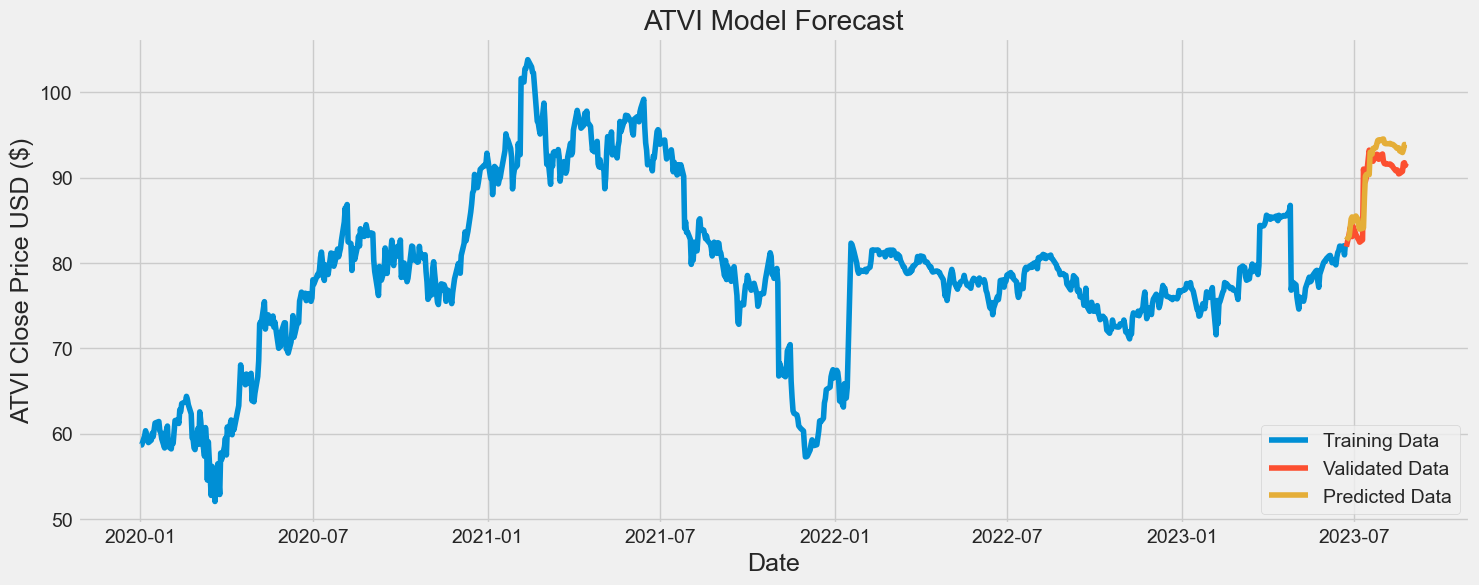

Test RMSE: 2.217


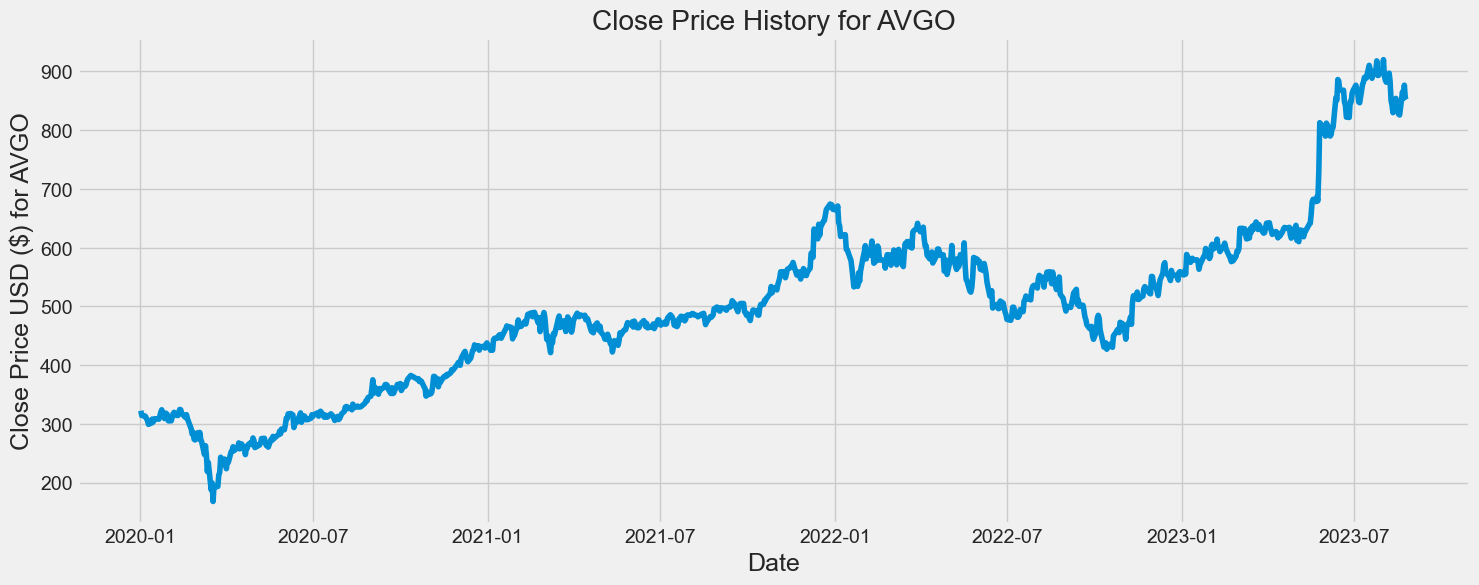

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 50s 52ms/step - loss: 0.0160
Epoch 2/5
814/814 [==============================] - 40s 49ms/step - loss: 0.0013
Epoch 3/5
814/814 [==============================] - 40s 49ms/step - loss: 8.6261e-04
Epoch 4/5
814/814 [==============================] - 41s 50ms/step - loss: 7.6980e-04
Epoch 5/5
2/2 [==============================] - 2s 68ms/step
[[832.0641 ]
 [829.03937]
 [825.7976 ]
 [824.5307 ]
 [824.57404]
 [825.91205]
 [828.08093]
 [829.5073 ]
 [829.9743 ]
 [828.4446 ]
 [826.9984 ]
 [827.7474 ]
 [829.84937]
 [832.67224]
 [834.8319 ]
 [836.1591 ]
 [837.9176 ]
 [839.38617]
 [840.0623 ]
 [840.3578 ]
 [841.7475 ]
 [842.199  ]
 [843.1305 ]
 [843.2882 ]
 [843.31036]
 [843.22833]
 [842.9578 ]
 [843.4215 ]
 [843.5058 ]
 [842.6359 ]
 [841.66156]
 [841.1778 ]
 [840.40173]
 [838.746  ]
 [835.8923 ]
 [831.7463 ]
 [828.934  ]
 [827.1072 ]
 [825.3813 ]
 [822.89905]
 [819.2392 ]
 [820.29004]
 [822.96643]
 [825.181  ]
 [828.4639 ]]


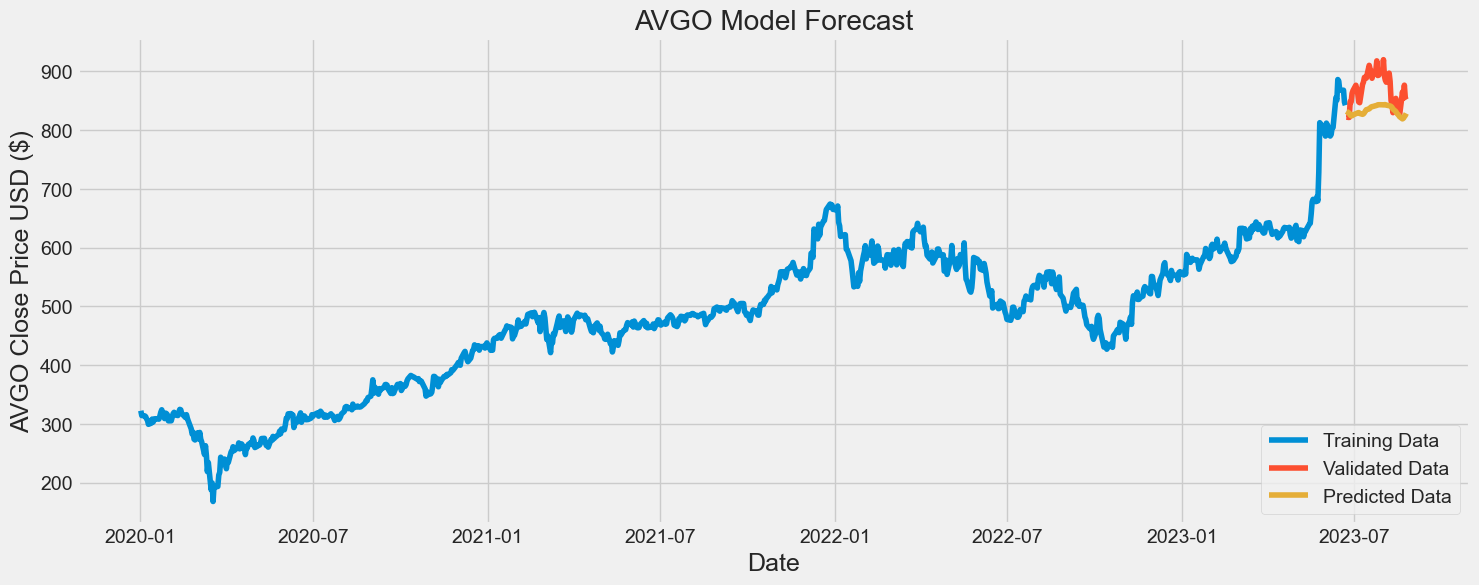

Test RMSE: 44.339


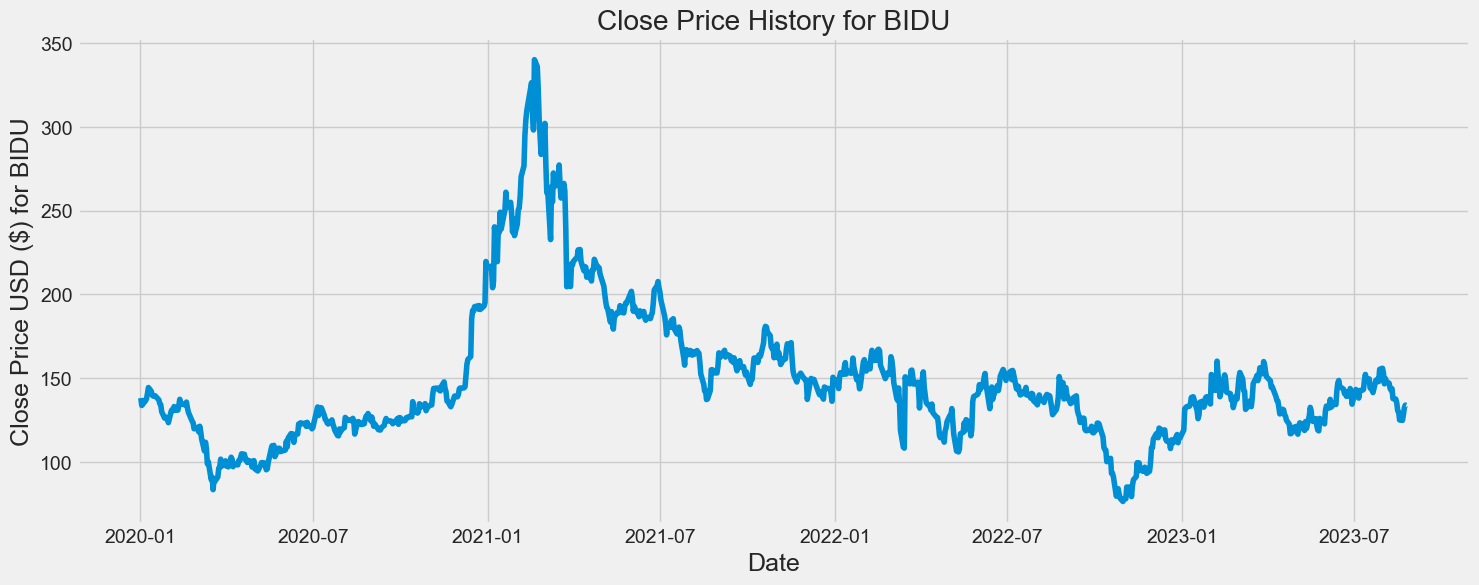

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 51s 53ms/step - loss: 0.0062
Epoch 2/5
814/814 [==============================] - 43s 53ms/step - loss: 0.0022
Epoch 3/5
814/814 [==============================] - 43s 53ms/step - loss: 0.0016
Epoch 4/5
814/814 [==============================] - 43s 53ms/step - loss: 0.0012
Epoch 5/5
2/2 [==============================] - 2s 64ms/step
[[144.63452]
 [143.51784]
 [143.79887]
 [146.02383]
 [146.13074]
 [143.07047]
 [141.59021]
 [145.281  ]
 [146.3689 ]
 [144.85765]
 [145.555  ]
 [146.00589]
 [146.48373]
 [149.69025]
 [152.74997]
 [152.93503]
 [151.82288]
 [149.23764]
 [148.28947]
 [147.13892]
 [146.5079 ]
 [148.00368]
 [151.62132]
 [152.47743]
 [152.39005]
 [155.10982]
 [156.97087]
 [155.94095]
 [151.84853]
 [151.47183]
 [151.55078]
 [150.80168]
 [148.22975]
 [147.27097]
 [148.49384]
 [145.52354]
 [142.95639]
 [141.80899]
 [139.48561]
 [138.28896]
 [135.63913]
 [133.69214]
 [134.91798]
 [137.21954]
 [140.01108]]


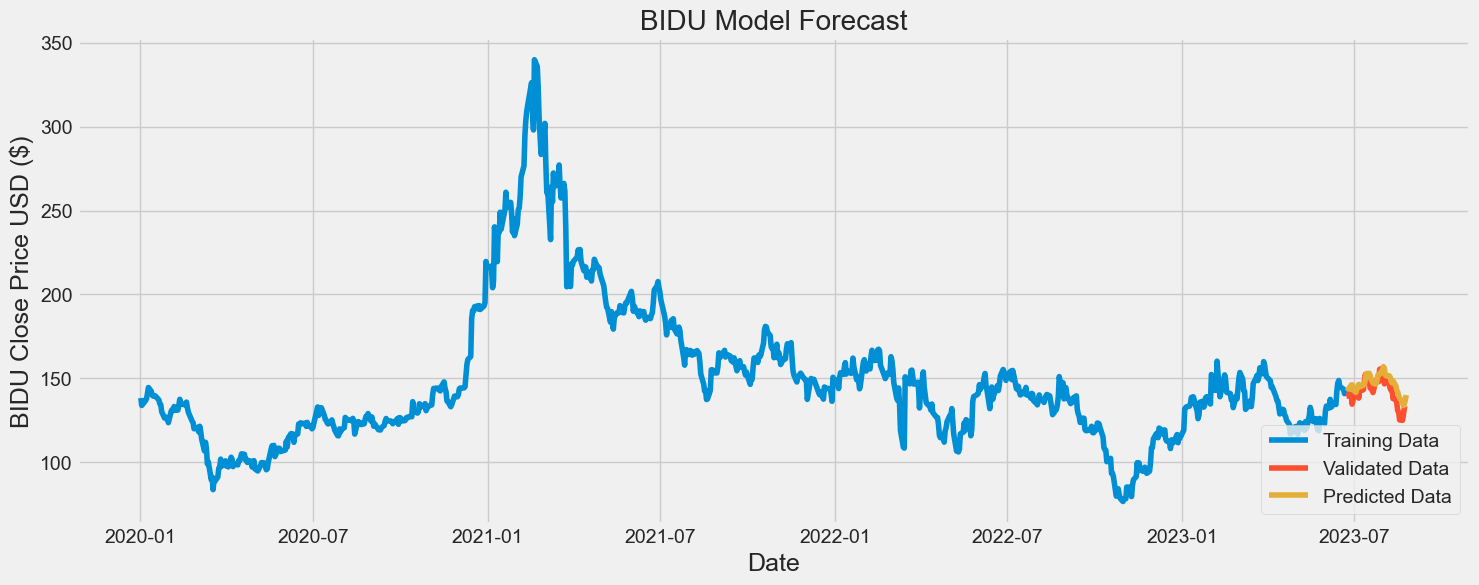

Test RMSE: 5.963


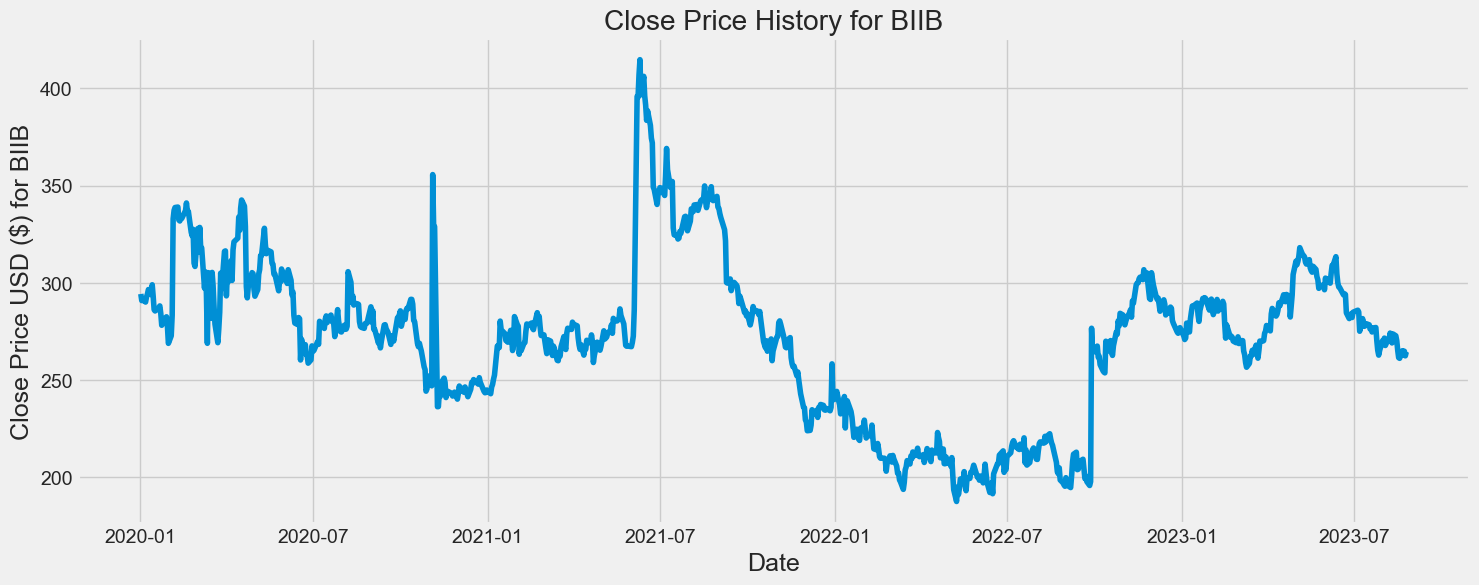

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 48s 50ms/step - loss: 0.0090
Epoch 2/5
814/814 [==============================] - 40s 49ms/step - loss: 0.0037
Epoch 3/5
814/814 [==============================] - 40s 49ms/step - loss: 0.0026
Epoch 4/5
814/814 [==============================] - 40s 49ms/step - loss: 0.0021
Epoch 5/5
2/2 [==============================] - 2s 54ms/step
[[294.57727]
 [289.57242]
 [281.99387]
 [280.38785]
 [282.38748]
 [282.6754 ]
 [285.1031 ]
 [284.2873 ]
 [285.912  ]
 [286.00055]
 [282.56802]
 [279.76968]
 [279.0608 ]
 [279.21225]
 [278.87186]
 [278.79553]
 [278.9988 ]
 [278.33508]
 [277.41547]
 [277.18475]
 [278.55865]
 [278.09494]
 [275.5897 ]
 [268.65097]
 [264.7461 ]
 [264.89148]
 [268.03345]
 [269.33655]
 [272.27832]
 [270.2888 ]
 [268.96112]
 [268.49768]
 [274.07727]
 [273.72678]
 [271.44745]
 [271.91934]
 [272.70813]
 [270.7579 ]
 [267.96185]
 [263.78763]
 [260.91547]
 [262.339  ]
 [263.3945 ]
 [264.81165]
 [264.02   ]]


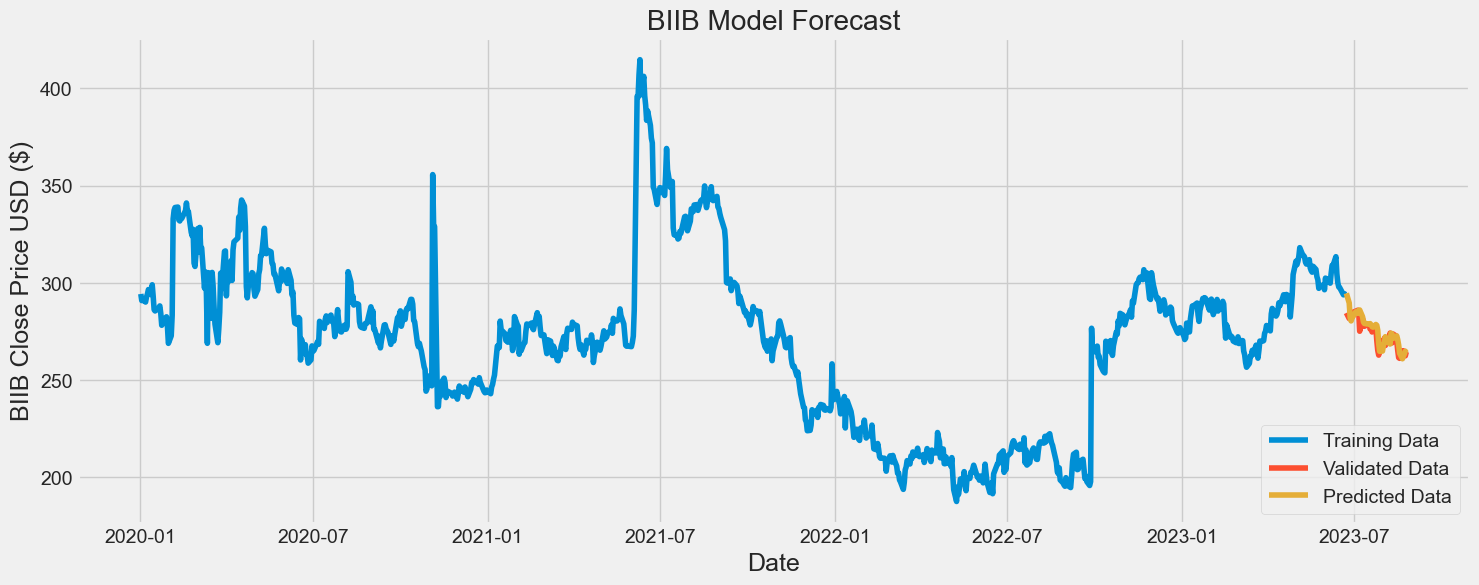

Test RMSE: 4.146


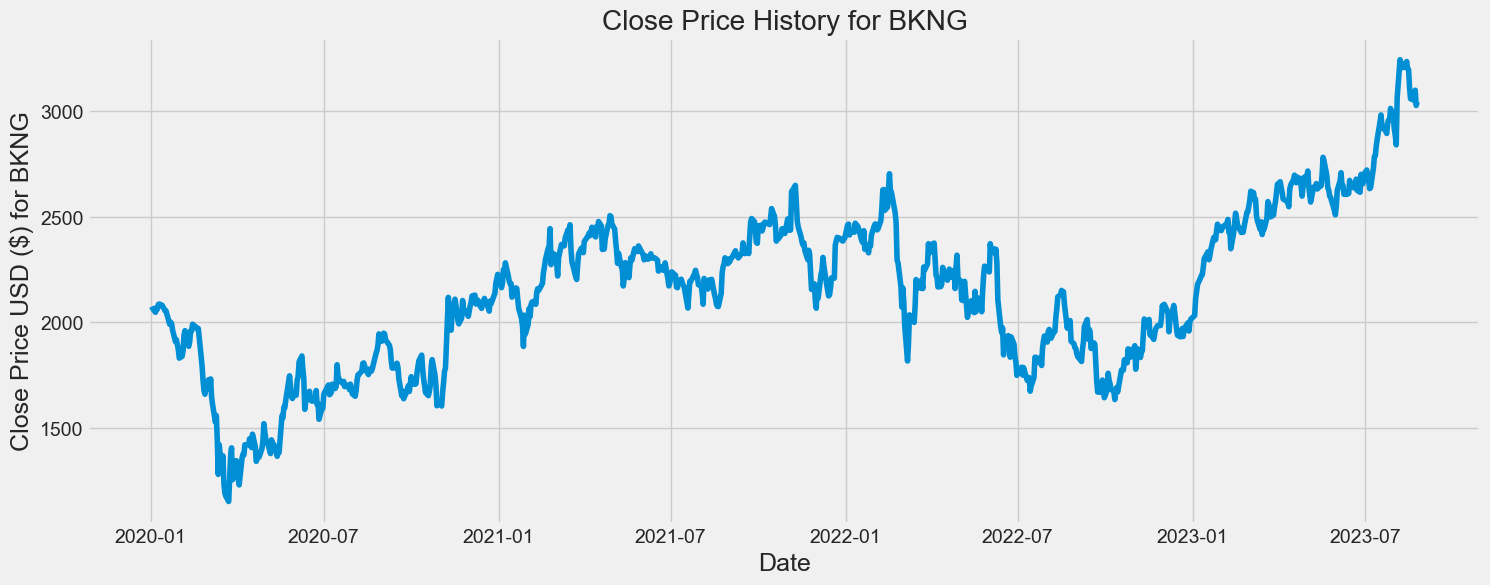

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 45s 50ms/step - loss: 0.0063
Epoch 2/5
814/814 [==============================] - 41s 50ms/step - loss: 0.0023
Epoch 3/5
814/814 [==============================] - 41s 50ms/step - loss: 0.0015
Epoch 4/5
814/814 [==============================] - 42s 51ms/step - loss: 0.0011
Epoch 5/5
2/2 [==============================] - 2s 66ms/step
[[2578.1382]
 [2550.7236]
 [2545.6025]
 [2612.1875]
 [2583.645 ]
 [2564.3901]
 [2611.7783]
 [2605.8877]
 [2591.523 ]
 [2553.9116]
 [2567.2832]
 [2617.586 ]
 [2649.0493]
 [2656.6045]
 [2677.431 ]
 [2678.372 ]
 [2716.7764]
 [2729.5469]
 [2717.346 ]
 [2710.6877]
 [2735.3242]
 [2678.191 ]
 [2724.4937]
 [2724.024 ]
 [2735.8684]
 [2749.7039]
 [2739.644 ]
 [2707.724 ]
 [2702.0393]
 [2681.6968]
 [2816.5679]
 [2786.4033]
 [2800.8586]
 [2802.5894]
 [2806.8418]
 [2796.9883]
 [2812.0945]
 [2805.1953]
 [2806.4744]
 [2792.7983]
 [2766.2622]
 [2774.8965]
 [2780.4785]
 [2788.0117]
 [2766.4497]]


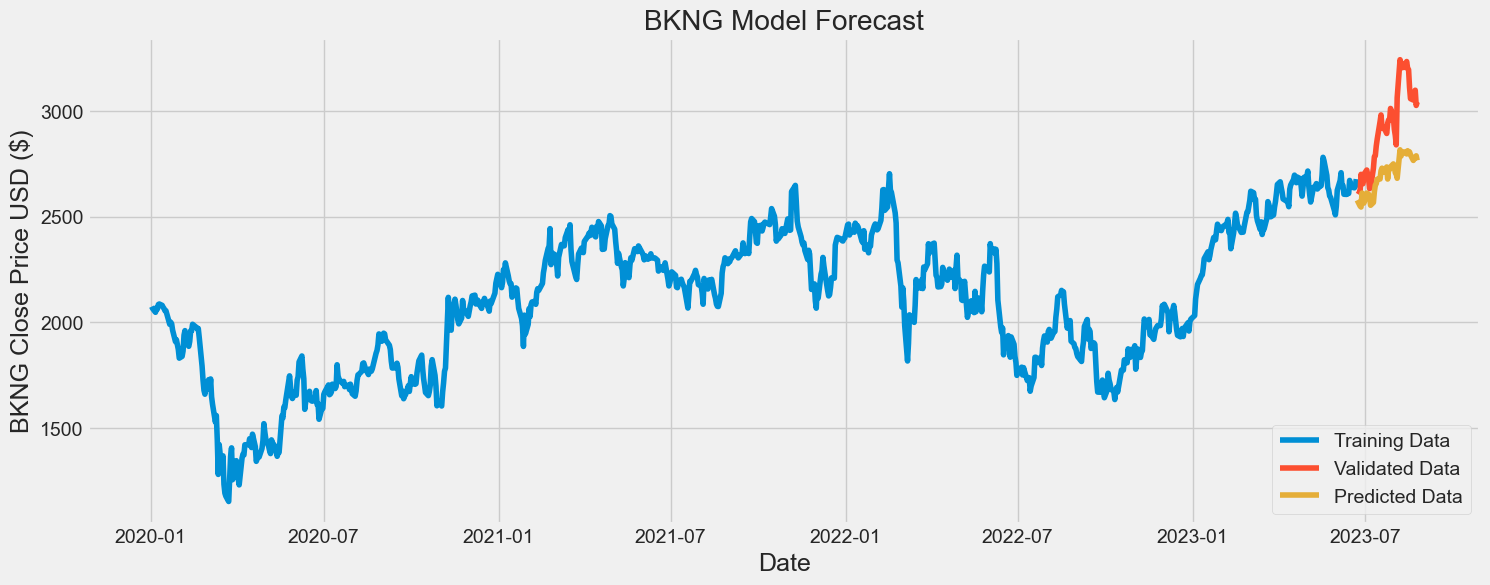

Test RMSE: 257.512


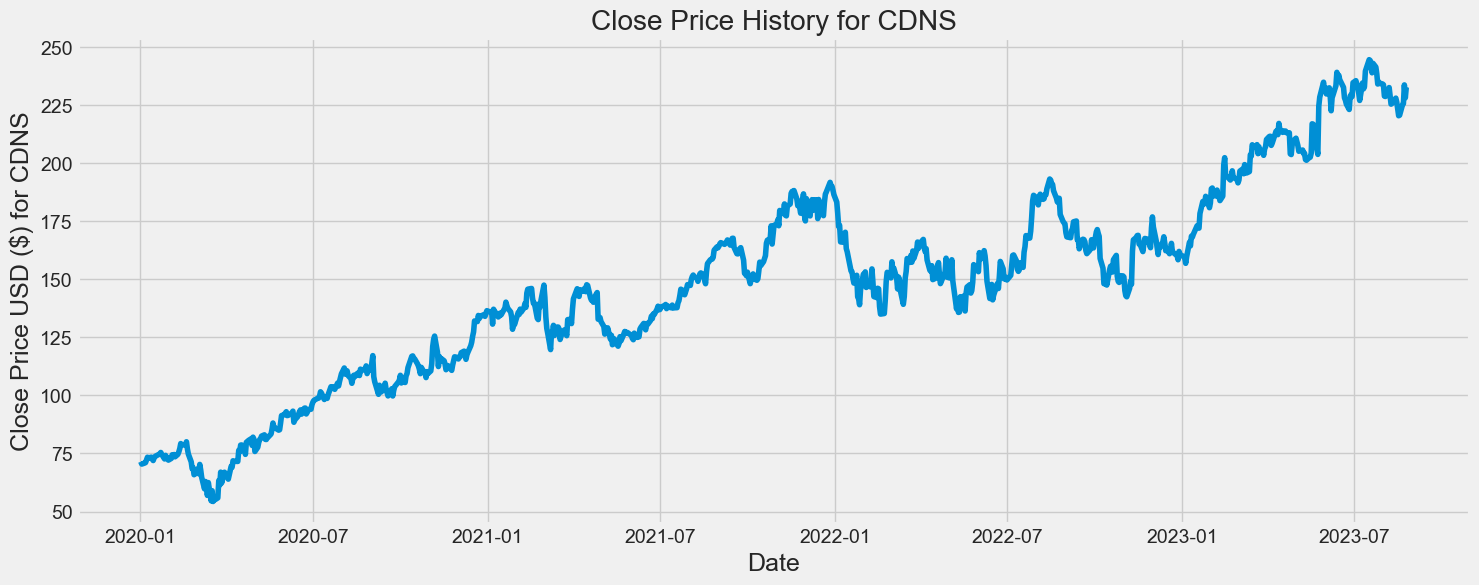

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 44s 49ms/step - loss: 0.0067
Epoch 2/5
814/814 [==============================] - 41s 50ms/step - loss: 0.0017
Epoch 3/5
814/814 [==============================] - 41s 50ms/step - loss: 0.0013
Epoch 4/5
814/814 [==============================] - 41s 50ms/step - loss: 0.0011
Epoch 5/5
2/2 [==============================] - 2s 64ms/step
[[222.95898]
 [222.14438]
 [222.04962]
 [221.9354 ]
 [221.84723]
 [221.75848]
 [222.1875 ]
 [222.72983]
 [222.87888]
 [222.15482]
 [221.25494]
 [221.36823]
 [221.79407]
 [222.2774 ]
 [223.25095]
 [224.27167]
 [225.00458]
 [225.46161]
 [225.75522]
 [225.82053]
 [226.09341]
 [226.43106]
 [226.04654]
 [225.51389]
 [225.37878]
 [225.15466]
 [224.73227]
 [224.1405 ]
 [223.19003]
 [222.30182]
 [221.8982 ]
 [222.05127]
 [221.77069]
 [220.85236]
 [220.16513]
 [219.32202]
 [219.01755]
 [218.99982]
 [218.6511 ]
 [217.75516]
 [216.42303]
 [216.60257]
 [217.5787 ]
 [219.24698]
 [220.62982]]


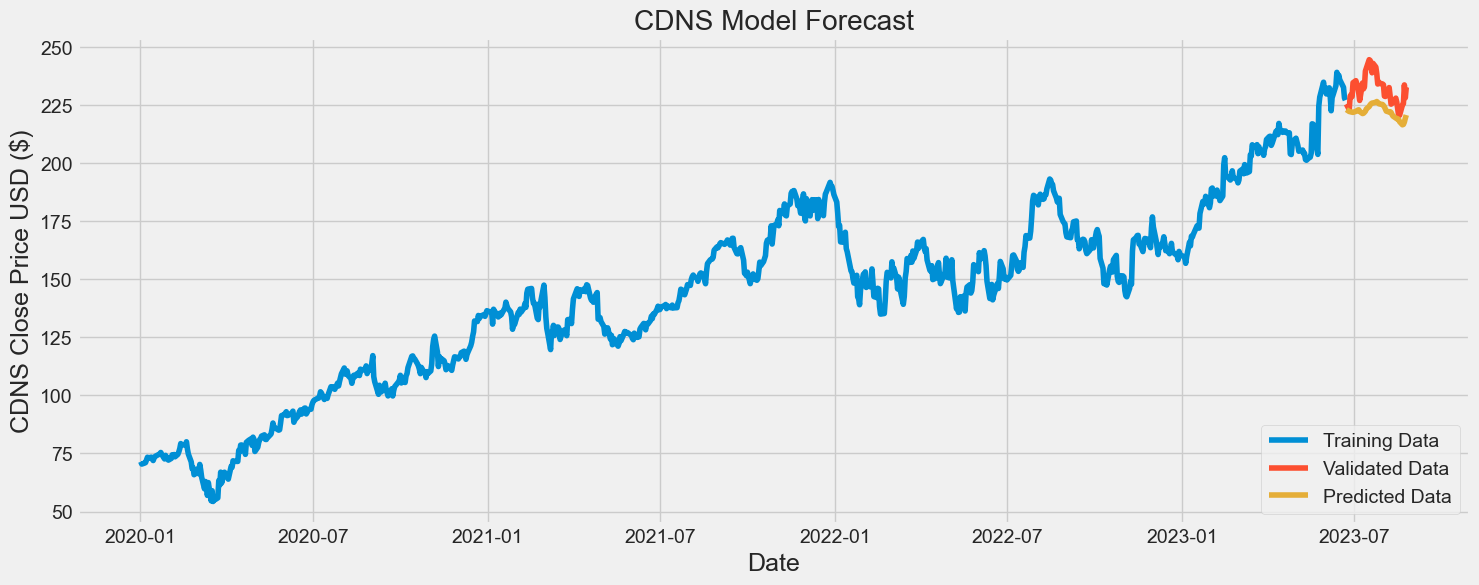

Test RMSE: 10.592


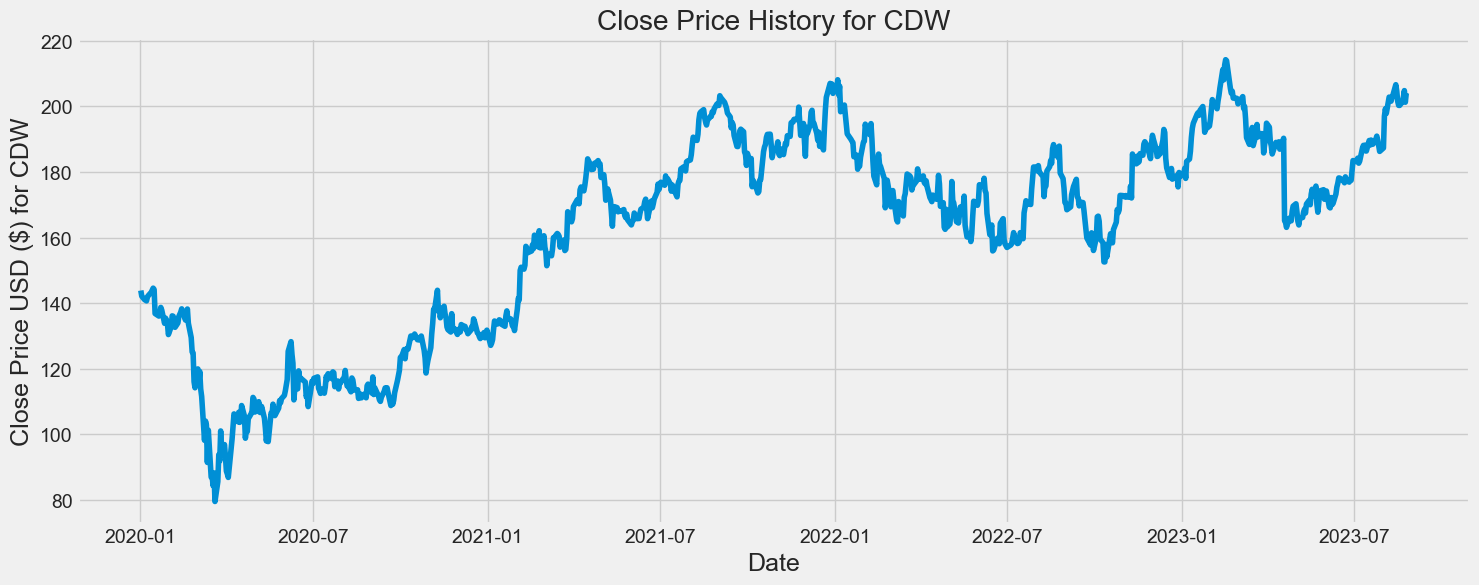

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 47s 52ms/step - loss: 0.0086
Epoch 2/5
814/814 [==============================] - 43s 53ms/step - loss: 0.0027
Epoch 3/5
814/814 [==============================] - 43s 53ms/step - loss: 0.0021
Epoch 4/5
814/814 [==============================] - 43s 53ms/step - loss: 0.0017
Epoch 5/5
2/2 [==============================] - 2s 79ms/step
[[175.33844]
 [175.19131]
 [175.28868]
 [173.58148]
 [174.49715]
 [176.88026]
 [180.64346]
 [181.81107]
 [181.06018]
 [179.82037]
 [180.70444]
 [182.77567]
 [185.40596]
 [185.78519]
 [185.36552]
 [184.67078]
 [185.5196 ]
 [186.2281 ]
 [186.975  ]
 [186.76518]
 [186.56812]
 [187.08755]
 [187.78499]
 [187.77585]
 [187.07687]
 [185.55586]
 [183.83467]
 [184.27173]
 [187.9821 ]
 [192.11903]
 [193.7696 ]
 [194.58905]
 [195.07112]
 [195.16177]
 [195.46048]
 [195.90866]
 [196.82245]
 [197.07382]
 [196.41118]
 [195.46173]
 [194.12064]
 [194.51787]
 [195.47731]
 [196.24023]
 [196.06964]]


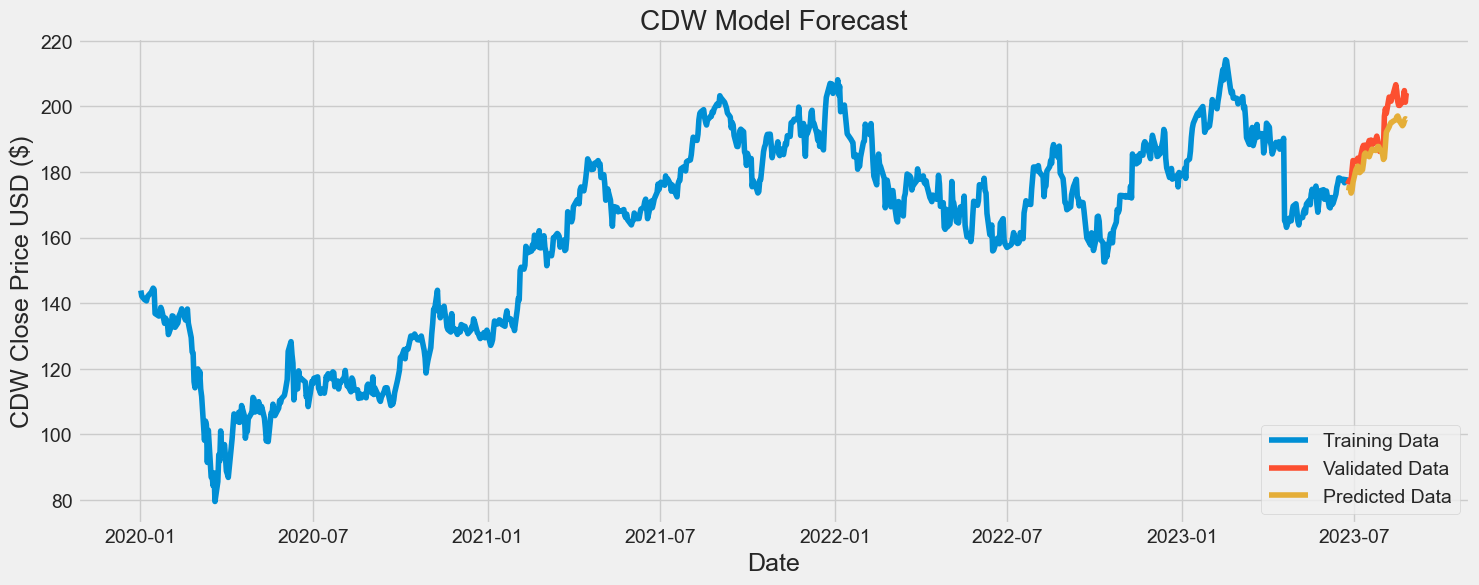

Test RMSE: 5.736


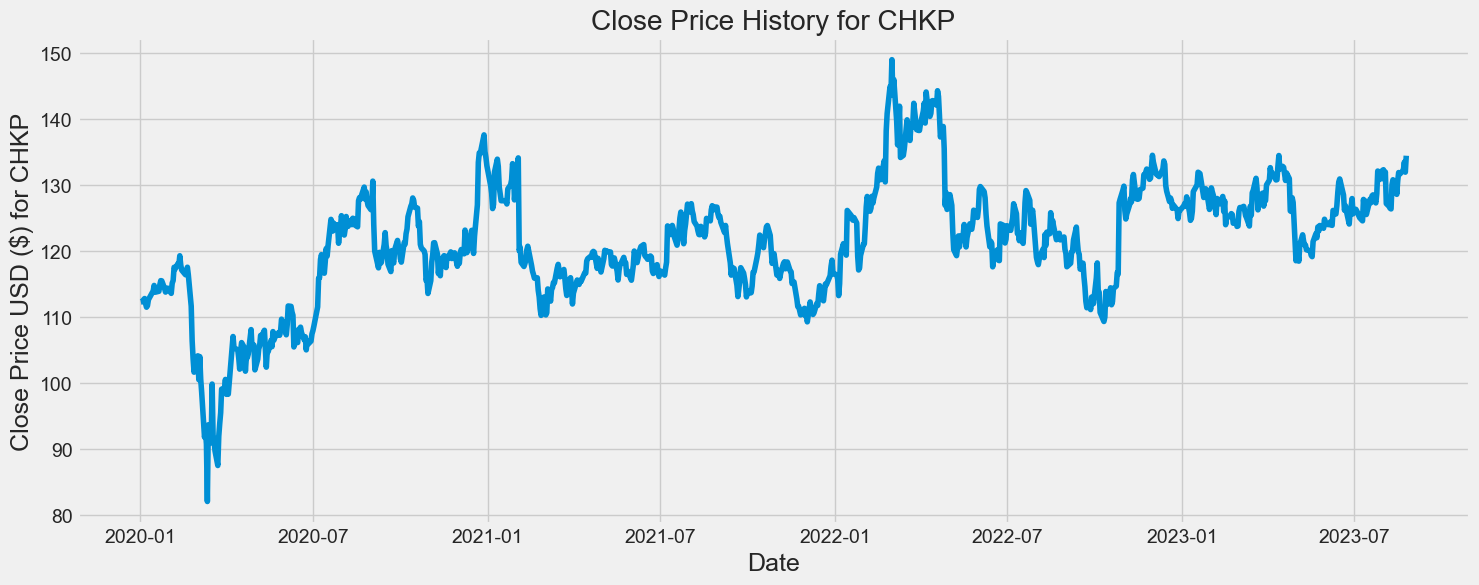

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 52s 57ms/step - loss: 0.0088
Epoch 2/5
814/814 [==============================] - 51s 63ms/step - loss: 0.0027
Epoch 3/5
814/814 [==============================] - 46s 57ms/step - loss: 0.0019
Epoch 4/5
814/814 [==============================] - 38s 46ms/step - loss: 0.0015
Epoch 5/5
2/2 [==============================] - 2s 42ms/step
[[127.49747 ]
 [127.46645 ]
 [126.02696 ]
 [126.9077  ]
 [127.96231 ]
 [128.9892  ]
 [128.3172  ]
 [127.19463 ]
 [127.14548 ]
 [125.93985 ]
 [126.47649 ]
 [125.70021 ]
 [128.24832 ]
 [128.66444 ]
 [129.30649 ]
 [127.65103 ]
 [127.85823 ]
 [129.44362 ]
 [129.86293 ]
 [130.01605 ]
 [130.9454  ]
 [129.29446 ]
 [129.31357 ]
 [132.53563 ]
 [133.75528 ]
 [132.72786 ]
 [133.16699 ]
 [133.29713 ]
 [132.45122 ]
 [132.86046 ]
 [130.11958 ]
 [127.66183 ]
 [127.84034 ]
 [127.742584]
 [131.82225 ]
 [132.40723 ]
 [132.0546  ]
 [130.37288 ]
 [132.09671 ]
 [133.18881 ]
 [132.82642 ]
 [133.9691  ]
 [133.653

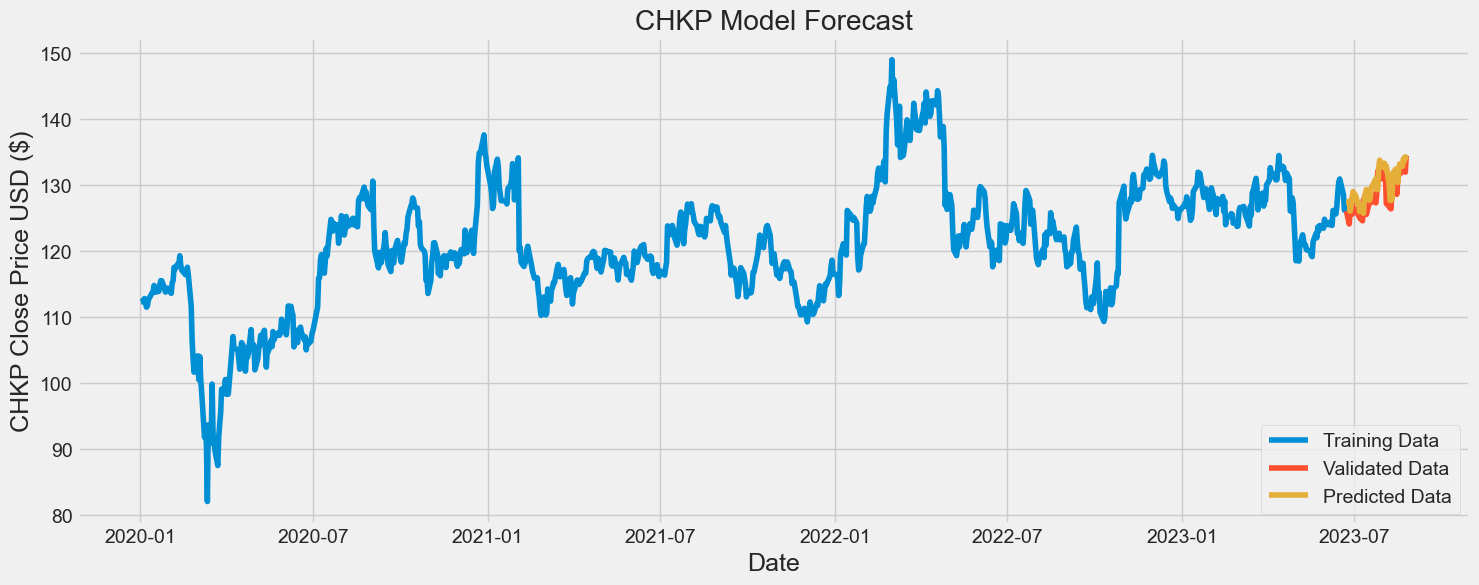

Test RMSE: 2.069


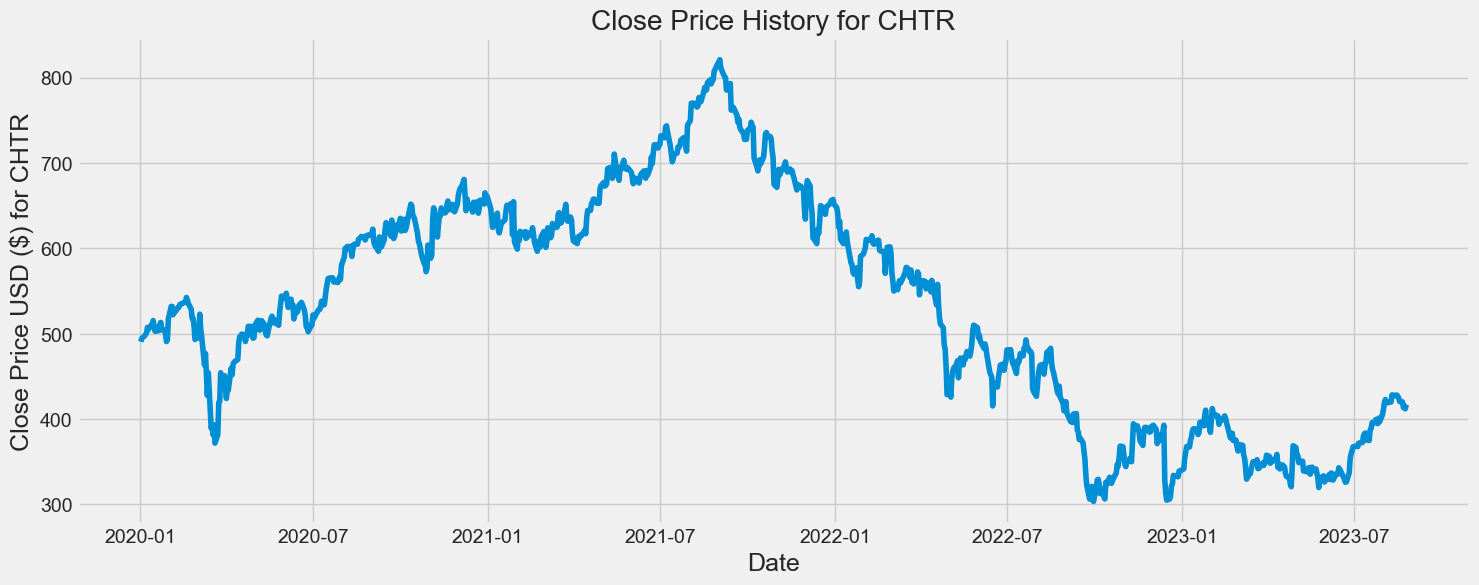

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 37s 41ms/step - loss: 0.0380
Epoch 2/5
814/814 [==============================] - 34s 42ms/step - loss: 0.0027
Epoch 3/5
814/814 [==============================] - 35s 43ms/step - loss: 0.0020
Epoch 4/5
814/814 [==============================] - 38s 47ms/step - loss: 0.0015
Epoch 5/5
2/2 [==============================] - 2s 54ms/step
[[344.92075]
 [344.2646 ]
 [343.9812 ]
 [344.20798]
 [345.94232]
 [348.70566]
 [352.15192]
 [356.07144]
 [359.22397]
 [361.9738 ]
 [365.24515]
 [368.22858]
 [371.57263]
 [375.83502]
 [379.87524]
 [380.7868 ]
 [378.6733 ]
 [379.1659 ]
 [379.6494 ]
 [382.33688]
 [382.1787 ]
 [386.10962]
 [391.4966 ]
 [394.00824]
 [394.77066]
 [394.15436]
 [395.81158]
 [398.27548]
 [403.67493]
 [410.98   ]
 [415.6874 ]
 [417.92575]
 [418.06134]
 [418.8628 ]
 [419.1293 ]
 [420.61566]
 [420.6401 ]
 [419.34943]
 [418.3966 ]
 [417.5641 ]
 [415.06094]
 [413.0502 ]
 [409.58636]
 [407.846  ]
 [406.2537 ]]


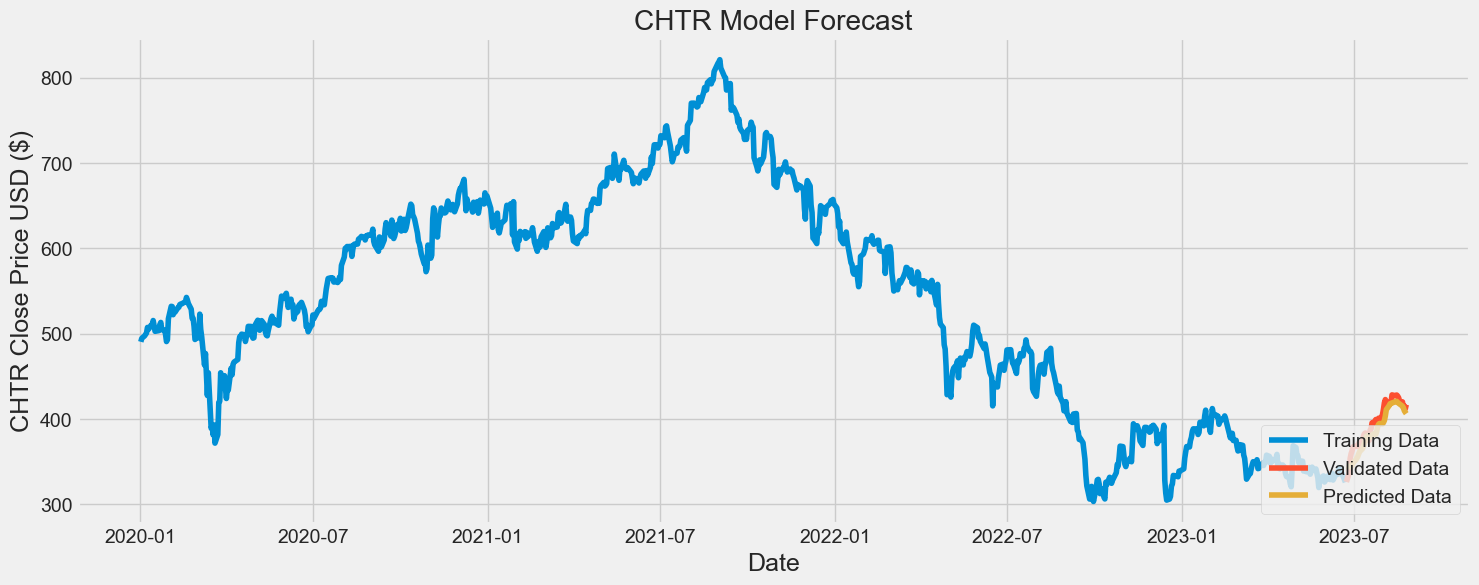

Test RMSE: 10.868


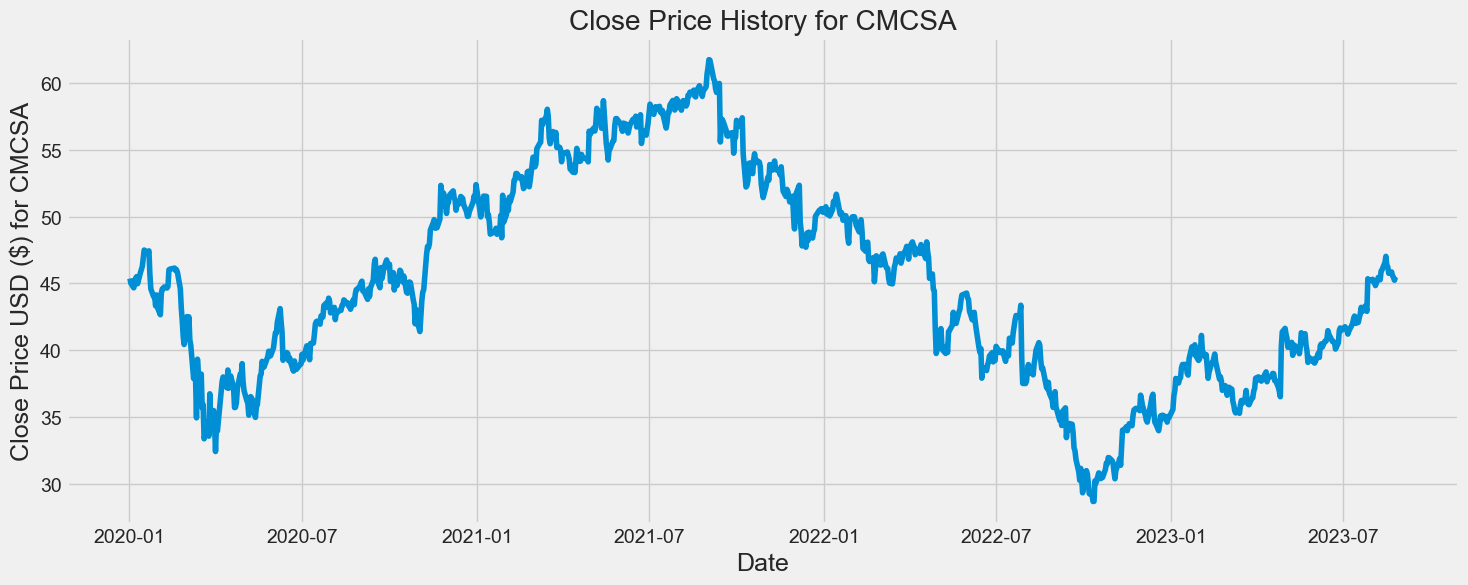

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 39s 44ms/step - loss: 0.0092
Epoch 2/5
814/814 [==============================] - 34s 42ms/step - loss: 0.0029
Epoch 3/5
814/814 [==============================] - 35s 44ms/step - loss: 0.0024
Epoch 4/5
814/814 [==============================] - 39s 48ms/step - loss: 0.0018
Epoch 5/5
2/2 [==============================] - 2s 52ms/step
[[40.291   ]
 [39.97828 ]
 [39.728542]
 [39.826035]
 [40.248516]
 [40.750954]
 [41.035343]
 [41.249367]
 [41.27214 ]
 [41.13423 ]
 [40.992554]
 [40.956123]
 [41.12301 ]
 [41.36812 ]
 [41.65139 ]
 [41.79461 ]
 [41.65734 ]
 [41.53063 ]
 [41.544807]
 [41.82981 ]
 [41.253315]
 [41.574097]
 [42.221184]
 [42.578014]
 [42.961655]
 [43.74379 ]
 [44.53118 ]
 [44.994766]
 [45.00354 ]
 [44.922096]
 [44.79329 ]
 [44.760174]
 [44.561012]
 [44.501404]
 [44.681374]
 [44.936836]
 [45.08416 ]
 [45.2756  ]
 [45.547203]
 [45.783295]
 [45.54209 ]
 [45.264328]
 [45.1073  ]
 [44.83831 ]
 [44.634426]]


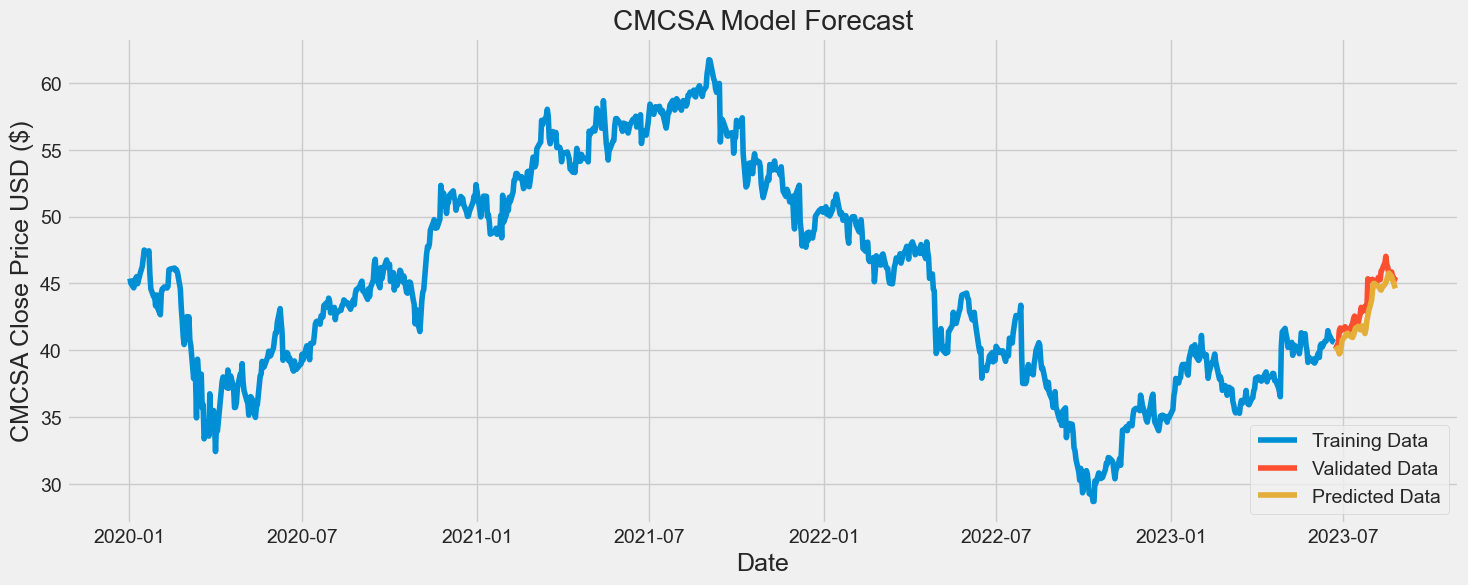

Test RMSE: 1.138


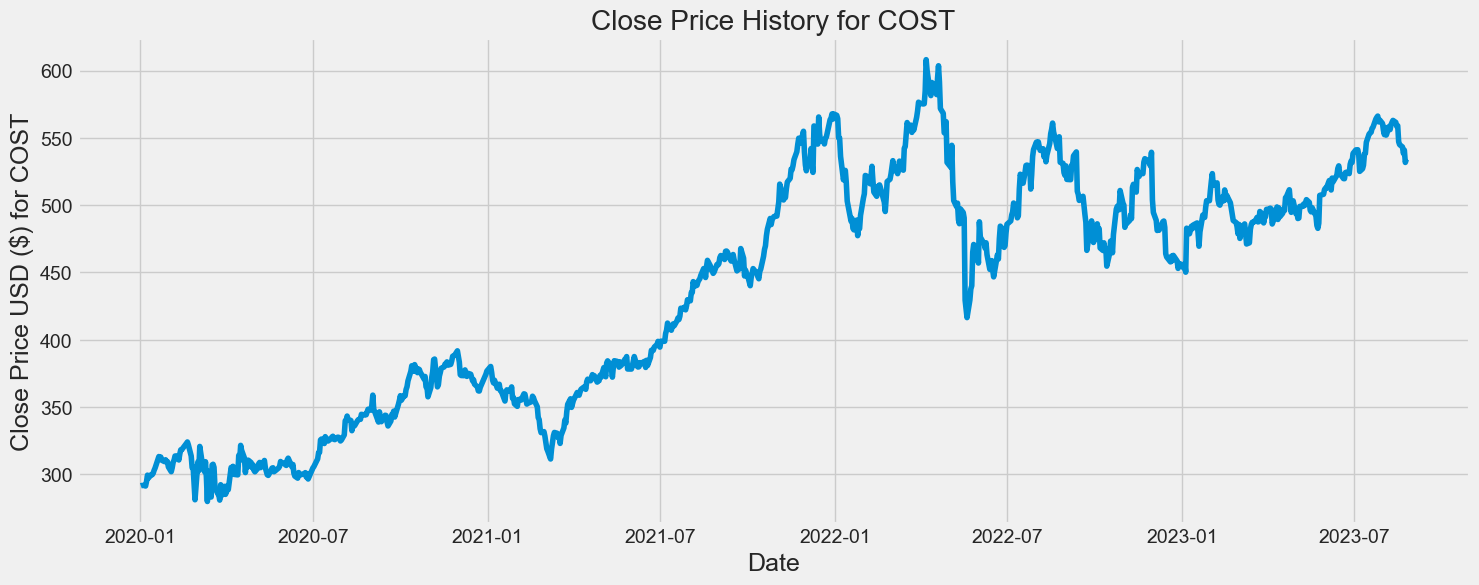

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 38s 40ms/step - loss: 0.0090
Epoch 2/5
814/814 [==============================] - 34s 42ms/step - loss: 0.0028
Epoch 3/5
814/814 [==============================] - 37s 45ms/step - loss: 0.0019
Epoch 4/5
814/814 [==============================] - 42s 51ms/step - loss: 0.0016
Epoch 5/5
2/2 [==============================] - 2s 54ms/step
[[524.25793]
 [524.06647]
 [523.9136 ]
 [525.31915]
 [528.3366 ]
 [529.5952 ]
 [531.54047]
 [534.96216]
 [537.1662 ]
 [536.74634]
 [531.96606]
 [529.60925]
 [530.2683 ]
 [533.3717 ]
 [536.00806]
 [539.3635 ]
 [543.7499 ]
 [546.8104 ]
 [548.72095]
 [549.942  ]
 [549.6229 ]
 [554.01843]
 [557.63367]
 [558.8287 ]
 [558.465  ]
 [557.9436 ]
 [556.6836 ]
 [554.6023 ]
 [551.339  ]
 [550.4188 ]
 [549.77966]
 [549.1259 ]
 [547.48645]
 [546.7973 ]
 [548.26965]
 [548.3753 ]
 [548.39044]
 [547.6598 ]
 [547.4617 ]
 [544.3808 ]
 [540.7261 ]
 [537.8025 ]
 [536.629  ]
 [536.05237]
 [533.7092 ]]


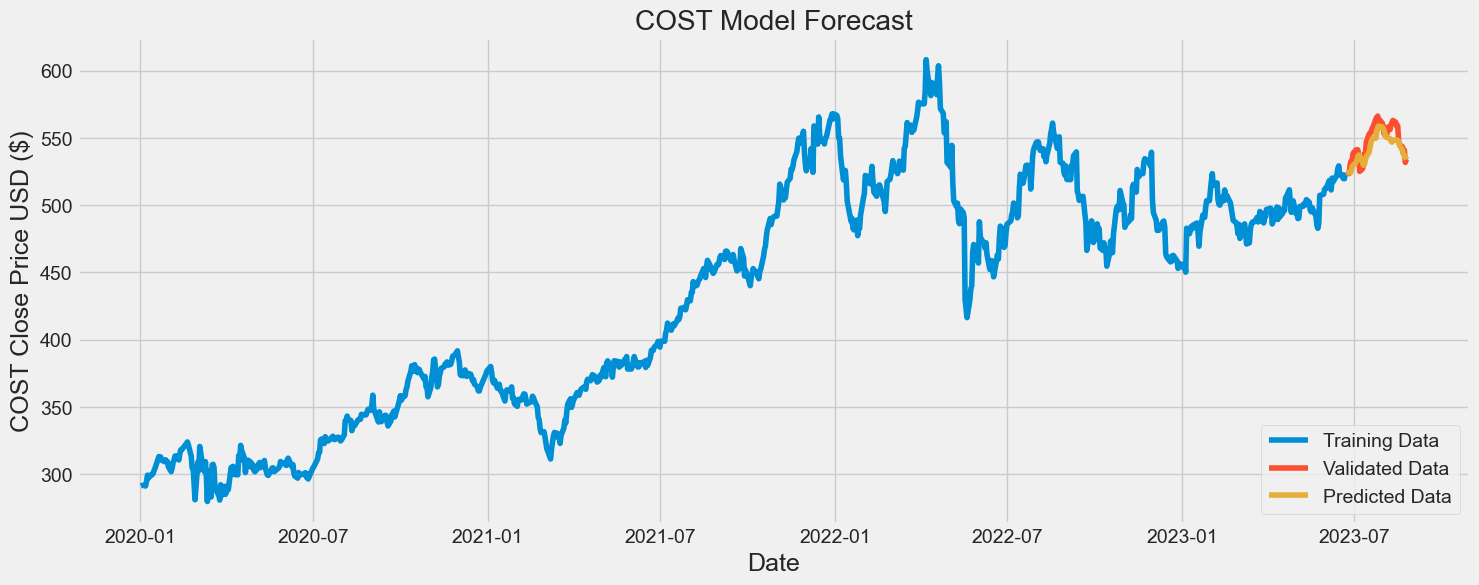

Test RMSE: 7.866


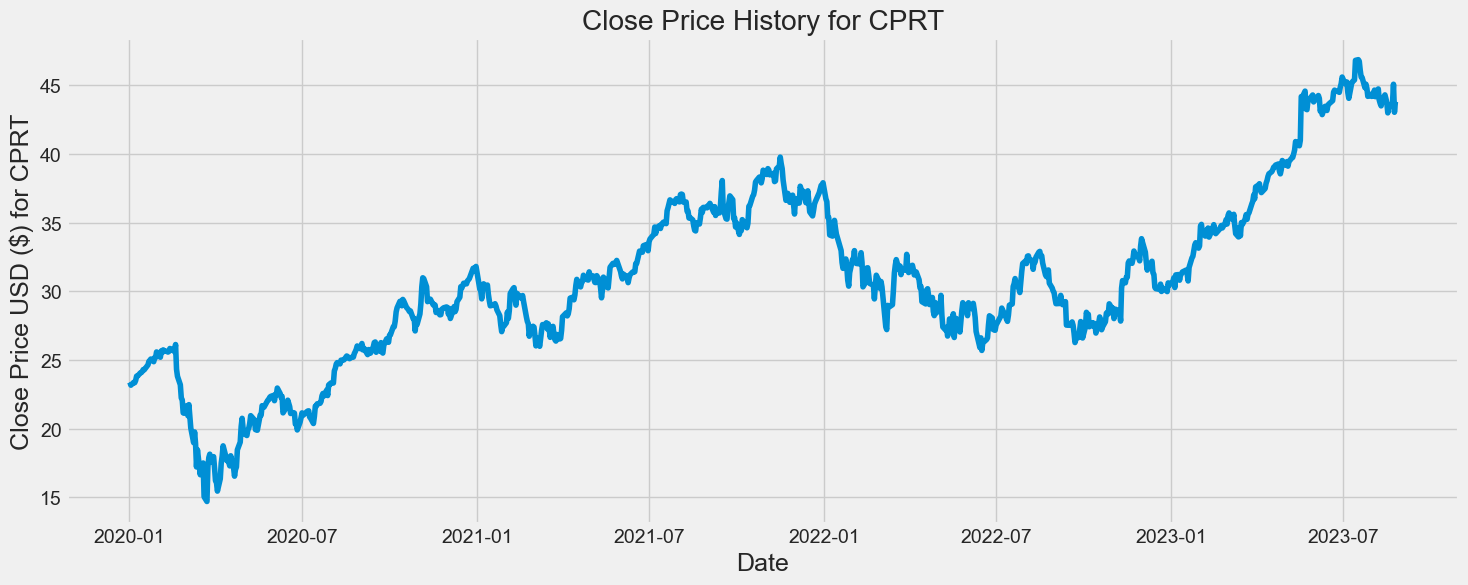

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 38s 40ms/step - loss: 0.0060
Epoch 2/5
814/814 [==============================] - 39s 48ms/step - loss: 0.0017
Epoch 3/5
814/814 [==============================] - 44s 53ms/step - loss: 0.0012
Epoch 4/5
814/814 [==============================] - 41s 51ms/step - loss: 0.0010
Epoch 5/5
2/2 [==============================] - 1s 49ms/step
[[43.628395]
 [43.641243]
 [43.70229 ]
 [43.73419 ]
 [43.807552]
 [43.89215 ]
 [43.99952 ]
 [44.011375]
 [43.993267]
 [43.89892 ]
 [43.801903]
 [43.916924]
 [44.03814 ]
 [44.05745 ]
 [44.07968 ]
 [44.213036]
 [44.37526 ]
 [44.42563 ]
 [44.390335]
 [44.32776 ]
 [44.29313 ]
 [44.262726]
 [44.2106  ]
 [44.15176 ]
 [44.070225]
 [44.00184 ]
 [43.928844]
 [43.899567]
 [43.851562]
 [43.85697 ]
 [43.873417]
 [43.890114]
 [43.823597]
 [43.701675]
 [43.632744]
 [43.573822]
 [43.643257]
 [43.66031 ]
 [43.60151 ]
 [43.451176]
 [43.358696]
 [43.336617]
 [43.406193]
 [43.650032]
 [43.60383 ]]


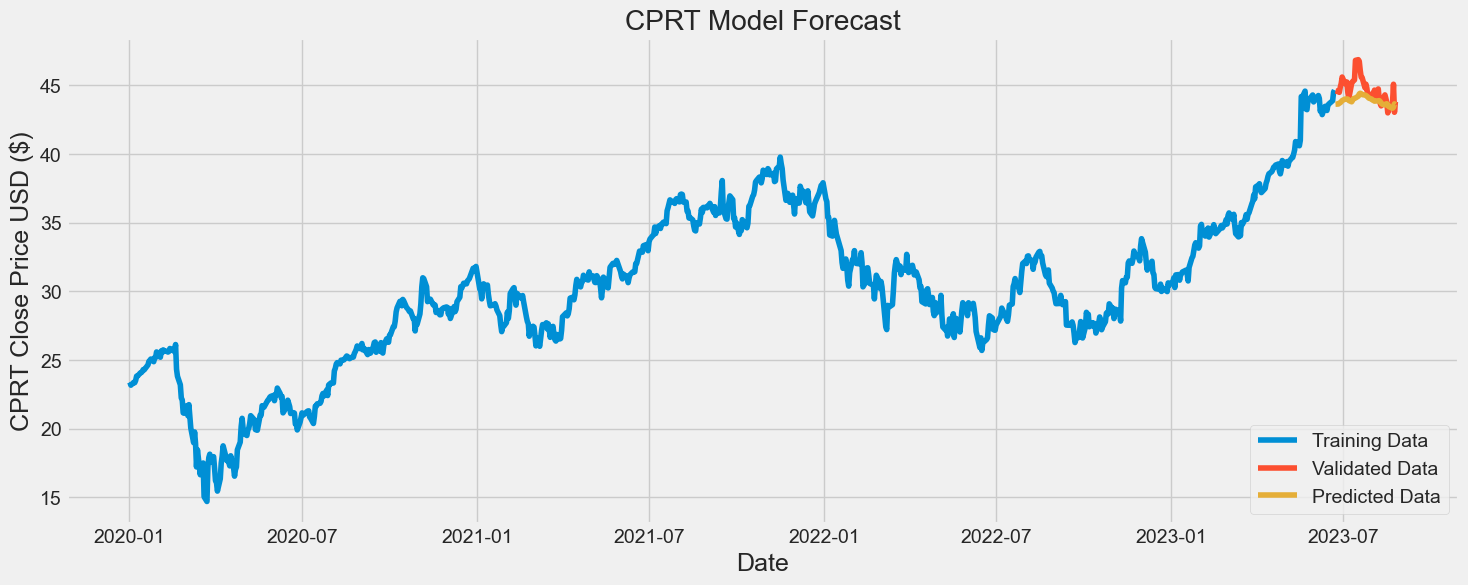

Test RMSE: 1.079


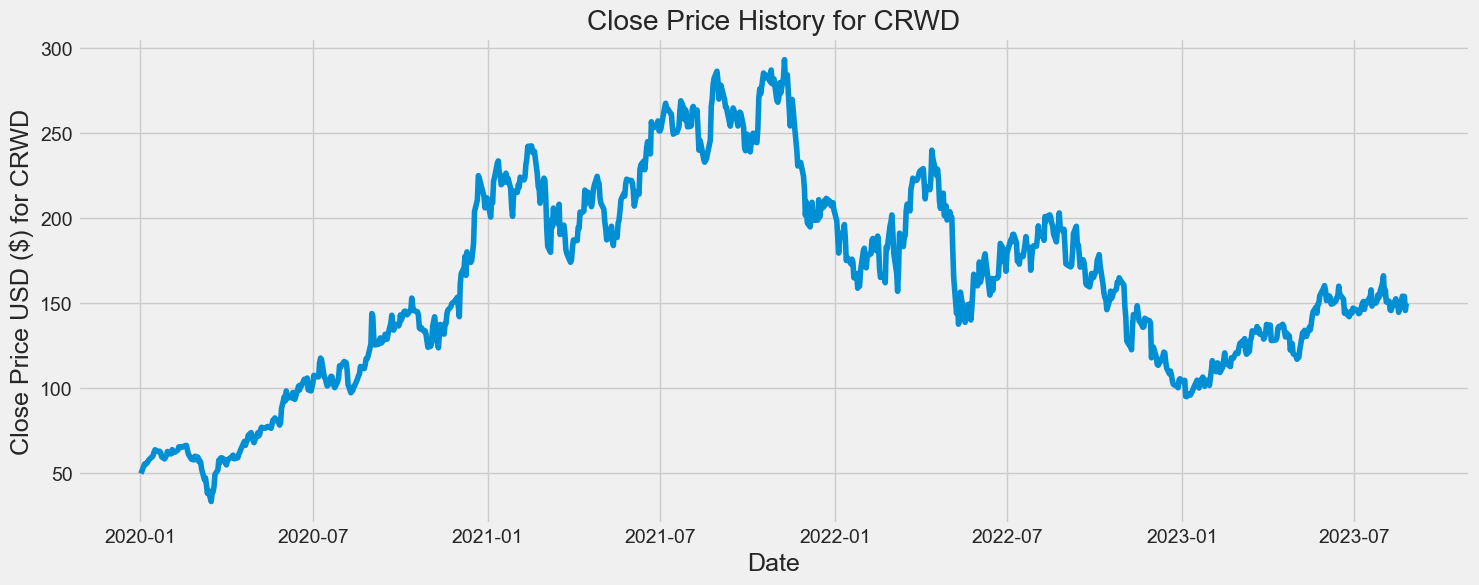

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 43s 45ms/step - loss: 0.0161
Epoch 2/5
814/814 [==============================] - 42s 52ms/step - loss: 0.0031
Epoch 3/5
814/814 [==============================] - 40s 49ms/step - loss: 0.0022
Epoch 4/5
814/814 [==============================] - 42s 51ms/step - loss: 0.0016
Epoch 5/5
2/2 [==============================] - 2s 49ms/step
[[144.04898]
 [144.63925]
 [144.98473]
 [145.80814]
 [146.68805]
 [146.8276 ]
 [148.00783]
 [148.36458]
 [147.13406]
 [143.87115]
 [145.0986 ]
 [148.42554]
 [152.54144]
 [150.8044 ]
 [150.53365]
 [151.09085]
 [152.39964]
 [154.01701]
 [157.9179 ]
 [152.71504]
 [149.85384]
 [150.2694 ]
 [152.60461]
 [154.14911]
 [156.07053]
 [157.06195]
 [161.0023 ]
 [164.8883 ]
 [158.02266]
 [155.03465]
 [151.69424]
 [150.9436 ]
 [147.2389 ]
 [146.80226]
 [149.82388]
 [150.98534]
 [152.15291]
 [152.10481]
 [150.80487]
 [147.29233]
 [145.27103]
 [152.4664 ]
 [156.45103]
 [156.1486 ]
 [150.55756]]


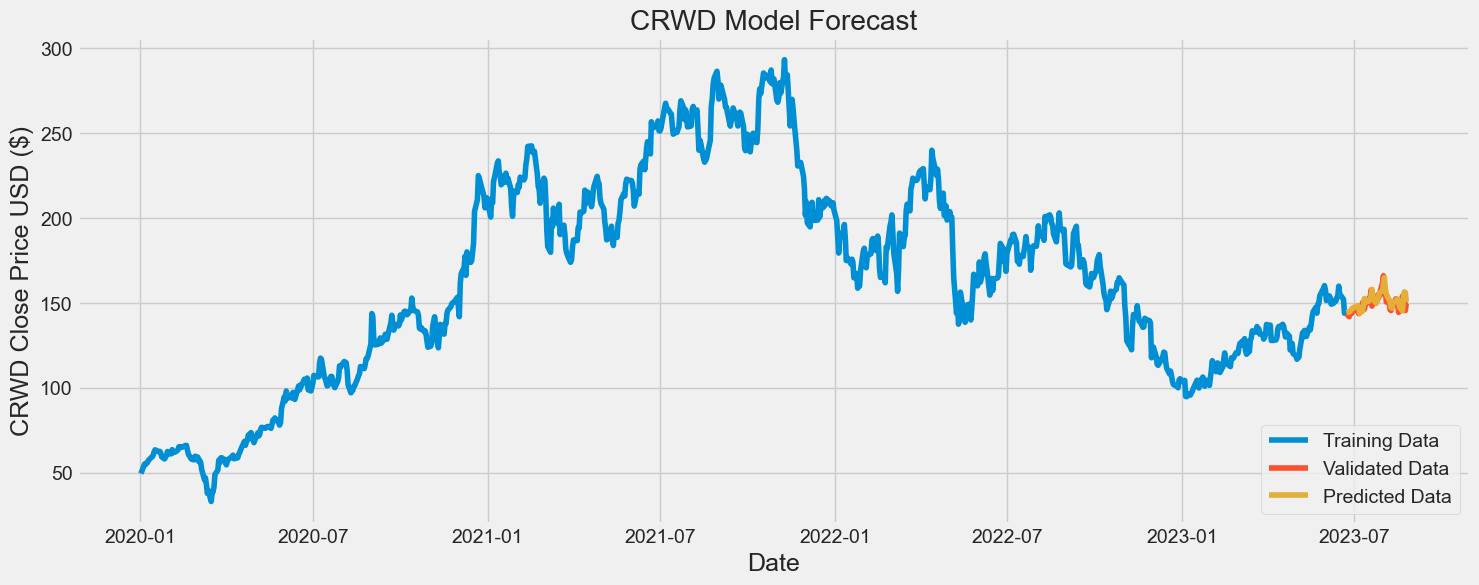

Test RMSE: 3.936


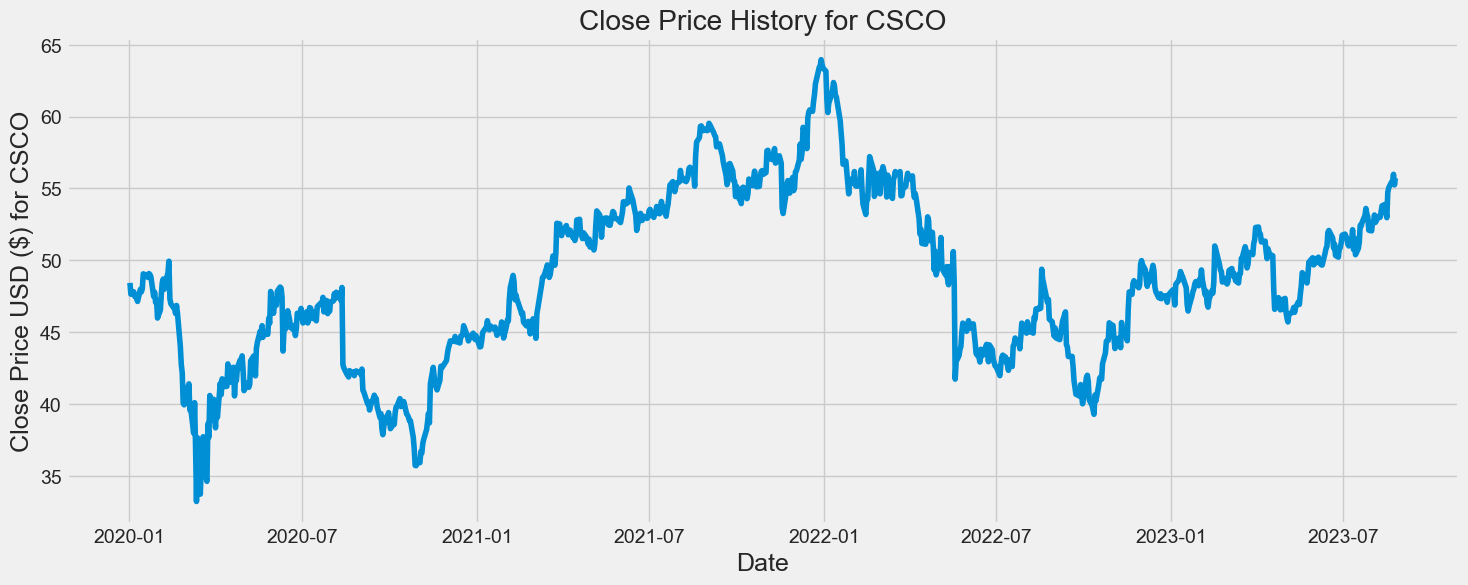

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 39s 40ms/step - loss: 0.0052
Epoch 2/5
814/814 [==============================] - 36s 44ms/step - loss: 0.0021
Epoch 3/5
814/814 [==============================] - 40s 50ms/step - loss: 0.0016
Epoch 4/5
814/814 [==============================] - 41s 51ms/step - loss: 0.0014
Epoch 5/5
2/2 [==============================] - 2s 48ms/step
[[50.371147]
 [49.94495 ]
 [49.986023]
 [50.249954]
 [50.259644]
 [50.47003 ]
 [51.193363]
 [50.85353 ]
 [50.548355]
 [50.342346]
 [50.539658]
 [50.66546 ]
 [51.278893]
 [50.387733]
 [50.65412 ]
 [49.86068 ]
 [50.12047 ]
 [50.633728]
 [51.610737]
 [51.562138]
 [51.887146]
 [52.276493]
 [52.78638 ]
 [52.68067 ]
 [52.838837]
 [51.52751 ]
 [51.778522]
 [52.356842]
 [52.209408]
 [52.409565]
 [52.313354]
 [52.400764]
 [52.285004]
 [52.48124 ]
 [53.002445]
 [52.95775 ]
 [53.25836 ]
 [52.786034]
 [52.619602]
 [54.567097]
 [54.151108]
 [54.836678]
 [54.91839 ]
 [55.367493]
 [55.293617]]


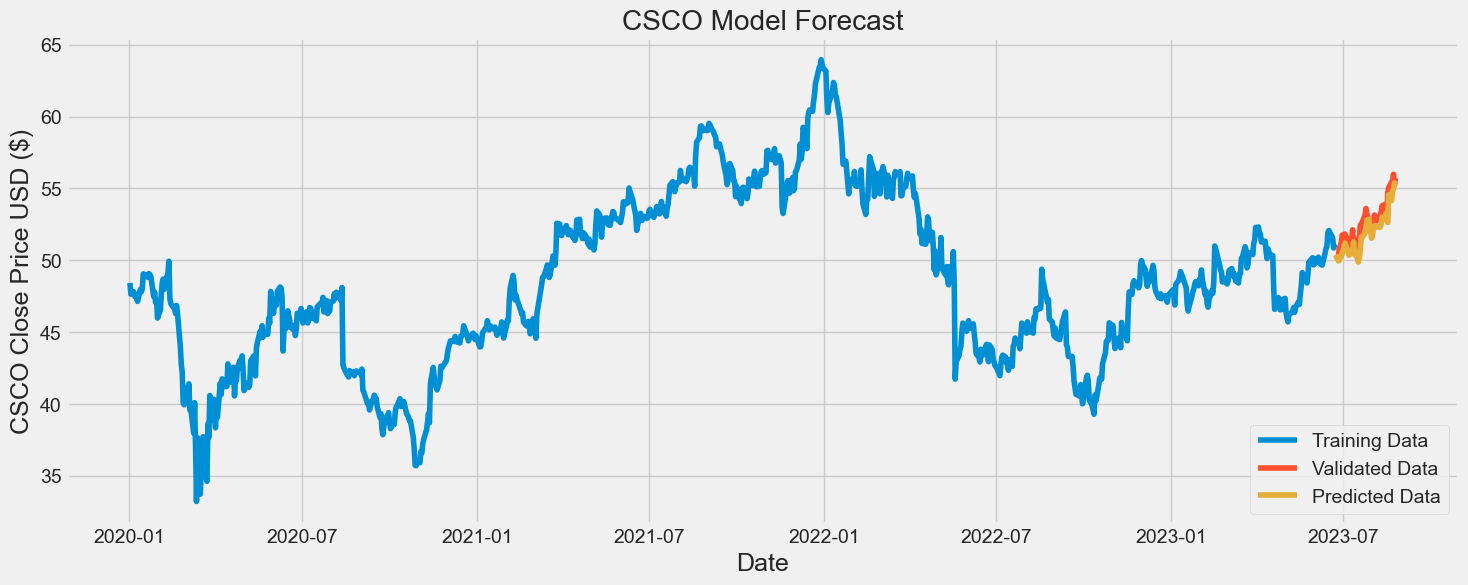

Test RMSE: 0.879


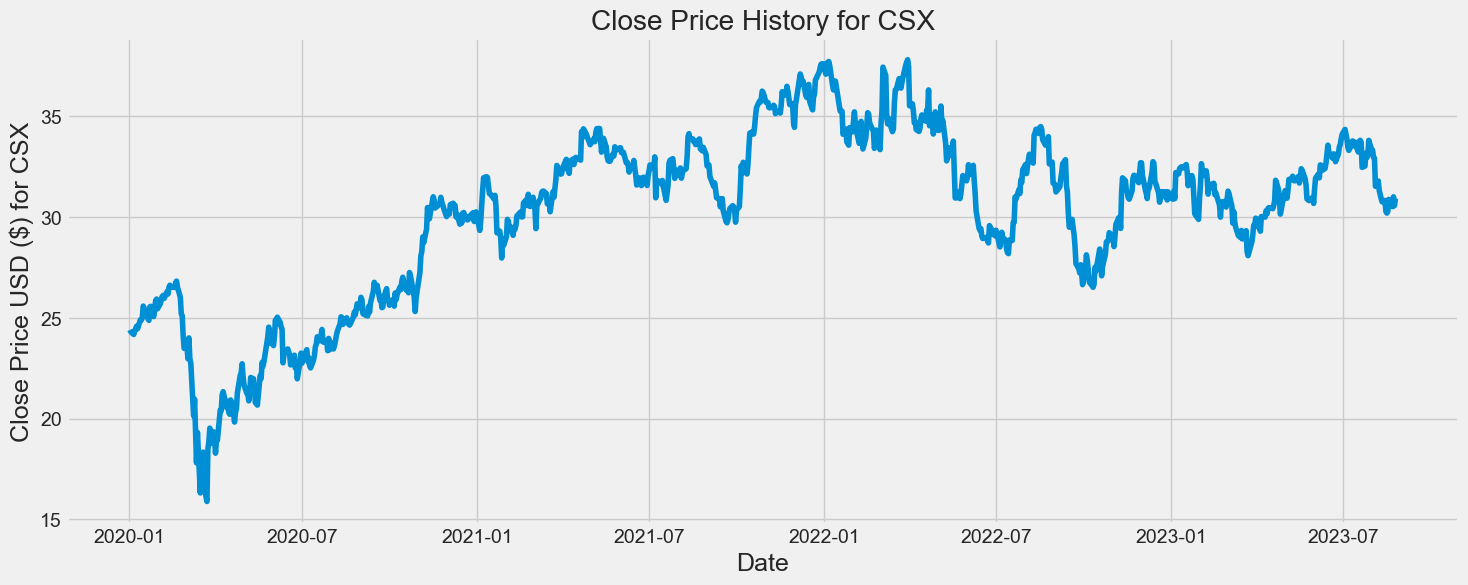

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 43s 44ms/step - loss: 0.0309
Epoch 2/5
814/814 [==============================] - 42s 52ms/step - loss: 0.0073
Epoch 3/5
814/814 [==============================] - 44s 55ms/step - loss: 0.0027
Epoch 4/5
814/814 [==============================] - 44s 54ms/step - loss: 0.0021
Epoch 5/5
2/2 [==============================] - 2s 61ms/step
[[33.001648]
 [32.861504]
 [32.878822]
 [33.048782]
 [33.23078 ]
 [33.39675 ]
 [33.593372]
 [33.76834 ]
 [33.81581 ]
 [33.668224]
 [33.482483]
 [33.41398 ]
 [33.49287 ]
 [33.56752 ]
 [33.58322 ]
 [33.579605]
 [33.403587]
 [33.3627  ]
 [33.478714]
 [33.58017 ]
 [32.825573]
 [32.561943]
 [32.587627]
 [32.70618 ]
 [32.891388]
 [33.161736]
 [33.262627]
 [33.273186]
 [33.151752]
 [33.04596 ]
 [32.41381 ]
 [31.965685]
 [31.61827 ]
 [31.301428]
 [31.137974]
 [30.935038]
 [30.793581]
 [30.624235]
 [30.485142]
 [30.420254]
 [30.486986]
 [30.675592]
 [30.753862]
 [30.83395 ]
 [30.85235 ]]


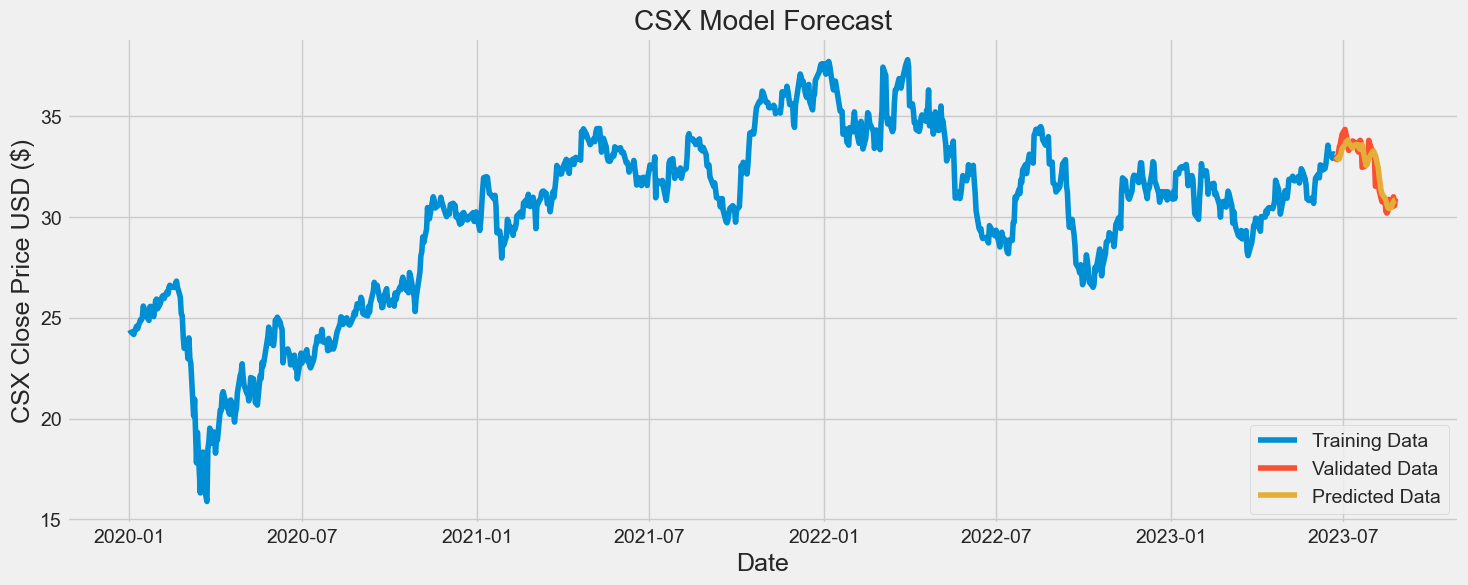

Test RMSE: 0.489


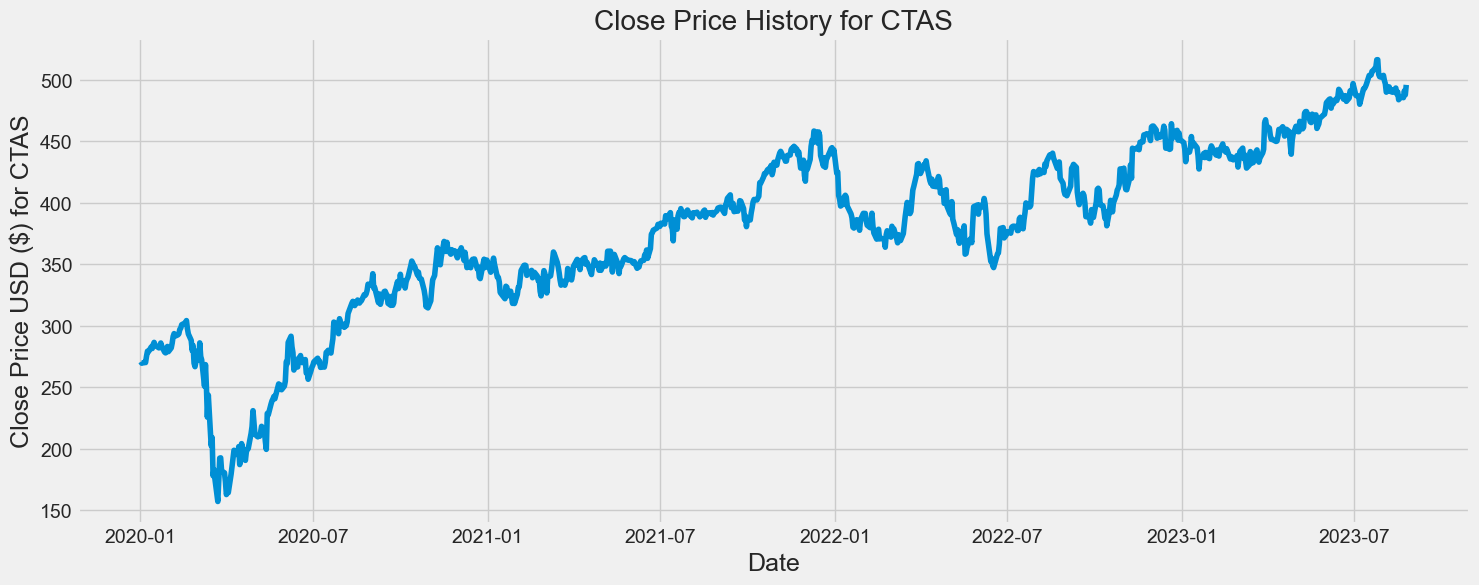

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 43s 45ms/step - loss: 0.0190
Epoch 2/5
814/814 [==============================] - 40s 50ms/step - loss: 0.0019
Epoch 3/5
814/814 [==============================] - 41s 51ms/step - loss: 0.0014
Epoch 4/5
814/814 [==============================] - 41s 51ms/step - loss: 0.0010
Epoch 5/5
2/2 [==============================] - 2s 57ms/step
[[465.0854 ]
 [463.58798]
 [463.5873 ]
 [464.51917]
 [465.05356]
 [465.11917]
 [465.98688]
 [465.84512]
 [464.61655]
 [463.8251 ]
 [463.07208]
 [463.2026 ]
 [465.29242]
 [466.89972]
 [466.7446 ]
 [467.53204]
 [468.64062]
 [469.6554 ]
 [469.80457]
 [470.56696]
 [469.8751 ]
 [472.0547 ]
 [473.17575]
 [473.9398 ]
 [473.3117 ]
 [472.20438]
 [470.86157]
 [469.9889 ]
 [468.83167]
 [467.86624]
 [466.465  ]
 [465.62924]
 [464.73767]
 [464.63138]
 [464.97046]
 [464.77463]
 [464.98038]
 [465.1355 ]
 [465.51828]
 [465.24432]
 [464.1812 ]
 [464.92947]
 [465.29236]
 [465.6851 ]
 [466.13333]]


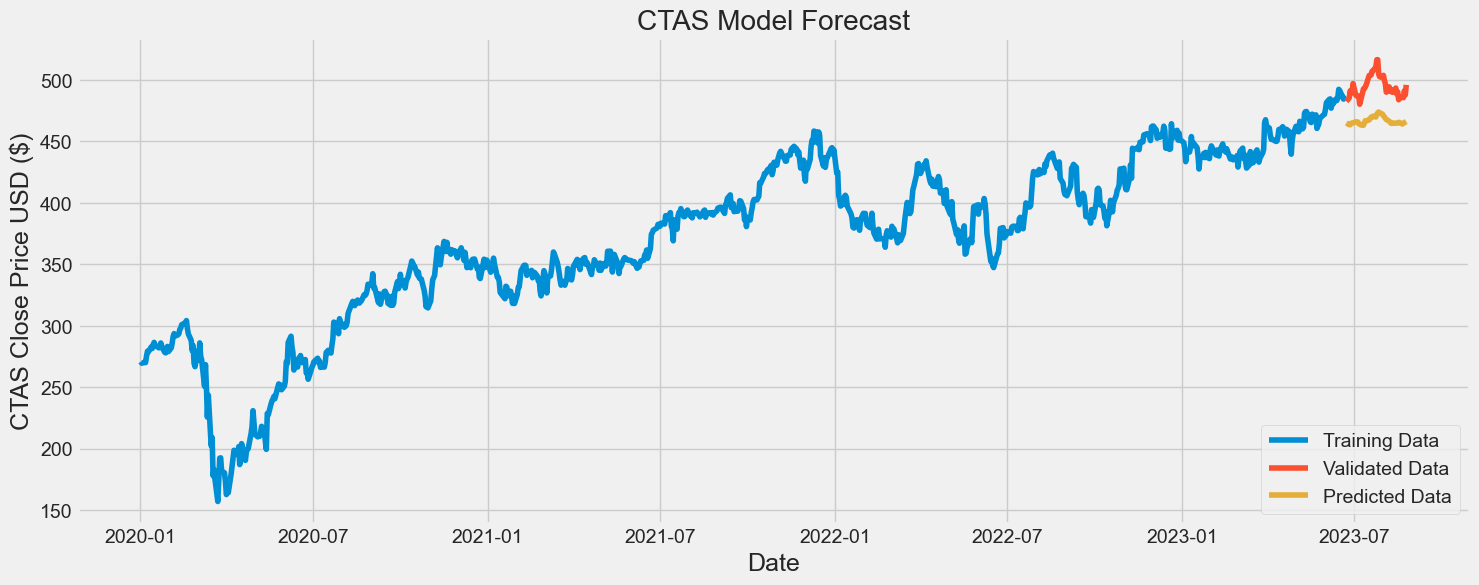

Test RMSE: 28.482


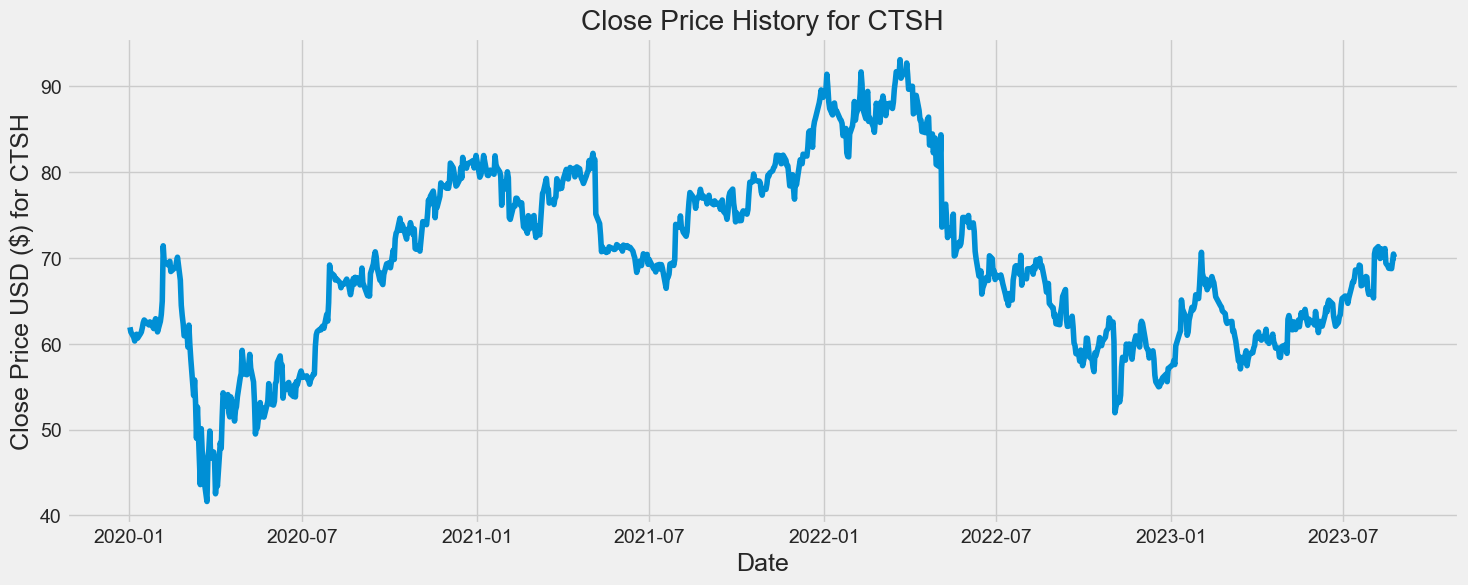

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 47s 48ms/step - loss: 0.0322
Epoch 2/5
814/814 [==============================] - 43s 53ms/step - loss: 0.0042
Epoch 3/5
814/814 [==============================] - 43s 53ms/step - loss: 0.0020
Epoch 4/5
814/814 [==============================] - 43s 53ms/step - loss: 0.0015
Epoch 5/5
2/2 [==============================] - 2s 61ms/step
[[62.57105 ]
 [61.640625]
 [62.125984]
 [62.953438]
 [63.399185]
 [64.039215]
 [65.36208 ]
 [65.58254 ]
 [65.59581 ]
 [65.16214 ]
 [65.29663 ]
 [66.181046]
 [67.13308 ]
 [67.59431 ]
 [67.702255]
 [68.21706 ]
 [68.36511 ]
 [68.81702 ]
 [69.16093 ]
 [67.21373 ]
 [66.41491 ]
 [67.03863 ]
 [67.81997 ]
 [67.886696]
 [67.51517 ]
 [66.24071 ]
 [65.97949 ]
 [65.94243 ]
 [65.39345 ]
 [69.04487 ]
 [70.43259 ]
 [71.09746 ]
 [70.30781 ]
 [70.019806]
 [70.66548 ]
 [70.48395 ]
 [70.447876]
 [69.94208 ]
 [69.44066 ]
 [69.33629 ]
 [68.767426]
 [68.71581 ]
 [69.41268 ]
 [70.16378 ]
 [70.40788 ]]


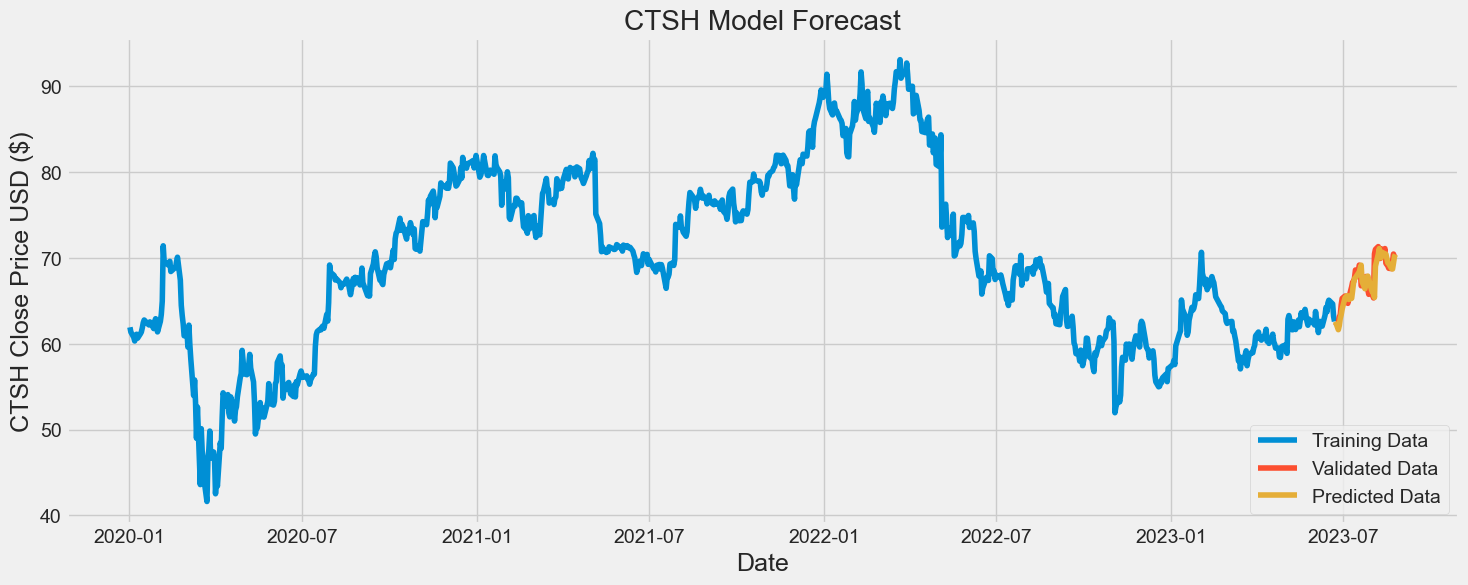

Test RMSE: 1.165


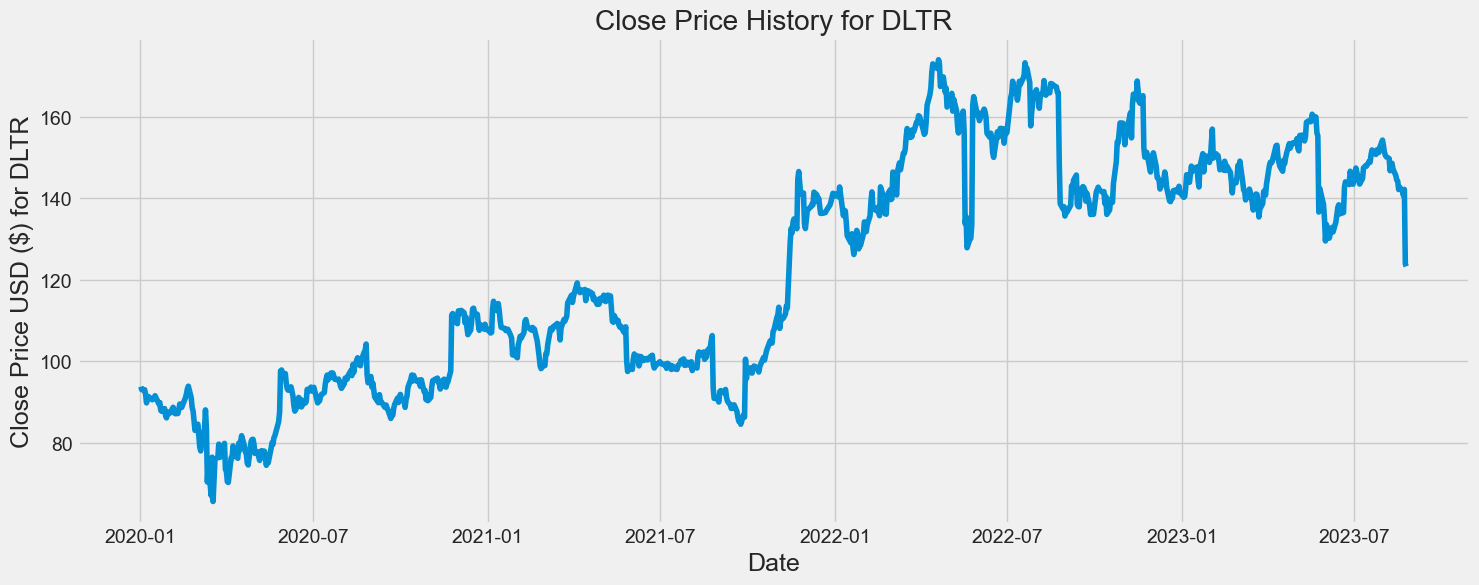

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 43s 45ms/step - loss: 0.0096
Epoch 2/5
814/814 [==============================] - 41s 50ms/step - loss: 0.0037
Epoch 3/5
814/814 [==============================] - 41s 51ms/step - loss: 0.0027
Epoch 4/5
814/814 [==============================] - 41s 51ms/step - loss: 0.0020
Epoch 5/5
2/2 [==============================] - 1s 47ms/step
[[144.16327]
 [144.42659]
 [144.32431]
 [145.2157 ]
 [146.2717 ]
 [145.20573]
 [144.38593]
 [145.99426]
 [146.92166]
 [145.60408]
 [144.71037]
 [145.29364]
 [146.9595 ]
 [148.21848]
 [148.08905]
 [147.85336]
 [148.46777]
 [149.17749]
 [150.09897]
 [150.90582]
 [151.16   ]
 [150.21402]
 [150.61462]
 [151.38742]
 [151.7547 ]
 [151.6606 ]
 [152.31024]
 [152.66095]
 [151.6911 ]
 [150.554  ]
 [150.29654]
 [150.3369 ]
 [148.79028]
 [148.14139]
 [149.52657]
 [148.82648]
 [147.39417]
 [145.58575]
 [145.9021 ]
 [145.00665]
 [143.98543]
 [143.25536]
 [142.04416]
 [142.60223]
 [129.22954]]


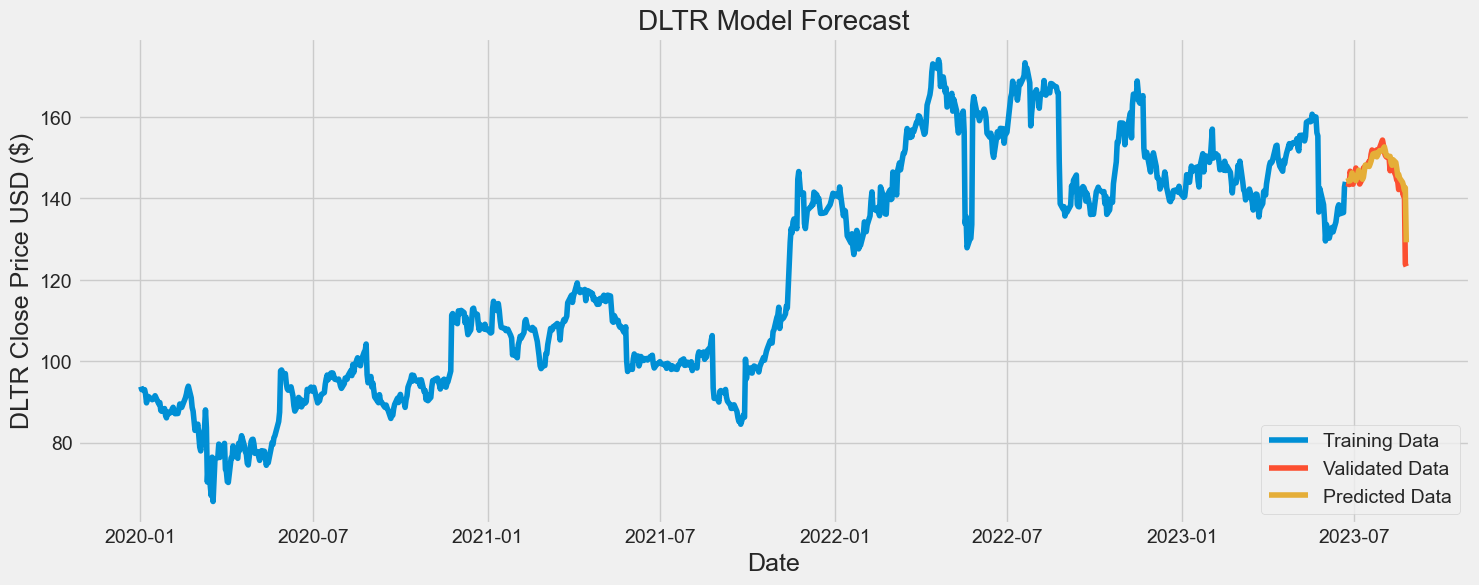

Test RMSE: 3.405


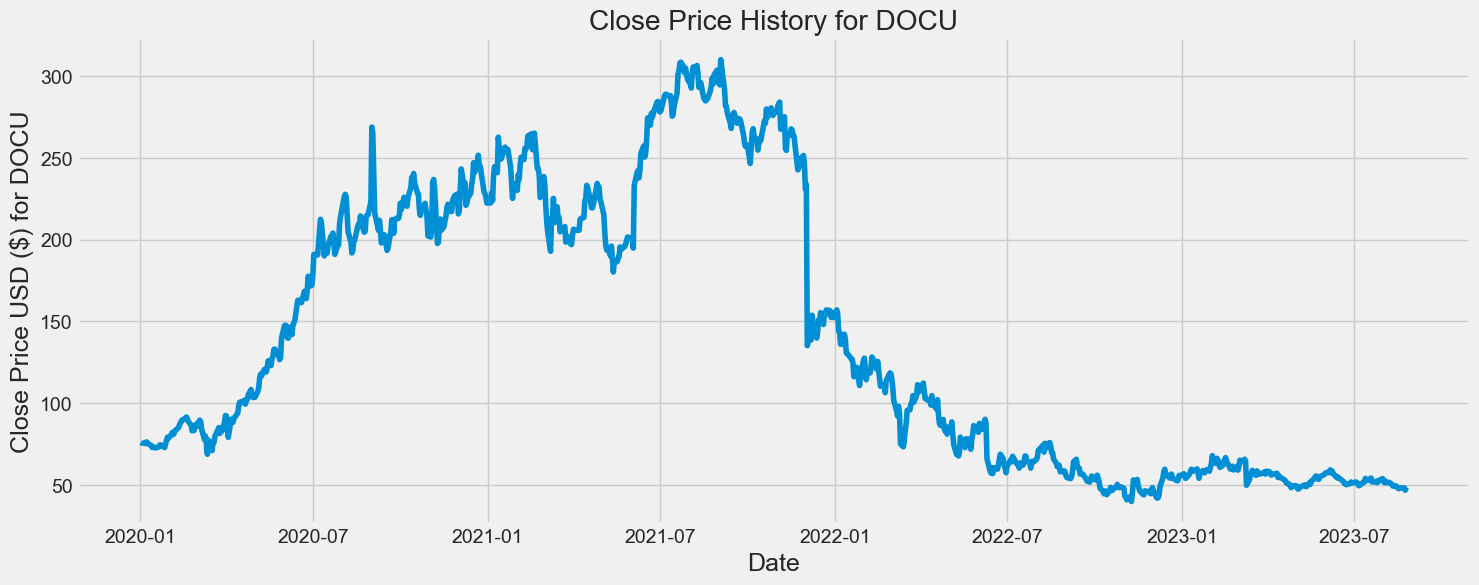

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 45s 47ms/step - loss: 0.0341
Epoch 2/5
814/814 [==============================] - 37s 45ms/step - loss: 0.0047
Epoch 3/5
814/814 [==============================] - 41s 51ms/step - loss: 0.0024
Epoch 4/5
814/814 [==============================] - 43s 52ms/step - loss: 0.0020
Epoch 5/5
2/2 [==============================] - 3s 62ms/step
[[54.794674]
 [54.78739 ]
 [54.783604]
 [54.77912 ]
 [54.77923 ]
 [54.780403]
 [54.780247]
 [54.781803]
 [54.781437]
 [54.775826]
 [54.772873]
 [54.770607]
 [54.77206 ]
 [54.775574]
 [54.77941 ]
 [54.785187]
 [54.788727]
 [54.793304]
 [54.799835]
 [54.800495]
 [54.80017 ]
 [54.801025]
 [54.800056]
 [54.79892 ]
 [54.80018 ]
 [54.802284]
 [54.80699 ]
 [54.809574]
 [54.806087]
 [54.803787]
 [54.802635]
 [54.799786]
 [54.794083]
 [54.790924]
 [54.785152]
 [54.77961 ]
 [54.773216]
 [54.766747]
 [54.761208]
 [54.75386 ]
 [54.74641 ]
 [54.743065]
 [54.739975]
 [54.737892]
 [54.734886]]


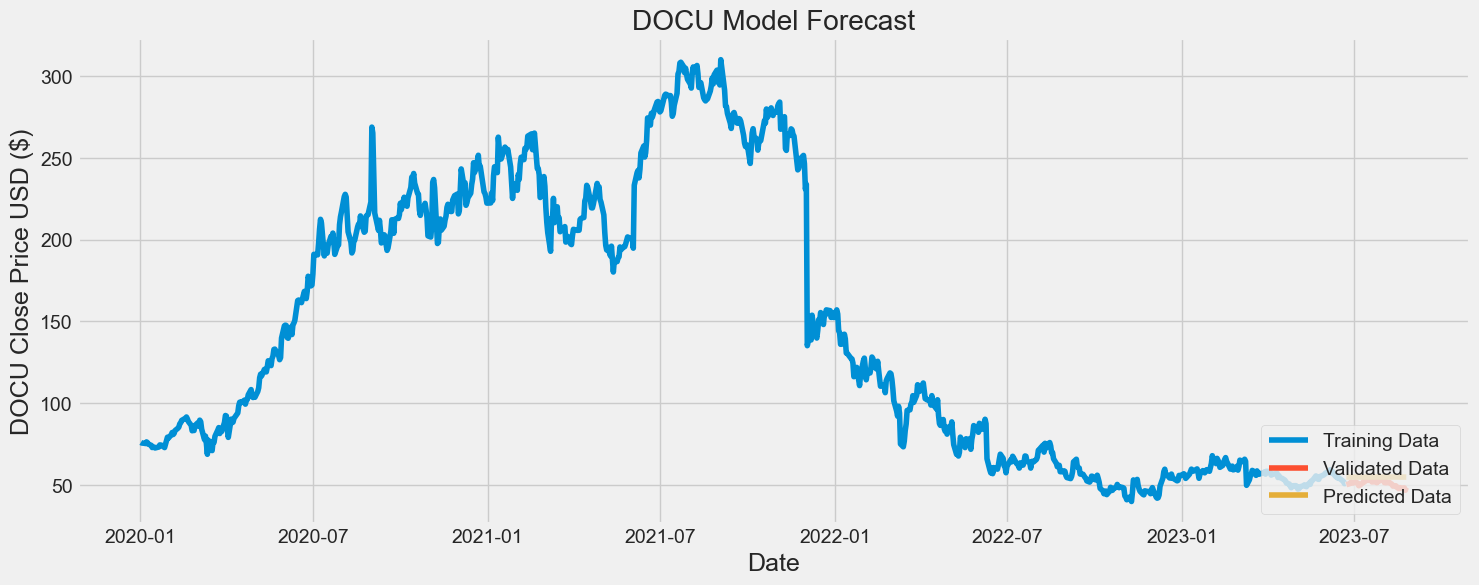

Test RMSE: 4.313


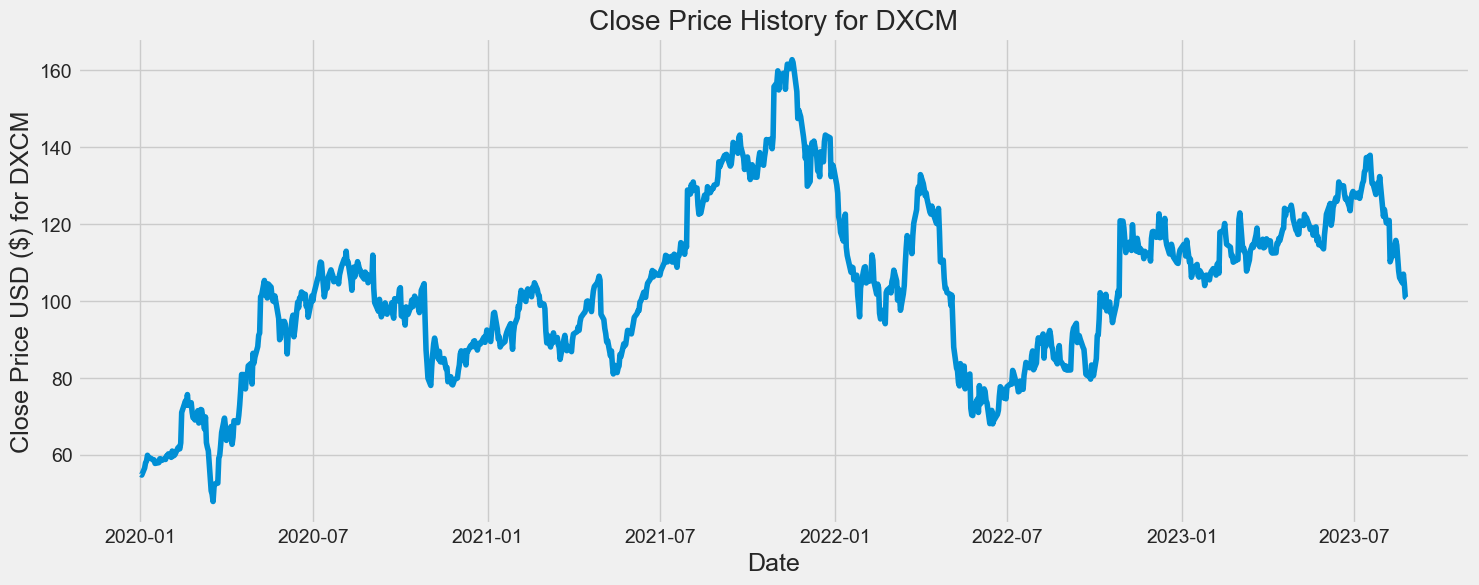

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 51s 55ms/step - loss: 0.0085
Epoch 2/5
814/814 [==============================] - 40s 49ms/step - loss: 0.0026
Epoch 3/5
814/814 [==============================] - 44s 54ms/step - loss: 0.0019
Epoch 4/5
814/814 [==============================] - 44s 54ms/step - loss: 0.0013
Epoch 5/5
2/2 [==============================] - 2s 59ms/step
[[126.16068 ]
 [125.65876 ]
 [123.55646 ]
 [122.51004 ]
 [125.26699 ]
 [126.76455 ]
 [128.7044  ]
 [125.62152 ]
 [126.907745]
 [126.39024 ]
 [126.14422 ]
 [129.39928 ]
 [130.45912 ]
 [132.40536 ]
 [133.34154 ]
 [135.59756 ]
 [136.3689  ]
 [136.49358 ]
 [134.10074 ]
 [131.60968 ]
 [130.81369 ]
 [128.01158 ]
 [128.81305 ]
 [129.59552 ]
 [129.06749 ]
 [133.6306  ]
 [125.80327 ]
 [122.30919 ]
 [121.55066 ]
 [120.92477 ]
 [119.29012 ]
 [119.58213 ]
 [108.40391 ]
 [108.7939  ]
 [111.22186 ]
 [108.912796]
 [112.36873 ]
 [113.20878 ]
 [110.00601 ]
 [105.980896]
 [103.411255]
 [102.138565]
 [103.625

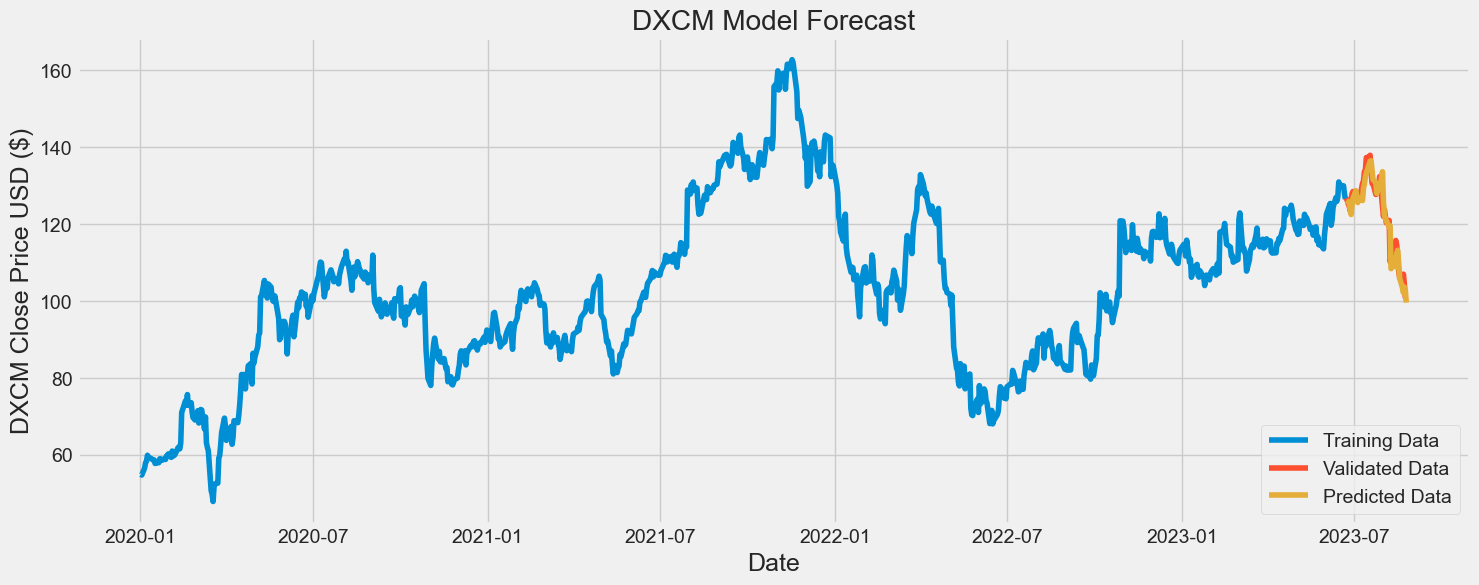

Test RMSE: 3.169


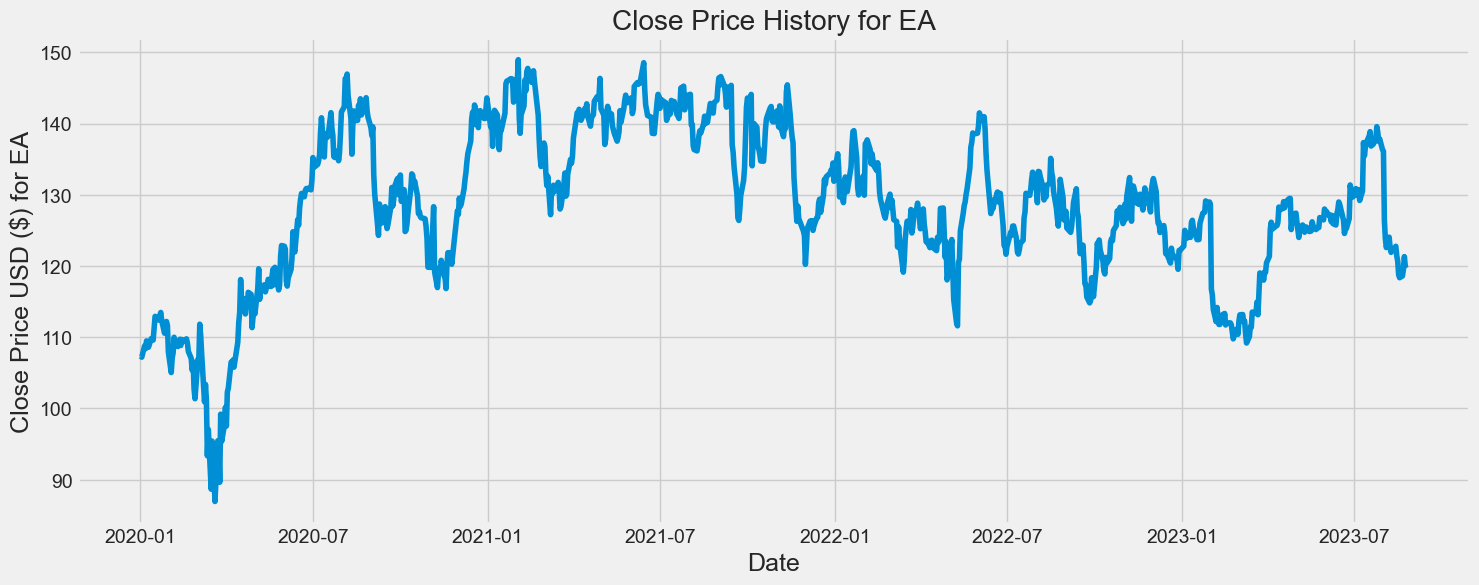

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 47s 51ms/step - loss: 0.0100
Epoch 2/5
814/814 [==============================] - 38s 46ms/step - loss: 0.0037
Epoch 3/5
814/814 [==============================] - 42s 52ms/step - loss: 0.0025
Epoch 4/5
814/814 [==============================] - 42s 52ms/step - loss: 0.0020
Epoch 5/5
2/2 [==============================] - 2s 56ms/step
[[124.51605 ]
 [124.609116]
 [125.86896 ]
 [130.12297 ]
 [131.31671 ]
 [129.18823 ]
 [129.40509 ]
 [129.88202 ]
 [129.13481 ]
 [129.46408 ]
 [129.07677 ]
 [129.955   ]
 [135.65096 ]
 [135.86633 ]
 [135.08273 ]
 [135.51358 ]
 [137.50183 ]
 [137.12137 ]
 [136.03505 ]
 [135.84784 ]
 [135.8592  ]
 [136.42558 ]
 [137.27016 ]
 [136.73285 ]
 [136.56804 ]
 [136.54367 ]
 [135.00699 ]
 [134.82779 ]
 [122.49926 ]
 [123.02062 ]
 [122.100266]
 [122.693146]
 [121.81172 ]
 [121.31181 ]
 [121.98199 ]
 [121.55939 ]
 [122.44703 ]
 [121.671616]
 [120.76599 ]
 [119.535164]
 [118.79944 ]
 [118.81064 ]
 [119.508

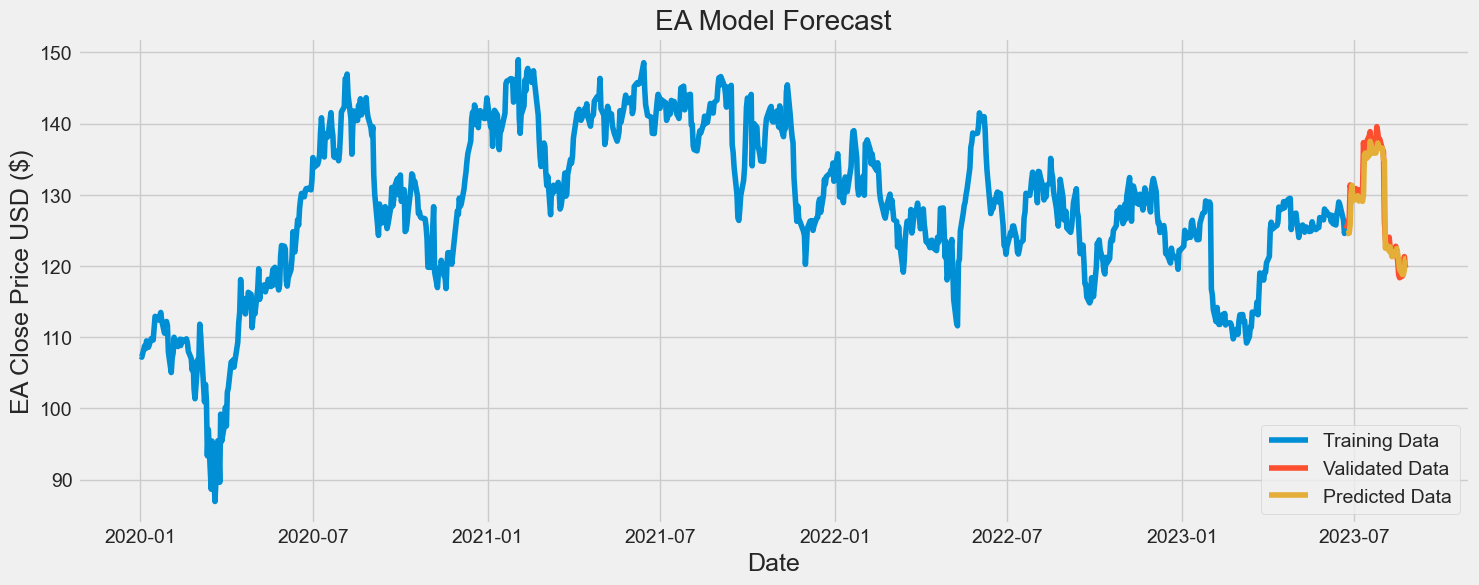

Test RMSE: 2.262


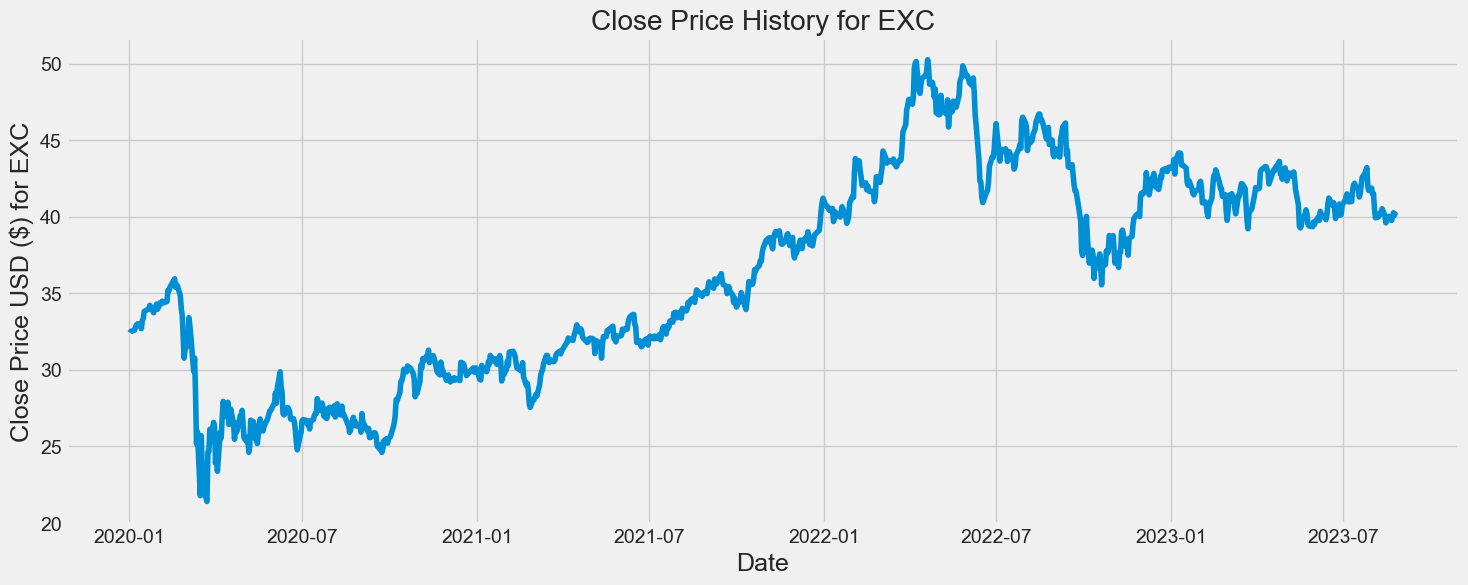

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 51s 54ms/step - loss: 0.0074
Epoch 2/5
814/814 [==============================] - 42s 52ms/step - loss: 0.0021
Epoch 3/5
814/814 [==============================] - 42s 51ms/step - loss: 0.0016
Epoch 4/5
814/814 [==============================] - 44s 55ms/step - loss: 0.0014
Epoch 5/5
2/2 [==============================] - 2s 58ms/step
[[40.08651 ]
 [39.783596]
 [39.787292]
 [40.128258]
 [40.063293]
 [39.66517 ]
 [39.89126 ]
 [40.25866 ]
 [40.70146 ]
 [40.691563]
 [40.56989 ]
 [40.50682 ]
 [40.77883 ]
 [41.262867]
 [41.568268]
 [41.54516 ]
 [41.372864]
 [41.049454]
 [41.023033]
 [41.32434 ]
 [41.89556 ]
 [42.313873]
 [42.3609  ]
 [42.414864]
 [42.03949 ]
 [41.50251 ]
 [41.23532 ]
 [41.180088]
 [40.99424 ]
 [40.51541 ]
 [39.902058]
 [39.504898]
 [39.372494]
 [39.610413]
 [39.86482 ]
 [39.954895]
 [39.696625]
 [39.277504]
 [39.169357]
 [39.389137]
 [39.59244 ]
 [39.47538 ]
 [39.4187  ]
 [39.64389 ]
 [39.810204]]


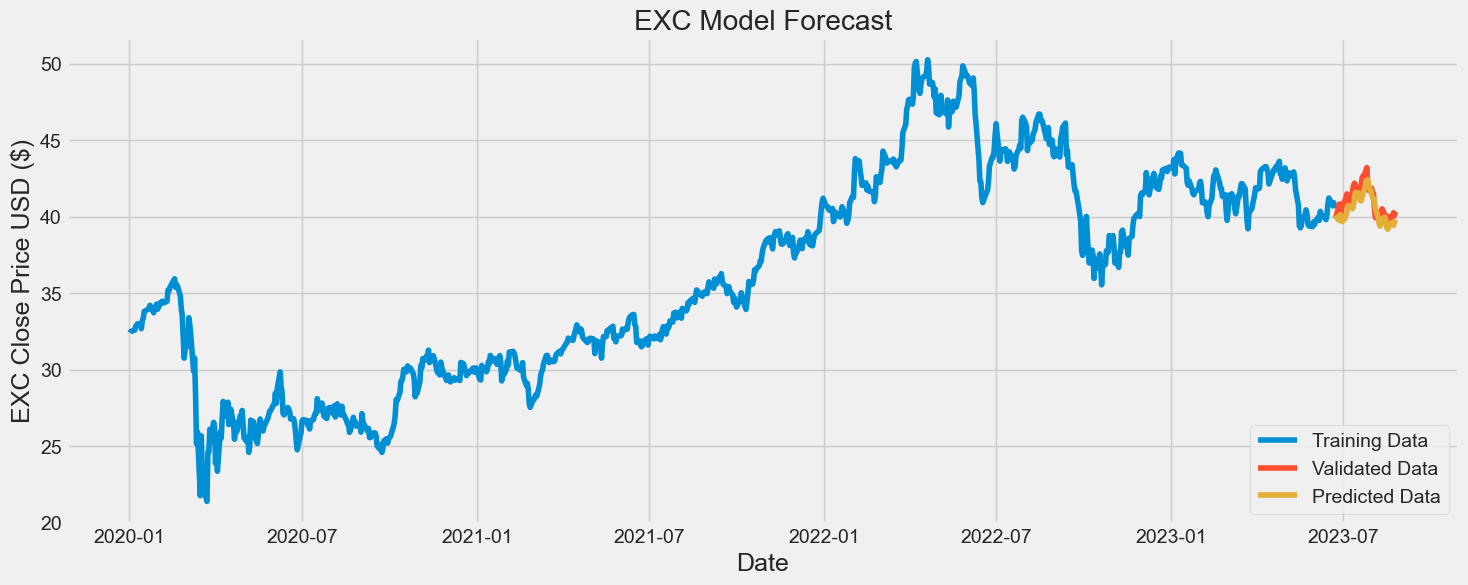

Test RMSE: 0.680


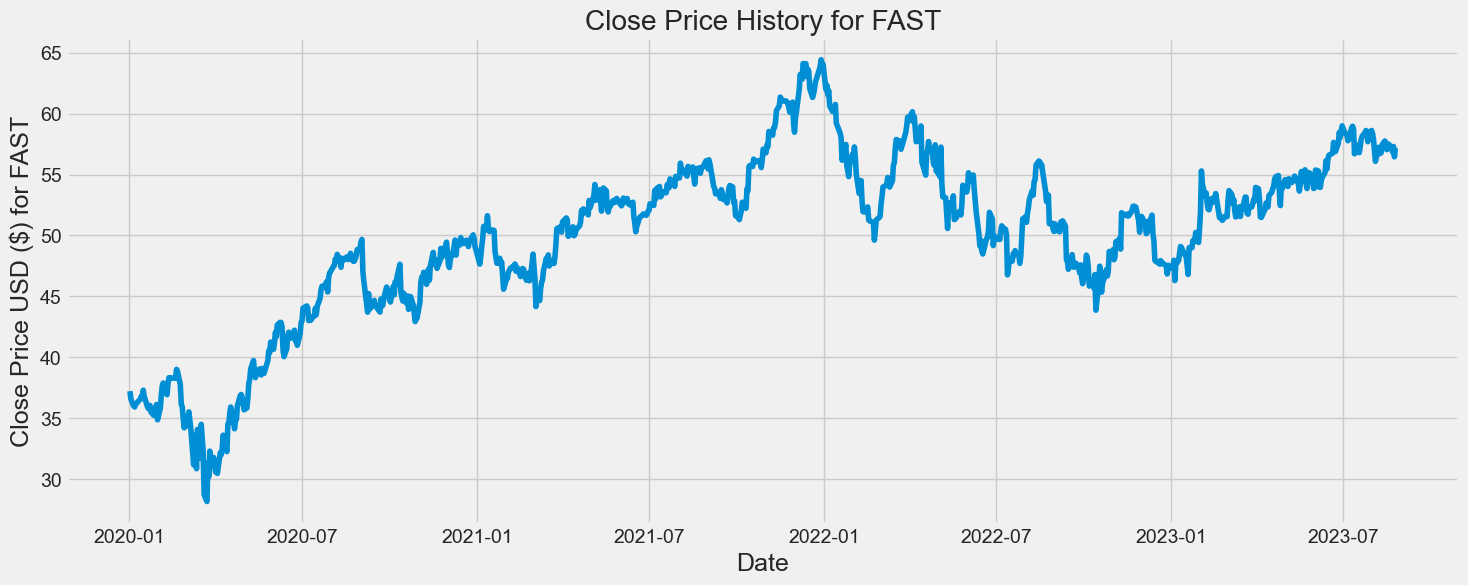

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 49s 53ms/step - loss: 0.0070
Epoch 2/5
814/814 [==============================] - 39s 48ms/step - loss: 0.0023
Epoch 3/5
814/814 [==============================] - 40s 50ms/step - loss: 0.0016
Epoch 4/5
814/814 [==============================] - 42s 51ms/step - loss: 0.0015
Epoch 5/5
2/2 [==============================] - 2s 52ms/step
[[57.834396]
 [57.407913]
 [57.843018]
 [58.398468]
 [58.51027 ]
 [58.679733]
 [59.057724]
 [59.045525]
 [58.74112 ]
 [58.452164]
 [58.51928 ]
 [58.844288]
 [59.132828]
 [59.018303]
 [58.05224 ]
 [58.0418  ]
 [58.22451 ]
 [57.868053]
 [57.678085]
 [57.93678 ]
 [57.855278]
 [58.671753]
 [58.832073]
 [58.64316 ]
 [58.333546]
 [58.607445]
 [58.641853]
 [58.80412 ]
 [58.579025]
 [57.899868]
 [57.364334]
 [57.531136]
 [57.323273]
 [57.352604]
 [57.453407]
 [57.483658]
 [57.713963]
 [57.820984]
 [57.756012]
 [57.512016]
 [57.676346]
 [57.66747 ]
 [57.584137]
 [57.639103]
 [57.49446 ]]


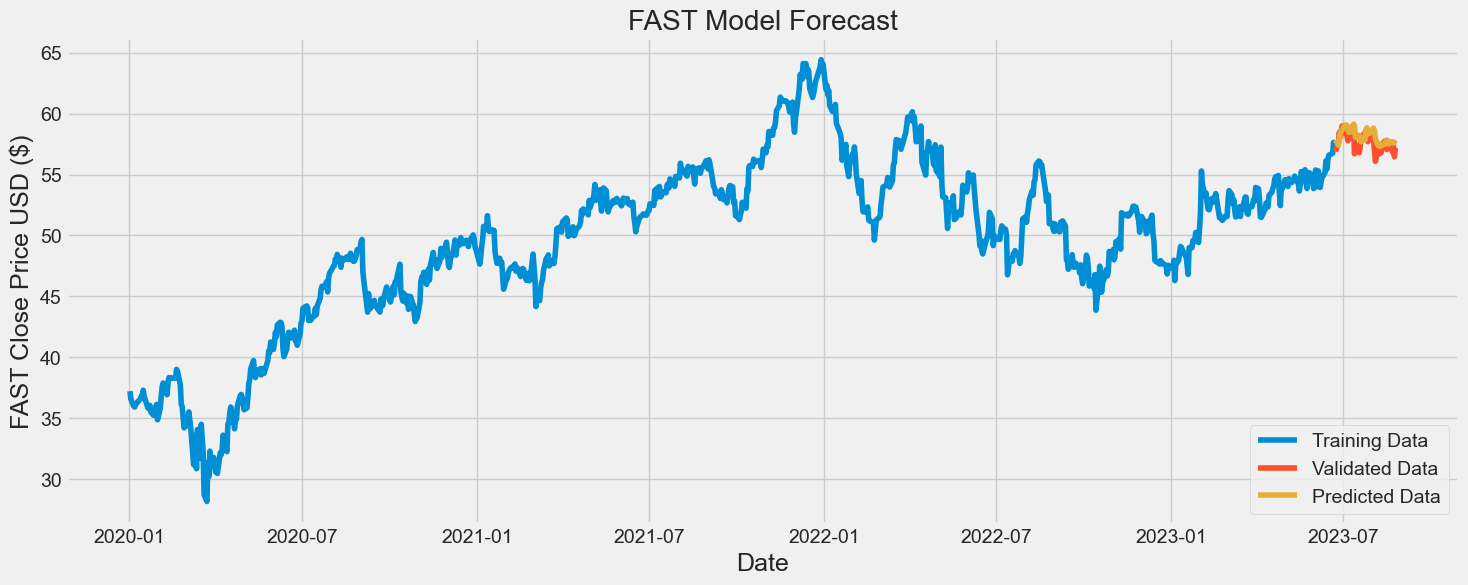

Test RMSE: 0.758


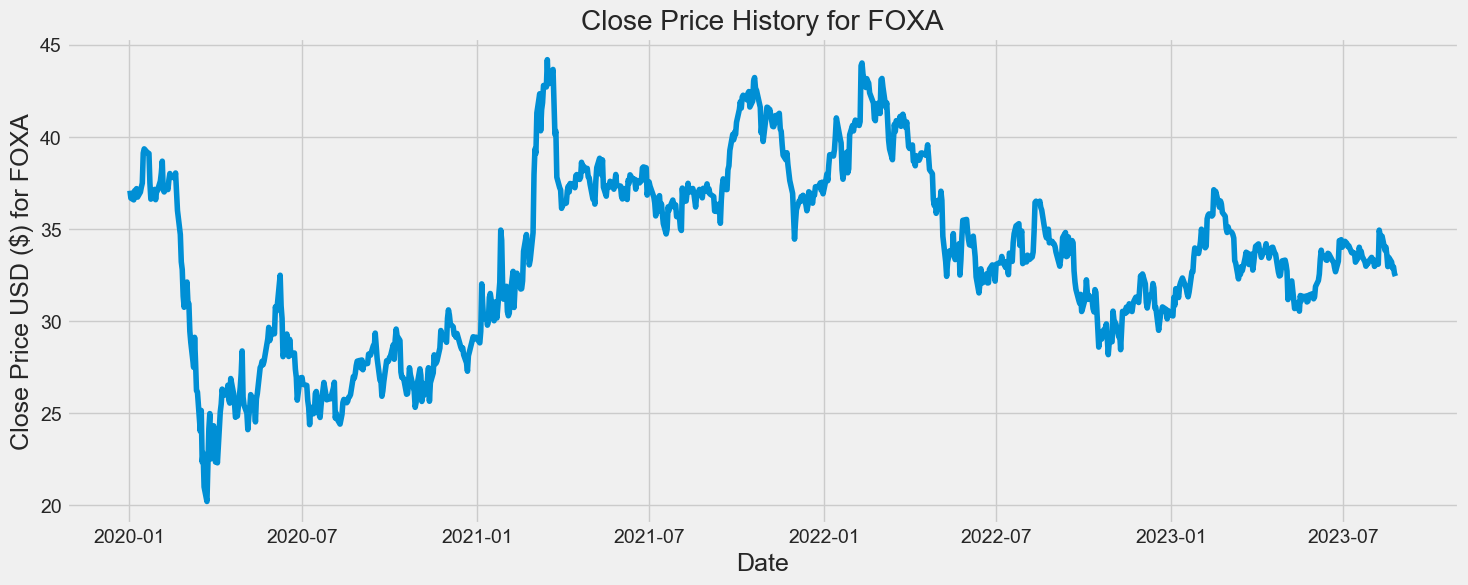

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 47s 50ms/step - loss: 0.0128
Epoch 2/5
814/814 [==============================] - 41s 50ms/step - loss: 0.0030
Epoch 3/5
814/814 [==============================] - 37s 45ms/step - loss: 0.0022
Epoch 4/5
814/814 [==============================] - 43s 52ms/step - loss: 0.0021
Epoch 5/5
2/2 [==============================] - 3s 62ms/step
[[32.882076]
 [32.615376]
 [33.165306]
 [34.18896 ]
 [34.431164]
 [34.522522]
 [34.463684]
 [34.31898 ]
 [34.457047]
 [33.99266 ]
 [34.10834 ]
 [33.21167 ]
 [33.656723]
 [33.889206]
 [33.350624]
 [33.084064]
 [33.3251  ]
 [34.097214]
 [33.78615 ]
 [33.72915 ]
 [33.61113 ]
 [33.22179 ]
 [32.99006 ]
 [33.056683]
 [33.231186]
 [33.10462 ]
 [33.465965]
 [33.344807]
 [33.396336]
 [33.02778 ]
 [33.111008]
 [33.12276 ]
 [34.650368]
 [34.30347 ]
 [34.4648  ]
 [34.834377]
 [34.29528 ]
 [33.99743 ]
 [34.088352]
 [33.22077 ]
 [33.2439  ]
 [33.3619  ]
 [32.92351 ]
 [32.91831 ]
 [32.53753 ]]


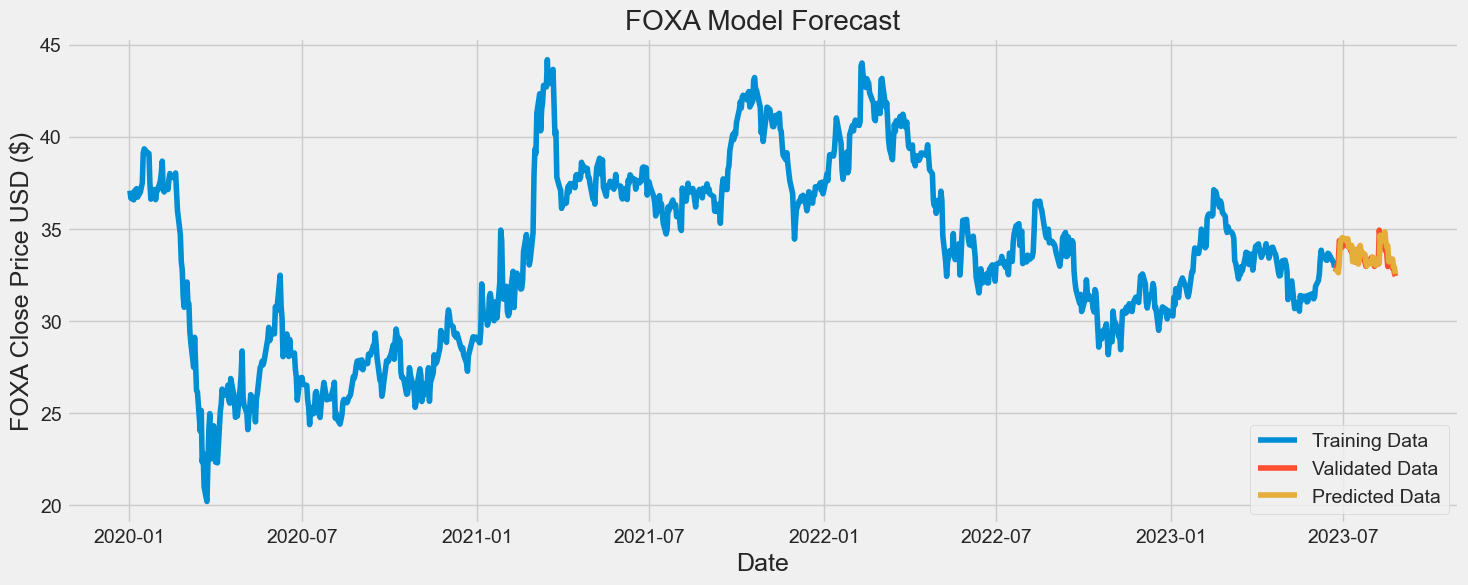

Test RMSE: 0.484


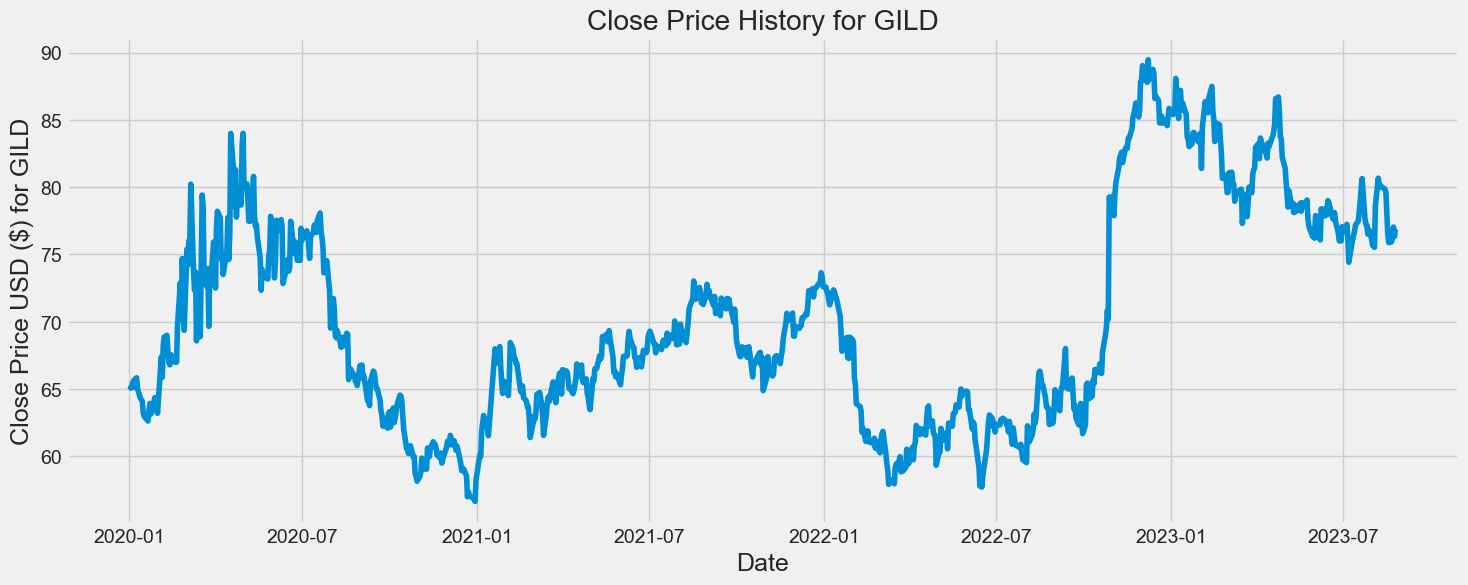

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 50s 54ms/step - loss: 0.0142
Epoch 2/5
814/814 [==============================] - 44s 54ms/step - loss: 0.0037
Epoch 3/5
814/814 [==============================] - 40s 49ms/step - loss: 0.0028
Epoch 4/5
814/814 [==============================] - 44s 54ms/step - loss: 0.0022
Epoch 5/5
2/2 [==============================] - 2s 59ms/step
[[79.50745 ]
 [79.53107 ]
 [78.35432 ]
 [77.69937 ]
 [77.21744 ]
 [77.175026]
 [77.87584 ]
 [77.8353  ]
 [78.2607  ]
 [78.01567 ]
 [76.60968 ]
 [76.259544]
 [76.77583 ]
 [77.69696 ]
 [78.1509  ]
 [78.56341 ]
 [78.734146]
 [79.50706 ]
 [80.32538 ]
 [81.4426  ]
 [82.21352 ]
 [80.67385 ]
 [79.16078 ]
 [78.57832 ]
 [78.58703 ]
 [78.32597 ]
 [77.8295  ]
 [77.10841 ]
 [76.962524]
 [76.71221 ]
 [79.09844 ]
 [80.710754]
 [81.496376]
 [82.10094 ]
 [82.263885]
 [82.07468 ]
 [82.022835]
 [81.76332 ]
 [81.048386]
 [79.22347 ]
 [77.6305  ]
 [76.918015]
 [77.0205  ]
 [78.5276  ]
 [78.378845]]


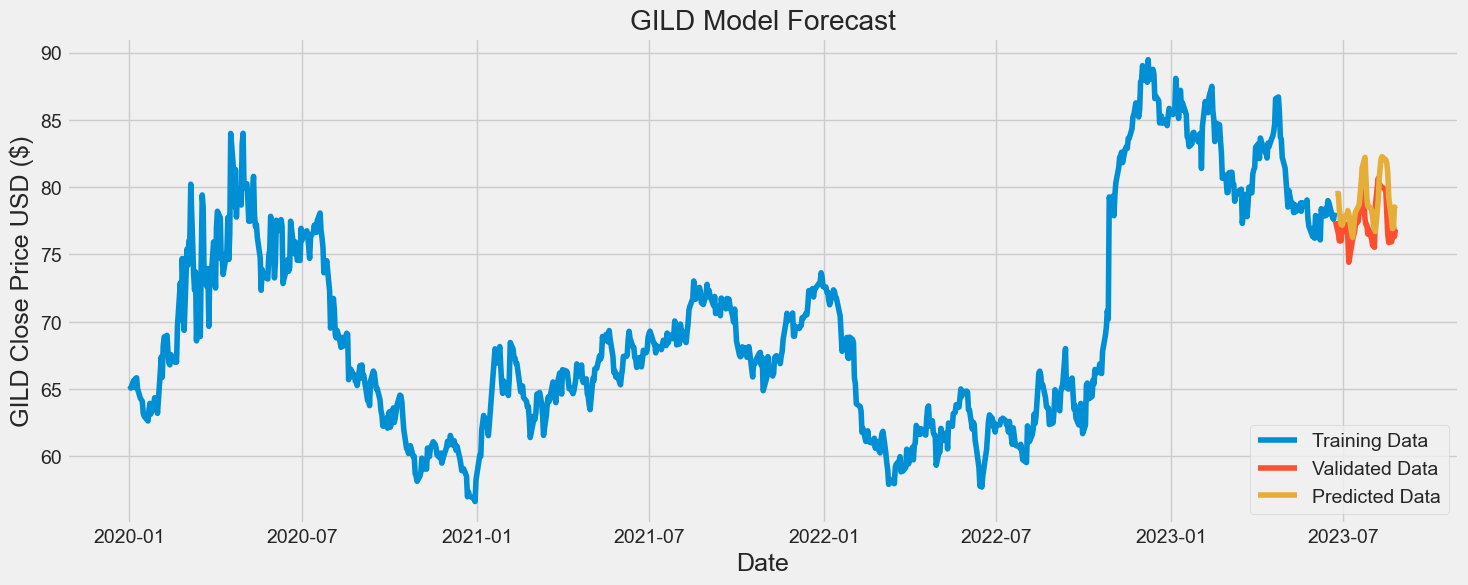

Test RMSE: 2.047


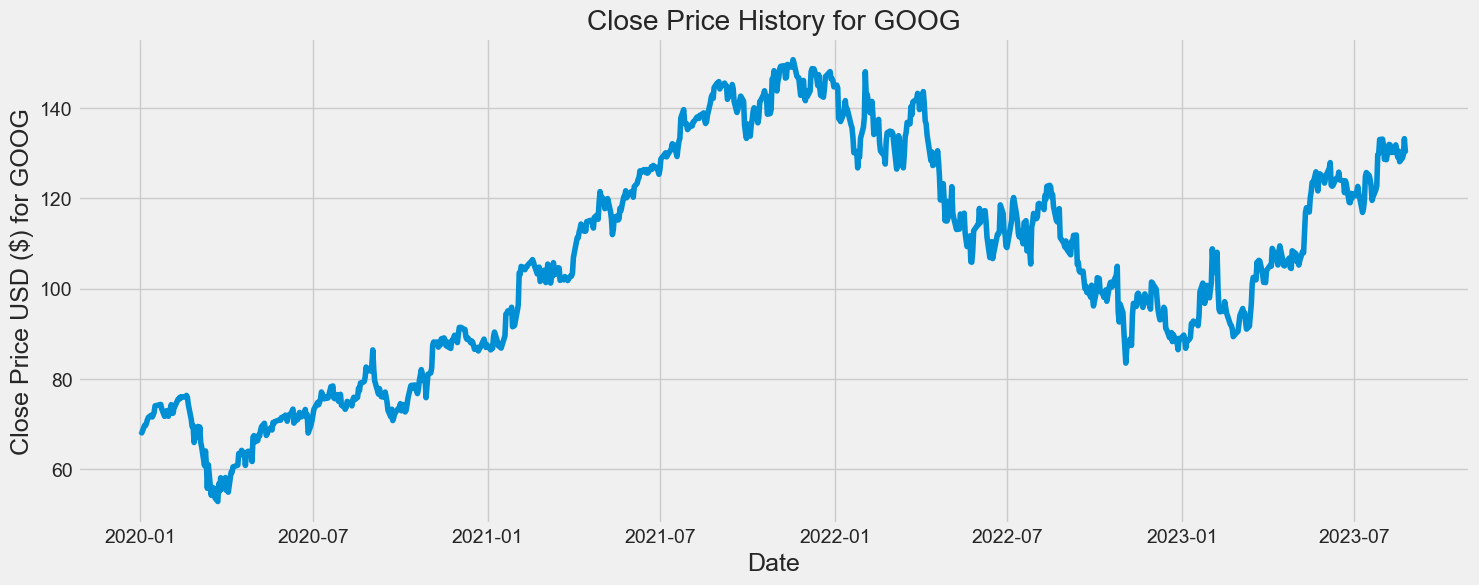

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 50s 53ms/step - loss: 0.0100
Epoch 2/5
814/814 [==============================] - 44s 54ms/step - loss: 0.0031
Epoch 3/5
814/814 [==============================] - 39s 48ms/step - loss: 0.0021
Epoch 4/5
814/814 [==============================] - 43s 53ms/step - loss: 0.0017
Epoch 5/5
2/2 [==============================] - 2s 55ms/step
[[126.60389 ]
 [126.41822 ]
 [125.31828 ]
 [123.31033 ]
 [123.00105 ]
 [123.376686]
 [124.348755]
 [124.510345]
 [125.09286 ]
 [124.79968 ]
 [124.63794 ]
 [122.83007 ]
 [121.47103 ]
 [122.41651 ]
 [125.393394]
 [128.4569  ]
 [129.75021 ]
 [129.34296 ]
 [128.59792 ]
 [126.74597 ]
 [125.03377 ]
 [125.85029 ]
 [126.50249 ]
 [130.70833 ]
 [133.51099 ]
 [135.05151 ]
 [135.80408 ]
 [135.51175 ]
 [134.24515 ]
 [133.34384 ]
 [133.36502 ]
 [134.16345 ]
 [134.85023 ]
 [135.09192 ]
 [135.25052 ]
 [134.79475 ]
 [134.94814 ]
 [135.18887 ]
 [134.7767  ]
 [135.04129 ]
 [134.40878 ]
 [133.90057 ]
 [134.283

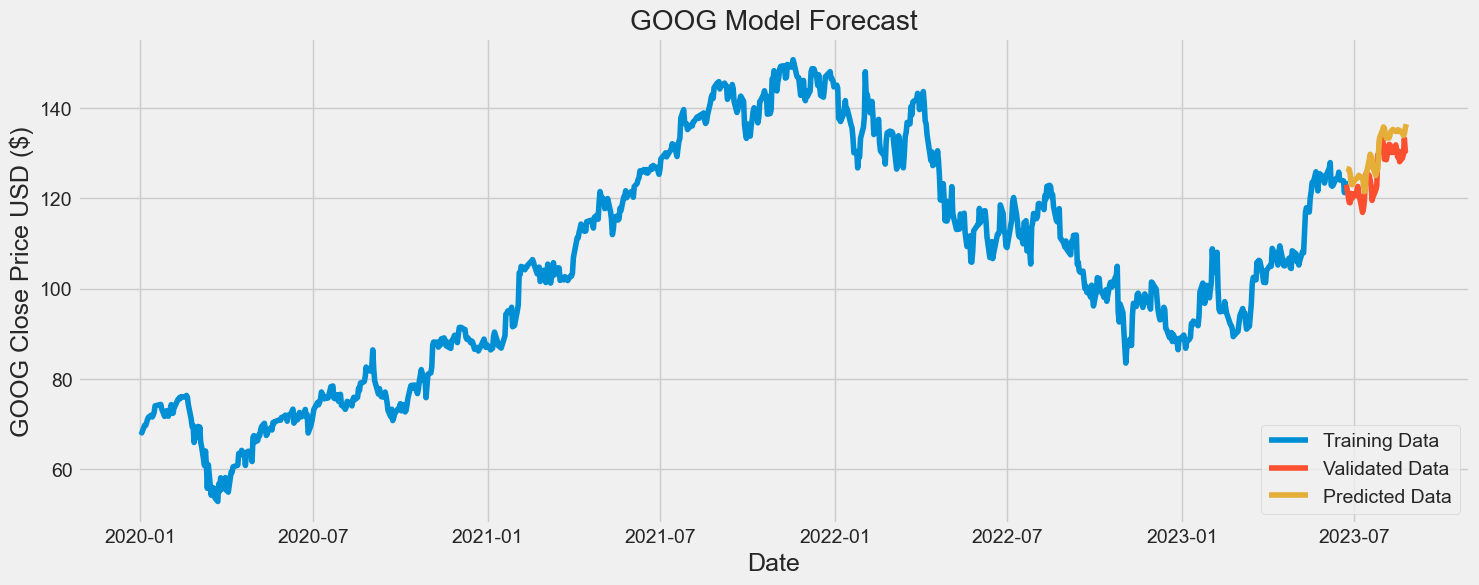

Test RMSE: 4.620


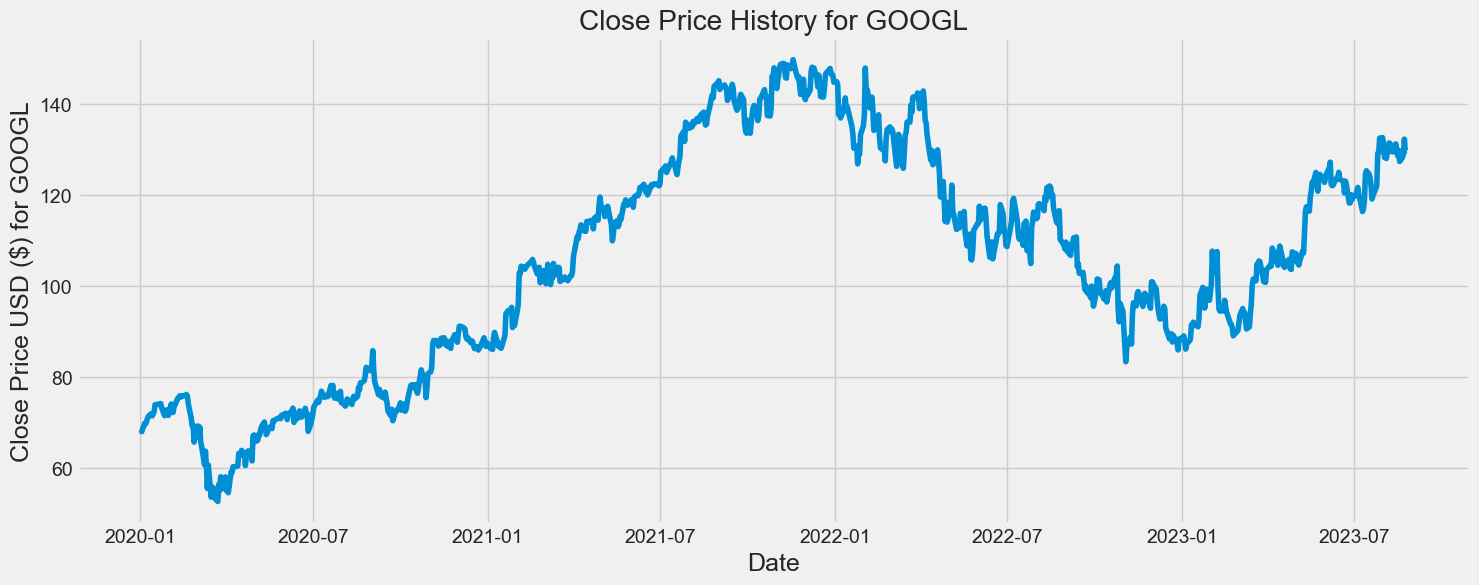

(814, 60, 5)
Epoch 1/5
814/814 [==============================] - 50s 54ms/step - loss: 0.0099
Epoch 2/5
814/814 [==============================] - 44s 54ms/step - loss: 0.0028
Epoch 3/5
814/814 [==============================] - 40s 49ms/step - loss: 0.0020
Epoch 4/5
814/814 [==============================] - 45s 55ms/step - loss: 0.0016
Epoch 5/5
2/2 [==============================] - 2s 56ms/step
[[118.200134]
 [118.052124]
 [117.03743 ]
 [115.231735]
 [114.97023 ]
 [115.28015 ]
 [115.97939 ]
 [116.229355]
 [116.72861 ]
 [116.519516]
 [116.50651 ]
 [114.93132 ]
 [113.793076]
 [114.577896]
 [117.34367 ]
 [120.41757 ]
 [121.9816  ]
 [121.55226 ]
 [120.46948 ]
 [118.49942 ]
 [116.85066 ]
 [117.84068 ]
 [118.33412 ]
 [122.53621 ]
 [125.68579 ]
 [127.439896]
 [128.25804 ]
 [127.9026  ]
 [126.24988 ]
 [125.0699  ]
 [125.02771 ]
 [125.99919 ]
 [126.854065]
 [127.141525]
 [127.27716 ]
 [126.63164 ]
 [126.72255 ]
 [127.00122 ]
 [126.42279 ]
 [126.64755 ]
 [125.84044 ]
 [125.20619 ]
 [125.536

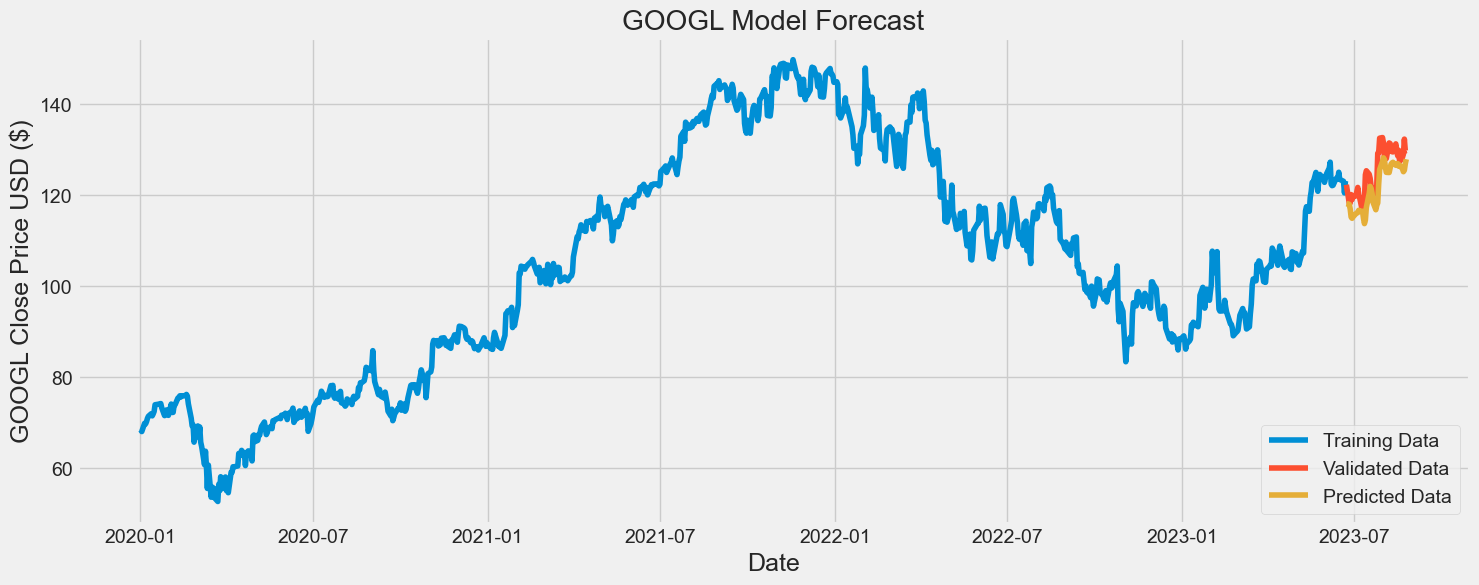

Test RMSE: 4.455
{'ADBE': 9.824667515314566, 'ADI': 5.20034383486985, 'ADP': 5.476327450791446, 'ADSK': 4.945483145639255, 'AEP': 1.148347247911063, 'ALGN': 15.10405552975967, 'AMAT': 3.3158426450877765, 'AMD': 3.433574445295322, 'AMGN': 3.5349707645938584, 'AMZN': 3.450929948993616, 'ANSS': 9.470956398775286, 'ASML': 25.253533026582836, 'ATVI': 2.2168565912478715, 'AVGO': 44.33879413578694, 'BIDU': 5.9626061875540115, 'BIIB': 4.146477439006295, 'BKNG': 257.5118927844485, 'CDNS': 10.59204927685128, 'CDW': 5.736314451908647, 'CHKP': 2.069042326402675, 'CHTR': 10.867902394319323, 'CMCSA': 1.1384213054427825, 'COST': 7.86647151577777, 'CPRT': 1.0794395026514618, 'CRWD': 3.9361063686723807, 'CSCO': 0.8792845562105419, 'CSX': 0.4893952260041457, 'CTAS': 28.482146462646668, 'CTSH': 1.1649643541347479, 'DLTR': 3.4046851830673814, 'DOCU': 4.312909217435648, 'DXCM': 3.1685655855331603, 'EA': 2.262097012328351, 'EXC': 0.680419458002995, 'FAST': 0.7576775914947392, 'FOXA': 0.48409600761070026, 'G

In [ ]:
stock_list = ['AMZN','TSLA','NVDA','GOOG','MSFT']
# Symbols = ['AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'ALGN', 'AMAT',
#     'AMD', 'AMGN', 'AMZN', 'ANSS', 'ASML', 'ATVI', 'AVGO', 'BIDU',
#     'BIIB', 'BKNG', 'CDNS', 'CDW', 'CERN', 'CHKP', 'CHTR', 'CMCSA',
#     'COST', 'CPRT', 'CRWD', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'DLTR',
#     'DOCU', 'DXCM', 'EA', 'EBAY', 'EXC', 'FAST', 'FB', 'FISV', 'FOX',
#     'FOXA', 'GILD', 'GOOG', 'GOOGL', 'HON', 'IDXX', 'ILMN', 'INCY',
#     'INTC', 'INTU', 'ISRG', 'JD', 'KDP', 'KHC', 'KLAC', 'LRCX', 'LULU',
#     'MAR', 'MCHP', 'MDLZ', 'MELI', 'MNST', 'MRNA', 'MRVL', 'MSFT',
#     'MTCH', 'MU', 'NFLX', 'NTES', 'NVDA', 'NXPI', 'OKTA', 'ORLY',
#     'PAYX', 'PCAR', 'PDD', 'PEP', 'PTON', 'PYPL', 'QCOM', 'REGN',
#     'ROST', 'SBUX', 'SGEN', 'SIRI', 'SNPS', 'SPLK', 'SWKS', 'TCOM',
#     'TEAM', 'TMUS', 'TSLA', 'TXN', 'VRSK', 'VRSN', 'VRTX', 'WBA',
#     'WDAY', 'XEL', 'XLNX', 'ZM'
# ]
# Symbols = ['AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'ALGN', 'AMAT',
#     'AMD', 'AMGN', 'AMZN', 'ANSS', 'ASML', 'ATVI', 'AVGO', 'BIDU',
#     'BIIB', 'BKNG', 'CDNS', 'CDW', 'CERN', 'CHKP', 'CHTR', 'CMCSA',
#     'COST', 'CPRT', 'CRWD', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'DLTR',
#     'DOCU', 'DXCM', 'EA', 'EBAY', 'EXC', 'FAST', 'FB', 'FISV', 'FOX',
#     'FOXA', 'GILD', 'GOOG', 'GOOGL']
TEST_DATA_LENGTH = 60
start_date = '2020-01-01'
error_scores = {}
print("Let us evaluate for all of NASDAQ")
for stock_symbol, stock_data in all_stocks.items():
#     df = collect_data(stock,start_date) #Collect the data
    df = stock_data
    if df.shape[0] != 0:
        plot_close_val(df, 'Close', stock_symbol) # Plot the Closing Price
        #plot_close_val(df, 'Open', stock) # Plot the Opening Price
        #print(df.head()) # Print Dataframe check
        training_data_df, training_dataset_np, training_data_len = build_training_dataset(df) #Build the Training Dataset
        dataset=training_dataset_np
        data=training_data_df
        scaler, scaled_data, closing_price_scaling_params = scale_the_data(training_dataset_np) #Scale the data
        x_train,y_train = split_train_dataset(training_data_len) #split the data
        lstm_model = build_lstm_model(x_train,y_train) #build the LSTM model
        x_test,y_test, predictions, rmse, check  = create_testing_data_set(lstm_model,scaler,training_data_len, TEST_DATA_LENGTH ) #create testing dataset and predictions
        valid = plot_predictions(stock_symbol,data,training_data_len) #plot predictions
        valid   # Show the valid and predicted prices
        rmse = sqrt(mean_squared_error(valid['Close'], valid['Predictions']))
        print('Test RMSE: %.3f' % (rmse))
        #error_scores.append(rmse)
        error_scores[stock_symbol] = rmse

print(error_scores)

In [ ]:
average_rmse = sum(error_scores.values()) / len(error_scores)
print(average_rmse)



0.5493252989254825


In [ ]:
len(data)

NameError: name 'data' is not defined